In [1]:
import torch
import numpy as np
import os
from torch import nn
import sys
import polars as pl
import sklearn
import shap
from functools import partial
import pandas as pd
import random
from matplotlib import pyplot as plt
import time
from rdkit.Chem import DataStructs
from tqdm import tqdm
from joblib import Parallel, delayed
import math
sys.path.append('../')

In [2]:
RDKIT_DESCRIPTORS = [
    'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
    'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
    'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge',
    'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
    'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI',
    'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ',
    'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n',
    'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc',
    'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10',
    'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2',
    'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7',
    'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3',
    'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9',
    'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2',
    'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
    'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10',
    'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
    'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1',
    'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5',
    'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3',
    'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
    'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles',
    'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors',
    'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
    'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings',
    'RingCount', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Al_OH',
    'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH',
    'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S',
    'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O',
    'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH',
    'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid',
    'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide',
    'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic',
    'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether',
    'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone',
    'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone',
    'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy',
    'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom',
    'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime',
    'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond',
    'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine',
    'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide',
    'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
    'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea'
]
len(RDKIT_DESCRIPTORS)

210

In [3]:
train_features = np.load('/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/train.npy')
train_features.shape

(98415610, 210)

In [4]:
test_features = np.load('/home/dangnh36/datasets/competitions/leash_belka/processed/features/rdkit210/test.npy')
test_features.shape, test_features.dtype

((878022, 210), dtype('float16'))

In [8]:
features = np.concatenate([train_features, test_features], axis = 0)
features.shape

(99293632, 210)

In [10]:
# stats = []
# for i in tqdm(range(features.shape[1])):
#     feat = features[:, i]
#     feat_min = feat.min()
#     feat_max = feat.max()
#     feat_mean = feat.mean()
#     print(i, RDKIT_DESCRIPTORS[i], feat_min, feat_max, feat_mean)
#     stats.append([feat_min, feat_mean, feat_max])

  0%|▏                                         | 1/210 [00:10<37:02, 10.63s/it]

0 MaxAbsEStateIndex 11.2 15.98 13.125


  1%|▍                                         | 2/210 [00:16<27:18,  7.88s/it]

1 MaxEStateIndex 11.2 15.98 13.125


  1%|▌                                         | 3/210 [00:23<25:12,  7.31s/it]

2 MinAbsEStateIndex 0.0 0.9526 0.0697


  2%|▊                                         | 4/210 [00:30<24:40,  7.19s/it]

3 MinEStateIndex -6.152 0.1746 -1.284


  2%|█                                         | 5/210 [00:37<24:40,  7.22s/it]

4 qed 0.01066 0.9424 0.1914


  3%|█▏                                        | 6/210 [00:44<24:41,  7.26s/it]

5 SPS 8.96 60.84 14.18


  3%|█▍                                        | 7/210 [00:51<23:48,  7.04s/it]

6 MolWt 273.2 1241.0 595.0


  4%|█▌                                        | 8/210 [00:57<22:31,  6.69s/it]

7 HeavyAtomMolWt 254.1 1209.0 566.0


  4%|█▊                                        | 9/210 [01:04<22:36,  6.75s/it]

8 ExactMolWt 273.2 1241.0 594.5


  5%|█▉                                       | 10/210 [01:11<23:03,  6.92s/it]

9 NumValenceElectrons 106.0 370.0 213.8


  5%|██▏                                      | 11/210 [01:18<23:00,  6.94s/it]

10 NumRadicalElectrons 0.0 0.0 0.0


  6%|██▎                                      | 12/210 [01:25<23:10,  7.02s/it]

11 MaxPartialCharge 0.2249 0.586 0.291


  6%|██▌                                      | 13/210 [01:32<22:30,  6.86s/it]

12 MinPartialCharge -0.6187 -0.3538 -0.4163


  7%|██▋                                      | 14/210 [01:38<21:28,  6.57s/it]

13 MaxAbsPartialCharge 0.3538 0.6187 0.4207


  7%|██▉                                      | 15/210 [01:44<21:30,  6.62s/it]

14 MinAbsPartialCharge 0.2249 0.5728 0.2866


  8%|███                                      | 16/210 [01:52<21:59,  6.80s/it]

15 FpDensityMorgan1 0.4 1.619 1.023


  8%|███▎                                     | 17/210 [01:59<22:20,  6.95s/it]

16 FpDensityMorgan2 0.7256 2.4 1.749


  9%|███▌                                     | 18/210 [02:06<22:35,  7.06s/it]

17 FpDensityMorgan3 0.976 3.172 2.441


  9%|███▋                                     | 19/210 [02:13<21:55,  6.89s/it]

18 BCUT2D_MWHI 16.16 126.94 40.16


 10%|███▉                                     | 20/210 [02:19<20:52,  6.59s/it]

19 BCUT2D_MWLOW 9.49 10.57 10.03


 10%|████                                     | 21/210 [02:25<20:52,  6.63s/it]

20 BCUT2D_CHGHI 2.064 2.889 2.273


 10%|████▎                                    | 22/210 [02:33<21:23,  6.82s/it]

21 BCUT2D_CHGLO -2.566 -2.068 -2.227


 11%|████▍                                    | 23/210 [02:40<21:41,  6.96s/it]

22 BCUT2D_LOGPHI 2.082 2.861 2.307


 11%|████▋                                    | 24/210 [02:47<22:05,  7.13s/it]

23 BCUT2D_LOGPLOW -2.668 -2.156 -2.34


 12%|████▉                                    | 25/210 [02:54<21:23,  6.94s/it]

24 BCUT2D_MRHI 5.754 14.12 7.277


 12%|█████                                    | 26/210 [03:00<20:13,  6.60s/it]

25 BCUT2D_MRLOW -0.6055 0.09674 -0.0971


 13%|█████▎                                   | 27/210 [03:07<20:21,  6.67s/it]

26 AvgIpc 2.406 4.242 3.35


 13%|█████▍                                   | 28/210 [03:14<20:59,  6.92s/it]

27 BalabanJ 0.7295 3.455 1.516


 14%|█████▋                                   | 29/210 [03:21<21:21,  7.08s/it]

28 BertzCT 460.0 3634.0 1528.0


 14%|█████▊                                   | 30/210 [03:29<21:35,  7.20s/it]

29 Chi0 14.27 51.0 29.03


 15%|██████                                   | 31/210 [03:35<20:45,  6.96s/it]

30 Chi0n 11.836 40.28 22.5


 15%|██████▏                                  | 32/210 [03:41<19:45,  6.66s/it]

31 Chi0v 11.836 42.4 23.6


 16%|██████▍                                  | 33/210 [03:49<20:10,  6.84s/it]

32 Chi1 9.44 35.4 19.73


 16%|██████▋                                  | 34/210 [03:56<20:40,  7.05s/it]

33 Chi1n 6.254 24.14 12.85


 17%|██████▊                                  | 35/210 [04:04<21:02,  7.21s/it]

34 Chi1v 6.598 25.52 13.68


 17%|███████                                  | 36/210 [04:11<21:12,  7.31s/it]

35 Chi2n 3.818 20.02 9.375


 18%|███████▏                                 | 37/210 [04:17<19:54,  6.91s/it]

36 Chi2v 4.17 25.23 10.3


 18%|███████▍                                 | 38/210 [04:23<19:09,  6.68s/it]

37 Chi3n 2.197 18.6 6.395


 19%|███████▌                                 | 39/210 [04:31<20:00,  7.02s/it]

38 Chi3v 2.436 20.19 7.113


 19%|███████▊                                 | 40/210 [04:42<23:00,  8.12s/it]

39 Chi4n 1.211 18.16 4.312


 20%|████████                                 | 41/210 [04:53<25:37,  9.10s/it]

40 Chi4v 1.329 20.73 4.863


 20%|████████▏                                | 42/210 [05:02<24:53,  8.89s/it]

41 HallKierAlpha -9.88 0.16 -4.465


 20%|████████▍                                | 43/210 [05:09<23:50,  8.56s/it]

42 Ipc 10.516 38.56 21.17


 21%|████████▌                                | 44/210 [05:17<22:50,  8.26s/it]

43 Kappa1 13.15 49.3 28.56


 21%|████████▊                                | 45/210 [05:27<24:24,  8.87s/it]

44 Kappa2 4.86 23.16 12.734


 22%|████████▉                                | 46/210 [05:38<26:00,  9.52s/it]

45 Kappa3 2.033 17.84 7.152


 22%|█████████▏                               | 47/210 [05:47<24:53,  9.16s/it]

46 LabuteASA 116.5 410.0 240.9


 23%|█████████▎                               | 48/210 [05:55<23:49,  8.82s/it]

47 PEOE_VSA1 5.316 60.8 27.56


 23%|█████████▌                               | 49/210 [06:04<24:12,  9.02s/it]

48 PEOE_VSA10 0.0 64.6 10.43


 24%|█████████▊                               | 50/210 [06:15<25:37,  9.61s/it]

49 PEOE_VSA11 0.0 66.9 4.848


 24%|█████████▉                               | 51/210 [06:24<25:15,  9.53s/it]

50 PEOE_VSA12 0.0 65.4 23.69


 25%|██████████▏                              | 52/210 [06:31<22:39,  8.61s/it]

51 PEOE_VSA13 0.0 43.47 4.117


 25%|██████████▎                              | 53/210 [06:37<20:25,  7.81s/it]

52 PEOE_VSA14 0.0 36.6 2.346


 26%|██████████▌                              | 54/210 [06:44<20:00,  7.69s/it]

53 PEOE_VSA2 4.793 78.7 10.84


 26%|██████████▋                              | 55/210 [06:52<20:03,  7.76s/it]

54 PEOE_VSA3 0.0 51.84 7.906


 27%|██████████▉                              | 56/210 [07:00<19:57,  7.77s/it]

55 PEOE_VSA4 0.0 80.8 18.83


 27%|███████████▏                             | 57/210 [07:08<19:44,  7.74s/it]

56 PEOE_VSA5 0.0 60.22 3.533


 28%|███████████▎                             | 58/210 [07:14<18:24,  7.26s/it]

57 PEOE_VSA6 0.0 138.4 22.31


 28%|███████████▌                             | 59/210 [07:20<17:38,  7.01s/it]

58 PEOE_VSA7 0.0 191.1 45.53


 29%|███████████▋                             | 60/210 [07:28<18:04,  7.23s/it]

59 PEOE_VSA8 7.047 134.6 38.03


 29%|███████████▉                             | 61/210 [07:36<18:18,  7.37s/it]

60 PEOE_VSA9 0.0 95.94 21.44


 30%|████████████                             | 62/210 [07:44<18:31,  7.51s/it]

61 SMR_VSA1 4.793 79.44 16.67


 30%|████████████▎                            | 63/210 [07:51<18:03,  7.37s/it]

62 SMR_VSA10 11.81 189.6 52.56


 30%|████████████▍                            | 64/210 [07:56<16:46,  6.89s/it]

63 SMR_VSA2 0.0 21.19 0.5557


 31%|████████████▋                            | 65/210 [08:03<16:35,  6.87s/it]

64 SMR_VSA3 10.22 81.44 31.19


 31%|████████████▉                            | 66/210 [08:11<17:02,  7.10s/it]

65 SMR_VSA4 0.0 106.5 2.879


 32%|█████████████                            | 67/210 [08:22<19:32,  8.20s/it]

66 SMR_VSA5 0.0 161.8 30.48


 32%|█████████████▎                           | 68/210 [08:32<21:07,  8.92s/it]

67 SMR_VSA6 13.59 136.5 38.66


 33%|█████████████▍                           | 69/210 [08:40<20:30,  8.73s/it]

68 SMR_VSA7 0.0 198.5 63.9


 33%|█████████████▋                           | 70/210 [08:49<20:17,  8.70s/it]

69 SMR_VSA8 0.0 0.0 0.0


 34%|█████████████▊                           | 71/210 [08:58<19:59,  8.63s/it]

70 SMR_VSA9 0.0 53.2 4.516


 34%|██████████████                           | 72/210 [09:08<20:49,  9.06s/it]

71 SlogP_VSA1 5.316 60.56 24.4


 35%|██████████████▎                          | 73/210 [09:17<21:12,  9.29s/it]

72 SlogP_VSA10 0.0 103.9 30.9


 35%|██████████████▍                          | 74/210 [09:25<19:51,  8.76s/it]

73 SlogP_VSA11 0.0 46.0 2.14


 36%|██████████████▋                          | 75/210 [09:33<19:05,  8.48s/it]

74 SlogP_VSA12 0.0 154.1 13.31


 36%|██████████████▊                          | 76/210 [09:43<19:48,  8.87s/it]

75 SlogP_VSA2 27.9 177.4 63.2


 37%|███████████████                          | 77/210 [09:53<20:55,  9.44s/it]

76 SlogP_VSA3 0.0 84.0 13.984


 37%|███████████████▏                         | 78/210 [10:02<20:07,  9.15s/it]

77 SlogP_VSA4 0.0 123.75 10.08


 38%|███████████████▍                         | 79/210 [10:08<17:56,  8.22s/it]

78 SlogP_VSA5 0.0 145.2 31.67


 38%|███████████████▌                         | 80/210 [10:14<16:36,  7.67s/it]

79 SlogP_VSA6 0.0 176.8 45.22


 39%|███████████████▊                         | 81/210 [10:22<16:18,  7.58s/it]

80 SlogP_VSA7 0.0 54.47 2.375


 39%|████████████████                         | 82/210 [10:29<16:04,  7.53s/it]

81 SlogP_VSA8 0.0 61.44 4.113


 40%|████████████████▏                        | 83/210 [10:36<15:41,  7.41s/it]

82 SlogP_VSA9 0.0 0.0 0.0


 40%|████████████████▍                        | 84/210 [10:43<15:23,  7.33s/it]

83 TPSA 49.4 356.8 160.1


 40%|████████████████▌                        | 85/210 [10:49<14:28,  6.95s/it]

84 EState_VSA1 0.0 141.0 12.69


 41%|████████████████▊                        | 86/210 [10:56<14:15,  6.90s/it]

85 EState_VSA10 4.793 79.44 13.73


 41%|████████████████▉                        | 87/210 [11:03<14:20,  6.99s/it]

86 EState_VSA11 0.0 21.95 0.1251


 42%|█████████████████▏                       | 88/210 [11:11<14:32,  7.15s/it]

87 EState_VSA2 0.0 122.8 36.94


 42%|█████████████████▍                       | 89/210 [11:19<14:46,  7.33s/it]

88 EState_VSA3 0.0 130.8 30.27


 43%|█████████████████▌                       | 90/210 [11:25<14:18,  7.15s/it]

89 EState_VSA4 0.0 150.0 22.47


 43%|█████████████████▊                       | 91/210 [11:32<13:34,  6.85s/it]

90 EState_VSA5 0.0 113.7 18.62


 44%|█████████████████▉                       | 92/210 [11:39<13:37,  6.93s/it]

91 EState_VSA6 0.0 139.9 22.84


 44%|██████████████████▏                      | 93/210 [11:46<14:02,  7.20s/it]

92 EState_VSA7 0.0 175.8 20.61


 45%|██████████████████▎                      | 94/210 [11:56<15:28,  8.01s/it]

93 EState_VSA8 5.316 166.8 52.25


 45%|██████████████████▌                      | 95/210 [12:07<16:41,  8.71s/it]

94 EState_VSA9 0.0 90.7 10.86


 46%|██████████████████▋                      | 96/210 [12:15<16:12,  8.53s/it]

95 VSA_EState1 -0.03653 232.6 18.77


 46%|██████████████████▉                      | 97/210 [12:24<16:17,  8.65s/it]

96 VSA_EState10 0.0 46.38 4.113


 47%|███████████████████▏                     | 98/210 [12:34<16:48,  9.00s/it]

97 VSA_EState2 21.02 160.4 38.97


 47%|███████████████████▎                     | 99/210 [12:44<17:31,  9.48s/it]

98 VSA_EState3 1.85 68.8 18.19


 48%|███████████████████                     | 100/210 [12:54<17:39,  9.64s/it]

99 VSA_EState4 -12.29 22.3 1.866


 48%|███████████████████▏                    | 101/210 [13:02<16:28,  9.07s/it]

100 VSA_EState5 -28.36 15.38 0.1732


 49%|███████████████████▍                    | 102/210 [13:10<15:38,  8.69s/it]

101 VSA_EState6 -4.316 51.22 9.52


 49%|███████████████████▌                    | 103/210 [13:20<16:28,  9.24s/it]

102 VSA_EState7 -26.8 28.19 3.17


 50%|███████████████████▊                    | 104/210 [13:30<16:50,  9.53s/it]

103 VSA_EState8 -6.96 26.66 2.795


 50%|████████████████████                    | 105/210 [13:38<15:41,  8.97s/it]

104 VSA_EState9 -10.51 13.96 2.064


 50%|████████████████████▏                   | 106/210 [13:44<14:02,  8.10s/it]

105 FractionCSP3 0.02272 0.8945 0.3188


 51%|████████████████████▍                   | 107/210 [13:51<13:07,  7.65s/it]

106 HeavyAtomCount 20.0 72.0 40.94


 51%|████████████████████▌                   | 108/210 [13:59<13:02,  7.67s/it]

107 NHOHCount 1.0 12.0 4.47


 52%|████████████████████▊                   | 109/210 [14:06<12:55,  7.68s/it]

108 NOCount 4.0 26.0 12.48


 52%|████████████████████▉                   | 110/210 [14:14<12:41,  7.61s/it]

109 NumAliphaticCarbocycles 0.0 11.0 0.3193


 53%|█████████████████████▏                  | 111/210 [14:20<12:10,  7.38s/it]

110 NumAliphaticHeterocycles 0.0 8.0 0.5337


 53%|█████████████████████▎                  | 112/210 [14:27<11:23,  6.98s/it]

111 NumAliphaticRings 0.0 12.0 0.853


 54%|█████████████████████▌                  | 113/210 [14:34<11:22,  7.03s/it]

112 NumAromaticCarbocycles 0.0 6.0 1.386


 54%|█████████████████████▋                  | 114/210 [14:41<11:37,  7.26s/it]

113 NumAromaticHeterocycles 0.0 7.0 2.402


 55%|█████████████████████▉                  | 115/210 [14:49<11:43,  7.41s/it]

114 NumAromaticRings 1.0 10.0 3.787


 55%|██████████████████████                  | 116/210 [14:57<11:44,  7.50s/it]

115 NumHAcceptors 2.0 22.0 11.19


 56%|██████████████████████▎                 | 117/210 [15:03<11:01,  7.12s/it]

116 NumHDonors 1.0 10.0 4.44


 56%|██████████████████████▍                 | 118/210 [15:09<10:28,  6.83s/it]

117 NumHeteroatoms 4.0 26.0 14.445


 57%|██████████████████████▋                 | 119/210 [15:17<10:34,  6.97s/it]

118 NumRotatableBonds 3.0 23.0 10.78


 57%|██████████████████████▊                 | 120/210 [15:26<11:39,  7.77s/it]

119 NumSaturatedCarbocycles 0.0 11.0 0.2666


 58%|███████████████████████                 | 121/210 [15:37<12:57,  8.73s/it]

120 NumSaturatedHeterocycles 0.0 8.0 0.429


 58%|███████████████████████▏                | 122/210 [15:47<13:03,  8.90s/it]

121 NumSaturatedRings 0.0 12.0 0.696


 59%|███████████████████████▍                | 123/210 [15:55<12:40,  8.74s/it]

122 RingCount 1.0 14.0 4.64


 59%|███████████████████████▌                | 124/210 [16:02<11:44,  8.19s/it]

123 MolLogP -4.406 12.57 3.81


 60%|███████████████████████▊                | 125/210 [16:12<12:20,  8.71s/it]

124 MolMR 70.75 270.2 154.4


 60%|████████████████████████                | 126/210 [16:21<12:37,  9.02s/it]

125 fr_Al_COO 0.0 0.0 0.0


 60%|████████████████████████▏               | 127/210 [16:30<12:19,  8.91s/it]

126 fr_Al_OH 0.0 3.0 0.0846


 61%|████████████████████████▍               | 128/210 [16:37<11:23,  8.34s/it]

127 fr_Al_OH_noTert 0.0 3.0 0.06604


 61%|████████████████████████▌               | 129/210 [16:45<11:07,  8.24s/it]

128 fr_ArN 0.0 1.0 0.003672


 62%|████████████████████████▊               | 130/210 [16:55<11:30,  8.63s/it]

129 fr_Ar_COO 0.0 1.0 0.02203


 62%|████████████████████████▉               | 131/210 [17:05<12:03,  9.16s/it]

130 fr_Ar_N 0.0 15.0 4.87


 63%|█████████████████████████▏              | 132/210 [17:12<11:10,  8.60s/it]

131 fr_Ar_NH 0.0 5.0 0.2128


 63%|█████████████████████████▎              | 133/210 [17:18<09:55,  7.74s/it]

132 fr_Ar_OH 0.0 4.0 0.05542


 64%|█████████████████████████▌              | 134/210 [17:24<09:06,  7.19s/it]

133 fr_COO 0.0 1.0 0.02203


 64%|█████████████████████████▋              | 135/210 [17:31<08:53,  7.12s/it]

134 fr_COO2 0.0 1.0 0.02203


 65%|█████████████████████████▉              | 136/210 [17:39<08:59,  7.29s/it]

135 fr_C_O 1.0 10.0 1.427


 65%|██████████████████████████              | 137/210 [17:46<09:01,  7.42s/it]

136 fr_C_O_noCOO 1.0 10.0 1.404


 66%|██████████████████████████▎             | 138/210 [17:53<08:44,  7.29s/it]

137 fr_C_S 0.0 2.0 6.3e-06


 66%|██████████████████████████▍             | 139/210 [17:59<08:02,  6.80s/it]

138 fr_HOCCN 0.0 3.0 0.00844


 67%|██████████████████████████▋             | 140/210 [18:05<07:40,  6.58s/it]

139 fr_Imine 0.0 2.0 0.002405


 67%|██████████████████████████▊             | 141/210 [18:13<07:55,  6.89s/it]

140 fr_NH0 1.0 15.0 5.27


 68%|███████████████████████████             | 142/210 [18:20<08:05,  7.14s/it]

141 fr_NH1 1.0 10.0 4.246


 68%|███████████████████████████▏            | 143/210 [18:28<08:00,  7.17s/it]

142 fr_NH2 0.0 3.0 0.02997


 69%|███████████████████████████▍            | 144/210 [18:34<07:43,  7.02s/it]

143 fr_N_O 0.0 4.0 0.0143


 69%|███████████████████████████▌            | 145/210 [18:40<07:13,  6.67s/it]

144 fr_Ndealkylation1 0.0 4.0 0.4114


 70%|███████████████████████████▊            | 146/210 [18:46<06:58,  6.55s/it]

145 fr_Ndealkylation2 0.0 3.0 0.06616


 70%|████████████████████████████            | 147/210 [18:55<07:24,  7.05s/it]

146 fr_Nhpyrrole 0.0 5.0 0.2128


 70%|████████████████████████████▏           | 148/210 [19:05<08:27,  8.18s/it]

147 fr_SH 0.0 2.0 0.00239


 71%|████████████████████████████▍           | 149/210 [19:16<09:03,  8.91s/it]

148 fr_aldehyde 0.0 2.0 0.004272


 71%|████████████████████████████▌           | 150/210 [19:24<08:43,  8.73s/it]

149 fr_alkyl_carbamate 0.0 2.0 0.002394


 72%|████████████████████████████▊           | 151/210 [19:32<08:14,  8.38s/it]

150 fr_alkyl_halide 0.0 15.0 0.4087


 72%|████████████████████████████▉           | 152/210 [19:42<08:32,  8.84s/it]

151 fr_allylic_oxid 0.0 5.0 0.03023


 73%|█████████████████████████████▏          | 153/210 [19:53<09:02,  9.52s/it]

152 fr_amide 1.0 10.0 1.259


 73%|█████████████████████████████▎          | 154/210 [20:03<09:01,  9.67s/it]

153 fr_amidine 0.0 2.0 0.004795


 74%|█████████████████████████████▌          | 155/210 [20:11<08:19,  9.08s/it]

154 fr_aniline 0.0 9.0 4.52


 74%|█████████████████████████████▋          | 156/210 [20:19<07:54,  8.78s/it]

155 fr_aryl_methyl 0.0 8.0 0.4927


 75%|█████████████████████████████▉          | 157/210 [20:29<08:07,  9.20s/it]

156 fr_azide 0.0 1.0 0.003672


 75%|██████████████████████████████          | 158/210 [20:38<07:53,  9.11s/it]

157 fr_azo 0.0 0.0 0.0


 76%|██████████████████████████████▎         | 159/210 [20:45<07:09,  8.43s/it]

158 fr_barbitur 0.0 0.0 0.0


 76%|██████████████████████████████▍         | 160/210 [20:51<06:32,  7.84s/it]

159 fr_benzene 0.0 6.0 1.386


 77%|██████████████████████████████▋         | 161/210 [20:57<05:51,  7.17s/it]

160 fr_benzodiazepine 0.0 0.0 0.0


 77%|██████████████████████████████▊         | 162/210 [21:03<05:36,  7.01s/it]

161 fr_bicyclic 0.0 11.0 0.4714


 78%|███████████████████████████████         | 163/210 [21:10<05:27,  6.98s/it]

162 fr_diazo 0.0 0.0 0.0


 78%|███████████████████████████████▏        | 164/210 [21:17<05:19,  6.94s/it]

163 fr_dihydropyridine 0.0 0.0 0.0


 79%|███████████████████████████████▍        | 165/210 [21:24<05:11,  6.92s/it]

164 fr_epoxide 0.0 0.0 0.0


 79%|███████████████████████████████▌        | 166/210 [21:31<04:58,  6.79s/it]

165 fr_ester 0.0 4.0 0.1296


 80%|███████████████████████████████▊        | 167/210 [21:36<04:41,  6.54s/it]

166 fr_ether 0.0 8.0 0.7583


 80%|████████████████████████████████        | 168/210 [21:43<04:29,  6.42s/it]

167 fr_furan 0.0 3.0 0.02882


 80%|████████████████████████████████▏       | 169/210 [21:50<04:29,  6.58s/it]

168 fr_guanido 0.0 0.0 0.0


 81%|████████████████████████████████▍       | 170/210 [21:57<04:35,  6.90s/it]

169 fr_halogen 0.0 17.0 1.542


 81%|████████████████████████████████▌       | 171/210 [22:04<04:33,  7.00s/it]

170 fr_hdrzine 0.0 0.0 0.0


 82%|████████████████████████████████▊       | 172/210 [22:11<04:22,  6.92s/it]

171 fr_hdrzone 0.0 1.0 0.001904


 82%|████████████████████████████████▉       | 173/210 [22:17<04:03,  6.59s/it]

172 fr_imidazole 0.0 5.0 0.07733


 83%|█████████████████████████████████▏      | 174/210 [22:23<03:51,  6.44s/it]

173 fr_imide 0.0 4.0 0.02148


 83%|█████████████████████████████████▎      | 175/210 [22:30<03:53,  6.67s/it]

174 fr_isocyan 0.0 0.0 0.0


 84%|█████████████████████████████████▌      | 176/210 [22:42<04:34,  8.06s/it]

175 fr_isothiocyan 0.0 0.0 0.0


 84%|█████████████████████████████████▋      | 177/210 [22:53<05:02,  9.16s/it]

176 fr_ketone 0.0 3.0 0.02171


 85%|█████████████████████████████████▉      | 178/210 [23:01<04:41,  8.78s/it]

177 fr_ketone_Topliss 0.0 3.0 0.01804


 85%|██████████████████████████████████      | 179/210 [23:08<04:14,  8.20s/it]

178 fr_lactam 0.0 0.0 0.0


 86%|██████████████████████████████████▎     | 180/210 [23:17<04:14,  8.50s/it]

179 fr_lactone 0.0 2.0 0.004776


 86%|██████████████████████████████████▍     | 181/210 [23:26<04:10,  8.65s/it]

180 fr_methoxy 0.0 8.0 0.338


 87%|██████████████████████████████████▋     | 182/210 [23:35<04:06,  8.82s/it]

181 fr_morpholine 0.0 3.0 0.06537


 87%|██████████████████████████████████▊     | 183/210 [23:44<03:52,  8.62s/it]

182 fr_nitrile 0.0 4.0 0.10315


 88%|███████████████████████████████████     | 184/210 [23:51<03:33,  8.22s/it]

183 fr_nitro 0.0 3.0 0.1039


 88%|███████████████████████████████████▏    | 185/210 [23:59<03:24,  8.17s/it]

184 fr_nitro_arom 0.0 3.0 0.07336


 89%|███████████████████████████████████▍    | 186/210 [24:07<03:18,  8.27s/it]

185 fr_nitro_arom_nonortho 0.0 3.0 0.03375


 89%|███████████████████████████████████▌    | 187/210 [24:15<03:02,  7.95s/it]

186 fr_nitroso 0.0 0.0 0.0


 90%|███████████████████████████████████▊    | 188/210 [24:22<02:50,  7.77s/it]

187 fr_oxazole 0.0 2.0 0.03336


 90%|████████████████████████████████████    | 189/210 [24:28<02:31,  7.20s/it]

188 fr_oxime 0.0 2.0 0.002438


 90%|████████████████████████████████████▏   | 190/210 [24:34<02:16,  6.82s/it]

189 fr_para_hydroxylation 0.0 5.0 0.159


 91%|████████████████████████████████████▍   | 191/210 [24:41<02:12,  6.97s/it]

190 fr_phenol 0.0 3.0 0.0397


 91%|████████████████████████████████████▌   | 192/210 [24:48<02:07,  7.06s/it]

191 fr_phenol_noOrthoHbond 0.0 3.0 0.0397


 92%|████████████████████████████████████▊   | 193/210 [25:01<02:29,  8.79s/it]

192 fr_phos_acid 0.0 0.0 0.0


 92%|████████████████████████████████████▉   | 194/210 [25:11<02:25,  9.07s/it]

193 fr_phos_ester 0.0 0.0 0.0


 93%|█████████████████████████████████████▏  | 195/210 [25:19<02:11,  8.78s/it]

194 fr_piperdine 0.0 6.0 0.03455


 93%|█████████████████████████████████████▎  | 196/210 [25:28<02:03,  8.86s/it]

195 fr_piperzine 0.0 6.0 0.03845


 94%|█████████████████████████████████████▌  | 197/210 [25:37<01:54,  8.83s/it]

196 fr_priamide 0.0 2.0 0.0215


 94%|█████████████████████████████████████▋  | 198/210 [25:47<01:50,  9.20s/it]

197 fr_prisulfonamd 0.0 0.0 0.0


 95%|█████████████████████████████████████▉  | 199/210 [25:55<01:38,  8.93s/it]

198 fr_pyridine 0.0 5.0 0.468


 95%|██████████████████████████████████████  | 200/210 [26:03<01:25,  8.53s/it]

199 fr_quatN 0.0 0.0 0.0


 96%|██████████████████████████████████████▎ | 201/210 [26:12<01:18,  8.67s/it]

200 fr_sulfide 0.0 5.0 0.05502


 96%|██████████████████████████████████████▍ | 202/210 [26:21<01:11,  8.94s/it]

201 fr_sulfonamd 0.0 2.0 0.03506


 97%|██████████████████████████████████████▋ | 203/210 [26:29<00:58,  8.40s/it]

202 fr_sulfone 0.0 3.0 0.03317


 97%|██████████████████████████████████████▊ | 204/210 [26:36<00:48,  8.03s/it]

203 fr_term_acetylene 0.0 3.0 0.0279


 98%|███████████████████████████████████████ | 205/210 [26:41<00:36,  7.33s/it]

204 fr_tetrazole 0.0 2.0 0.01339


 98%|███████████████████████████████████████▏| 206/210 [26:47<00:27,  6.90s/it]

205 fr_thiazole 0.0 3.0 0.1323


 99%|███████████████████████████████████████▍| 207/210 [26:54<00:20,  6.95s/it]

206 fr_thiocyan 0.0 0.0 0.0


 99%|███████████████████████████████████████▌| 208/210 [27:02<00:14,  7.01s/it]

207 fr_thiophene 0.0 3.0 0.1015


100%|███████████████████████████████████████▊| 209/210 [27:14<00:08,  8.66s/it]

208 fr_unbrch_alkane 0.0 9.0 0.1787


100%|████████████████████████████████████████| 210/210 [27:24<00:00,  7.83s/it]

209 fr_urea 0.0 2.0 0.01437


In [3]:
stats = [[11.2, 13.125, 15.98], [11.2, 13.125, 15.98], [0.0, 0.0697, 0.9526], [-6.152, -1.284, 0.1746], [0.01066, 0.1914, 0.9424], [8.96, 14.18, 60.84], [273.2, 595.0, 1241.0], [254.1, 566.0, 1209.0], [273.2, 594.5, 1241.0], [106.0, 213.8, 370.0], [0.0, 0.0, 0.0], [0.2249, 0.291, 0.586], [-0.6187, -0.4163, -0.3538], [0.3538, 0.4207, 0.6187], [0.2249, 0.2866, 0.5728], [0.4, 1.023, 1.619], [0.7256, 1.749, 2.4], [0.976, 2.441, 3.172], [16.16, 40.16, 126.94], [9.49, 10.03, 10.57], [2.064, 2.273, 2.889], [-2.566, -2.227, -2.068], [2.082, 2.307, 2.861], [-2.668, -2.34, -2.156], [5.754, 7.277, 14.12], [-0.6055, -0.0971, 0.09674], [2.406, 3.35, 4.242], [0.7295, 1.516, 3.455], [460.0, 1528.0, 3634.0], [14.27, 29.03, 51.0], [11.836, 22.5, 40.28], [11.836, 23.6, 42.4], [9.44, 19.73, 35.4], [6.254, 12.85, 24.14], [6.598, 13.68, 25.52], [3.818, 9.375, 20.02], [4.17, 10.3, 25.23], [2.197, 6.395, 18.6], [2.436, 7.113, 20.19], [1.211, 4.312, 18.16], [1.329, 4.863, 20.73], [-9.88, -4.465, 0.16], [10.516, 21.17, 38.56], [13.15, 28.56, 49.3], [4.86, 12.734, 23.16], [2.033, 7.152, 17.84], [116.5, 240.9, 410.0], [5.316, 27.56, 60.8], [0.0, 10.43, 64.6], [0.0, 4.848, 66.9], [0.0, 23.69, 65.4], [0.0, 4.117, 43.47], [0.0, 2.346, 36.6], [4.793, 10.84, 78.7], [0.0, 7.906, 51.84], [0.0, 18.83, 80.8], [0.0, 3.533, 60.22], [0.0, 22.31, 138.4], [0.0, 45.53, 191.1], [7.047, 38.03, 134.6], [0.0, 21.44, 95.94], [4.793, 16.67, 79.44], [11.81, 52.56, 189.6], [0.0, 0.5557, 21.19], [10.22, 31.19, 81.44], [0.0, 2.879, 106.5], [0.0, 30.48, 161.8], [13.59, 38.66, 136.5], [0.0, 63.9, 198.5], [0.0, 0.0, 0.0], [0.0, 4.516, 53.2], [5.316, 24.4, 60.56], [0.0, 30.9, 103.9], [0.0, 2.14, 46.0], [0.0, 13.31, 154.1], [27.9, 63.2, 177.4], [0.0, 13.984, 84.0], [0.0, 10.08, 123.75], [0.0, 31.67, 145.2], [0.0, 45.22, 176.8], [0.0, 2.375, 54.47], [0.0, 4.113, 61.44], [0.0, 0.0, 0.0], [49.4, 160.1, 356.8], [0.0, 12.69, 141.0], [4.793, 13.73, 79.44], [0.0, 0.1251, 21.95], [0.0, 36.94, 122.8], [0.0, 30.27, 130.8], [0.0, 22.47, 150.0], [0.0, 18.62, 113.7], [0.0, 22.84, 139.9], [0.0, 20.61, 175.8], [5.316, 52.25, 166.8], [0.0, 10.86, 90.7], [-0.03653, 18.77, 232.6], [0.0, 4.113, 46.38], [21.02, 38.97, 160.4], [1.85, 18.19, 68.8], [-12.29, 1.866, 22.3], [-28.36, 0.1732, 15.38], [-4.316, 9.52, 51.22], [-26.8, 3.17, 28.19], [-6.96, 2.795, 26.66], [-10.51, 2.064, 13.96], [0.02272, 0.3188, 0.8945], [20.0, 40.94, 72.0], [1.0, 4.47, 12.0], [4.0, 12.48, 26.0], [0.0, 0.3193, 11.0], [0.0, 0.5337, 8.0], [0.0, 0.853, 12.0], [0.0, 1.386, 6.0], [0.0, 2.402, 7.0], [1.0, 3.787, 10.0], [2.0, 11.19, 22.0], [1.0, 4.44, 10.0], [4.0, 14.445, 26.0], [3.0, 10.78, 23.0], [0.0, 0.2666, 11.0], [0.0, 0.429, 8.0], [0.0, 0.696, 12.0], [1.0, 4.64, 14.0], [-4.406, 3.81, 12.57], [70.75, 154.4, 270.2], [0.0, 0.0, 0.0], [0.0, 0.0846, 3.0], [0.0, 0.06604, 3.0], [0.0, 0.003672, 1.0], [0.0, 0.02203, 1.0], [0.0, 4.87, 15.0], [0.0, 0.2128, 5.0], [0.0, 0.05542, 4.0], [0.0, 0.02203, 1.0], [0.0, 0.02203, 1.0], [1.0, 1.427, 10.0], [1.0, 1.404, 10.0], [0.0, 6.3e-06, 2.0], [0.0, 0.00844, 3.0], [0.0, 0.002405, 2.0], [1.0, 5.27, 15.0], [1.0, 4.246, 10.0], [0.0, 0.02997, 3.0], [0.0, 0.0143, 4.0], [0.0, 0.4114, 4.0], [0.0, 0.06616, 3.0], [0.0, 0.2128, 5.0], [0.0, 0.00239, 2.0], [0.0, 0.004272, 2.0], [0.0, 0.002394, 2.0], [0.0, 0.4087, 15.0], [0.0, 0.03023, 5.0], [1.0, 1.259, 10.0], [0.0, 0.004795, 2.0], [0.0, 4.52, 9.0], [0.0, 0.4927, 8.0], [0.0, 0.003672, 1.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.386, 6.0], [0.0, 0.0, 0.0], [0.0, 0.4714, 11.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.1296, 4.0], [0.0, 0.7583, 8.0], [0.0, 0.02882, 3.0], [0.0, 0.0, 0.0], [0.0, 1.542, 17.0], [0.0, 0.0, 0.0], [0.0, 0.001904, 1.0], [0.0, 0.07733, 5.0], [0.0, 0.02148, 4.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.02171, 3.0], [0.0, 0.01804, 3.0], [0.0, 0.0, 0.0], [0.0, 0.004776, 2.0], [0.0, 0.338, 8.0], [0.0, 0.06537, 3.0], [0.0, 0.10315, 4.0], [0.0, 0.1039, 3.0], [0.0, 0.07336, 3.0], [0.0, 0.03375, 3.0], [0.0, 0.0, 0.0], [0.0, 0.03336, 2.0], [0.0, 0.002438, 2.0], [0.0, 0.159, 5.0], [0.0, 0.0397, 3.0], [0.0, 0.0397, 3.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.03455, 6.0], [0.0, 0.03845, 6.0], [0.0, 0.0215, 2.0], [0.0, 0.0, 0.0], [0.0, 0.468, 5.0], [0.0, 0.0, 0.0], [0.0, 0.05502, 5.0], [0.0, 0.03506, 2.0], [0.0, 0.03317, 3.0], [0.0, 0.0279, 3.0], [0.0, 0.01339, 2.0], [0.0, 0.1323, 3.0], [0.0, 0.0, 0.0], [0.0, 0.1015, 3.0], [0.0, 0.1787, 9.0], [0.0, 0.01437, 2.0]]

In [4]:
print(len(stats))
print(stats)

210
[[11.2, 13.125, 15.98], [11.2, 13.125, 15.98], [0.0, 0.0697, 0.9526], [-6.152, -1.284, 0.1746], [0.01066, 0.1914, 0.9424], [8.96, 14.18, 60.84], [273.2, 595.0, 1241.0], [254.1, 566.0, 1209.0], [273.2, 594.5, 1241.0], [106.0, 213.8, 370.0], [0.0, 0.0, 0.0], [0.2249, 0.291, 0.586], [-0.6187, -0.4163, -0.3538], [0.3538, 0.4207, 0.6187], [0.2249, 0.2866, 0.5728], [0.4, 1.023, 1.619], [0.7256, 1.749, 2.4], [0.976, 2.441, 3.172], [16.16, 40.16, 126.94], [9.49, 10.03, 10.57], [2.064, 2.273, 2.889], [-2.566, -2.227, -2.068], [2.082, 2.307, 2.861], [-2.668, -2.34, -2.156], [5.754, 7.277, 14.12], [-0.6055, -0.0971, 0.09674], [2.406, 3.35, 4.242], [0.7295, 1.516, 3.455], [460.0, 1528.0, 3634.0], [14.27, 29.03, 51.0], [11.836, 22.5, 40.28], [11.836, 23.6, 42.4], [9.44, 19.73, 35.4], [6.254, 12.85, 24.14], [6.598, 13.68, 25.52], [3.818, 9.375, 20.02], [4.17, 10.3, 25.23], [2.197, 6.395, 18.6], [2.436, 7.113, 20.19], [1.211, 4.312, 18.16], [1.329, 4.863, 20.73], [-9.88, -4.465, 0.16], [10.516, 2

In [5]:
keep_idxs = []
minmaxs = []
for i, feat_name in enumerate(RDKIT_DESCRIPTORS):
    _min, _mean, _max = stats[i]
    if _min == _max:
        print(i, feat_name)
    else:
        keep_idxs.append(i)
        minmaxs.append([_min, _max])
len(keep_idxs), len(minmaxs)

10 NumRadicalElectrons
69 SMR_VSA8
82 SlogP_VSA9
125 fr_Al_COO
157 fr_azo
158 fr_barbitur
160 fr_benzodiazepine
162 fr_diazo
163 fr_dihydropyridine
164 fr_epoxide
168 fr_guanido
170 fr_hdrzine
174 fr_isocyan
175 fr_isothiocyan
178 fr_lactam
186 fr_nitroso
192 fr_phos_acid
193 fr_phos_ester
197 fr_prisulfonamd
199 fr_quatN
206 fr_thiocyan


(189, 189)

In [11]:
print(minmaxs)

[[11.2, 15.98], [11.2, 15.98], [0.0, 0.9526], [-6.152, 0.1746], [0.01066, 0.9424], [8.96, 60.84], [273.2, 1241.0], [254.1, 1209.0], [273.2, 1241.0], [106.0, 370.0], [0.2249, 0.586], [-0.6187, -0.3538], [0.3538, 0.6187], [0.2249, 0.5728], [0.4, 1.619], [0.7256, 2.4], [0.976, 3.172], [16.16, 126.94], [9.49, 10.57], [2.064, 2.889], [-2.566, -2.068], [2.082, 2.861], [-2.668, -2.156], [5.754, 14.12], [-0.6055, 0.09674], [2.406, 4.242], [0.7295, 3.455], [460.0, 3634.0], [14.27, 51.0], [11.836, 40.28], [11.836, 42.4], [9.44, 35.4], [6.254, 24.14], [6.598, 25.52], [3.818, 20.02], [4.17, 25.23], [2.197, 18.6], [2.436, 20.19], [1.211, 18.16], [1.329, 20.73], [-9.88, 0.16], [10.516, 38.56], [13.15, 49.3], [4.86, 23.16], [2.033, 17.84], [116.5, 410.0], [5.316, 60.8], [0.0, 64.6], [0.0, 66.9], [0.0, 65.4], [0.0, 43.47], [0.0, 36.6], [4.793, 78.7], [0.0, 51.84], [0.0, 80.8], [0.0, 60.22], [0.0, 138.4], [0.0, 191.1], [7.047, 134.6], [0.0, 95.94], [4.793, 79.44], [11.81, 189.6], [0.0, 21.19], [10.22, 

In [9]:
minmaxs

[[11.2, 15.98],
 [11.2, 15.98],
 [0.0, 0.9526],
 [-6.152, 0.1746],
 [0.01066, 0.9424],
 [8.96, 60.84],
 [273.2, 1241.0],
 [254.1, 1209.0],
 [273.2, 1241.0],
 [106.0, 370.0],
 [0.2249, 0.586],
 [-0.6187, -0.3538],
 [0.3538, 0.6187],
 [0.2249, 0.5728],
 [0.4, 1.619],
 [0.7256, 2.4],
 [0.976, 3.172],
 [16.16, 126.94],
 [9.49, 10.57],
 [2.064, 2.889],
 [-2.566, -2.068],
 [2.082, 2.861],
 [-2.668, -2.156],
 [5.754, 14.12],
 [-0.6055, 0.09674],
 [2.406, 4.242],
 [0.7295, 3.455],
 [460.0, 3634.0],
 [14.27, 51.0],
 [11.836, 40.28],
 [11.836, 42.4],
 [9.44, 35.4],
 [6.254, 24.14],
 [6.598, 25.52],
 [3.818, 20.02],
 [4.17, 25.23],
 [2.197, 18.6],
 [2.436, 20.19],
 [1.211, 18.16],
 [1.329, 20.73],
 [-9.88, 0.16],
 [10.516, 38.56],
 [13.15, 49.3],
 [4.86, 23.16],
 [2.033, 17.84],
 [116.5, 410.0],
 [5.316, 60.8],
 [0.0, 64.6],
 [0.0, 66.9],
 [0.0, 65.4],
 [0.0, 43.47],
 [0.0, 36.6],
 [4.793, 78.7],
 [0.0, 51.84],
 [0.0, 80.8],
 [0.0, 60.22],
 [0.0, 138.4],
 [0.0, 191.1],
 [7.047, 134.6],
 [0.0, 95.

In [7]:
keep_feat_names = [RDKIT_DESCRIPTORS[i] for i in keep_idxs]
len(keep_feat_names)

189

In [8]:
keep_feat_names

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9'

In [5]:
features = test_features

0 MaxAbsEStateIndex 11.2 13.37 15.875


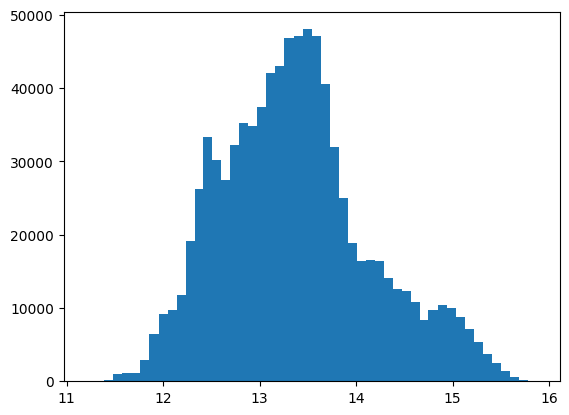





1 MaxEStateIndex 11.2 13.37 15.875


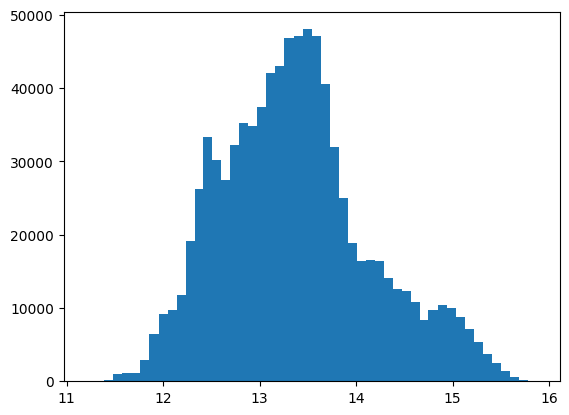





2 MinAbsEStateIndex 0.0 0.0736 0.4292


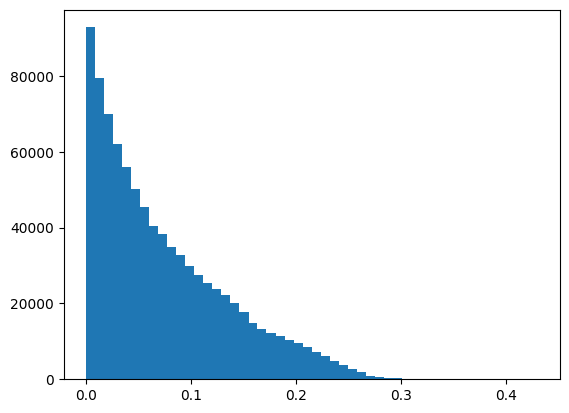





3 MinEStateIndex -6.016 -1.441 0.1566


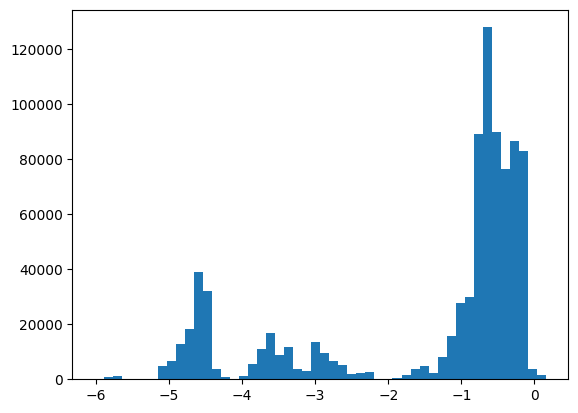





4 qed 0.012566 0.345 0.9424


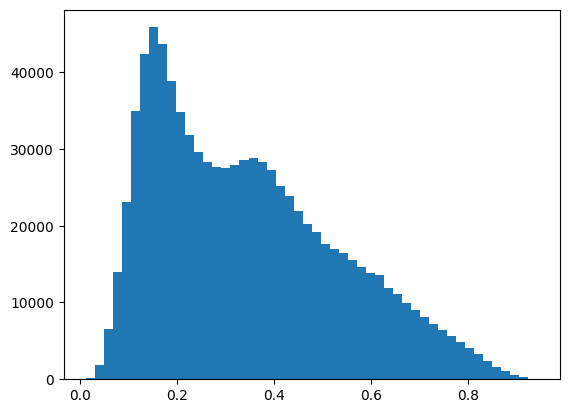





5 SPS 9.66 16.5 58.6


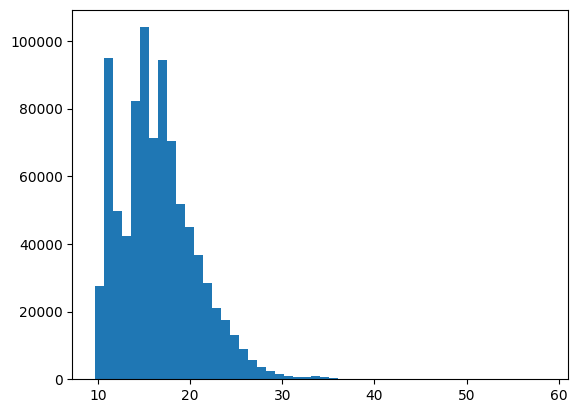





6 MolWt 273.2 557.5 1213.0


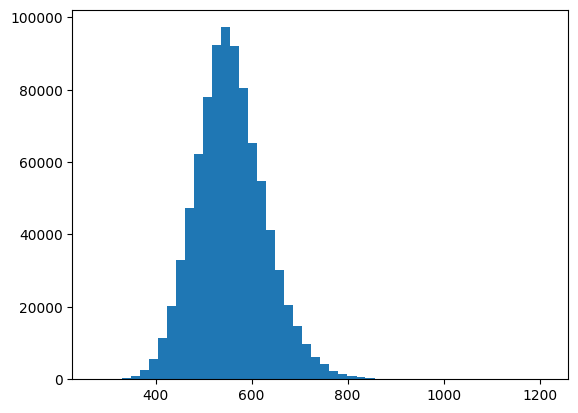





7 HeavyAtomMolWt 254.1 527.0 1166.0


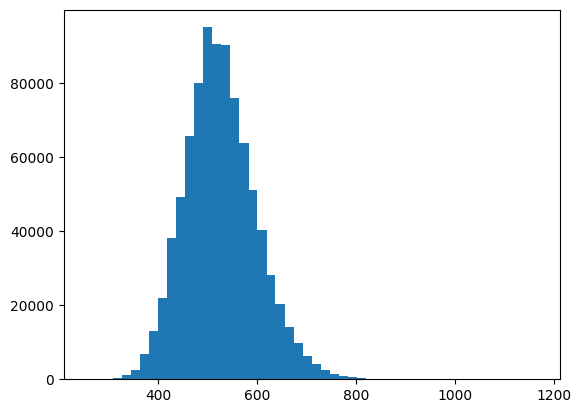





8 ExactMolWt 273.2 557.0 1211.0


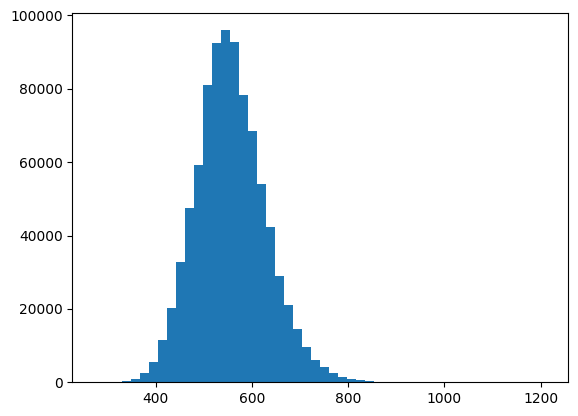





9 NumValenceElectrons 106.0 206.1 356.0


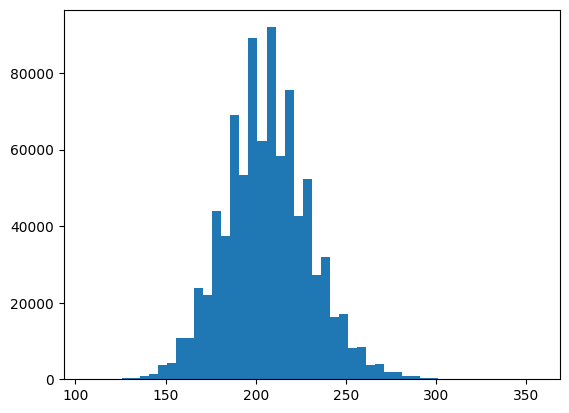





10 NumRadicalElectrons 0.0 0.0 0.0


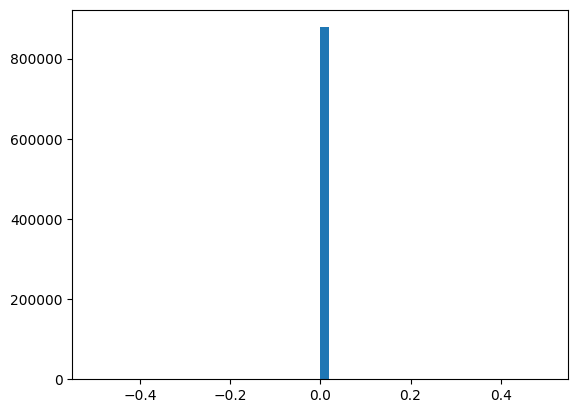





11 MaxPartialCharge 0.2249 0.293 0.586


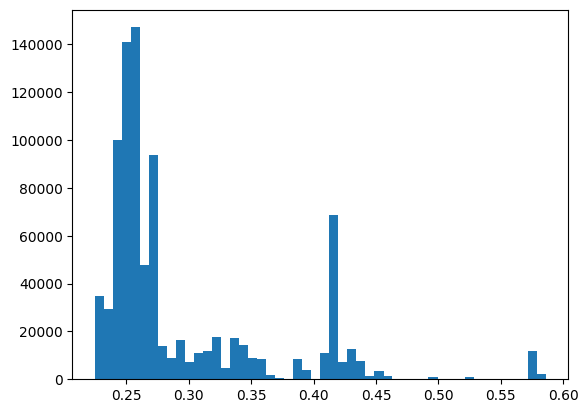





12 MinPartialCharge -0.6187 -0.4211 -0.3538


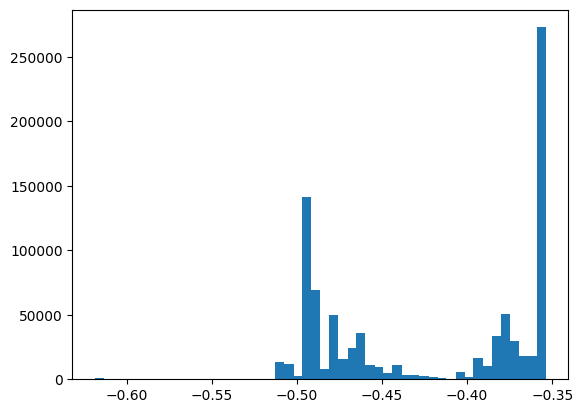





13 MaxAbsPartialCharge 0.3538 0.427 0.6187


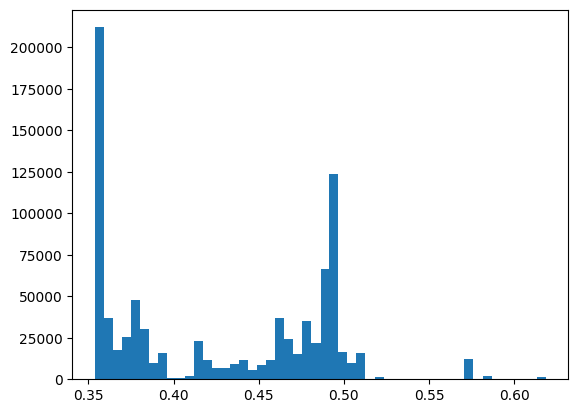





14 MinAbsPartialCharge 0.2249 0.287 0.5728


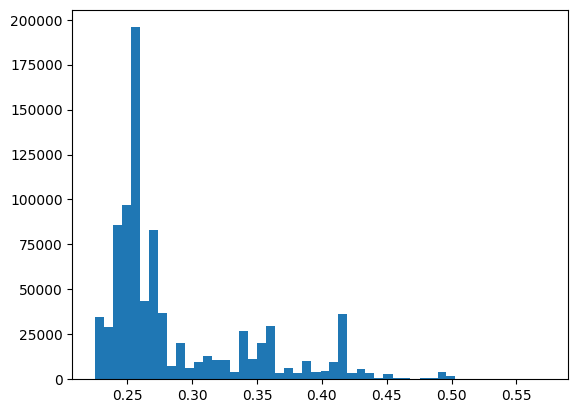





15 FpDensityMorgan1 0.531 1.055 1.619


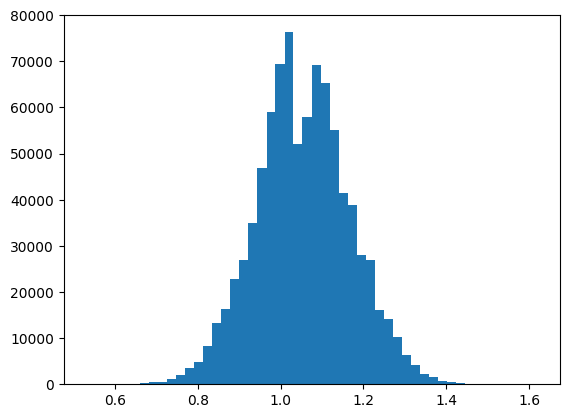





16 FpDensityMorgan2 0.898 1.81 2.4


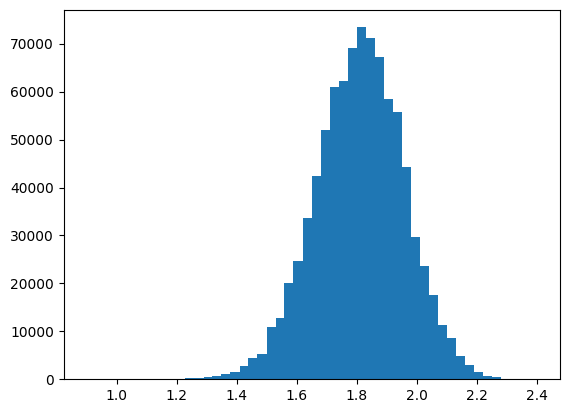





17 FpDensityMorgan3 1.286 2.51 3.125


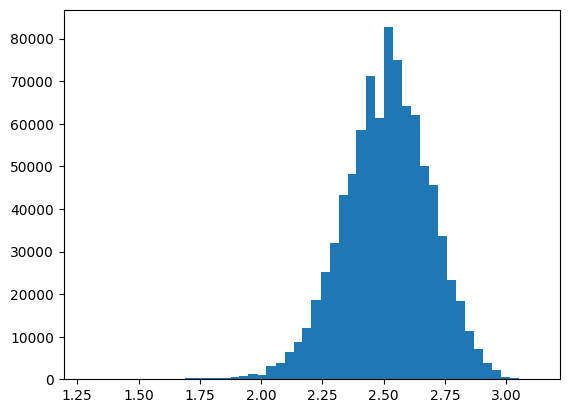





18 BCUT2D_MWHI 16.16 29.11 126.94


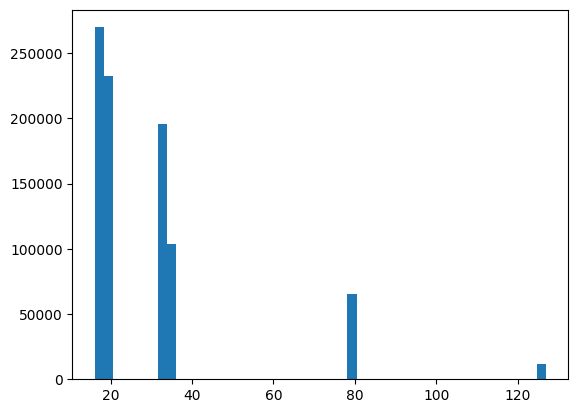





19 BCUT2D_MWLOW 9.49 9.98 10.57


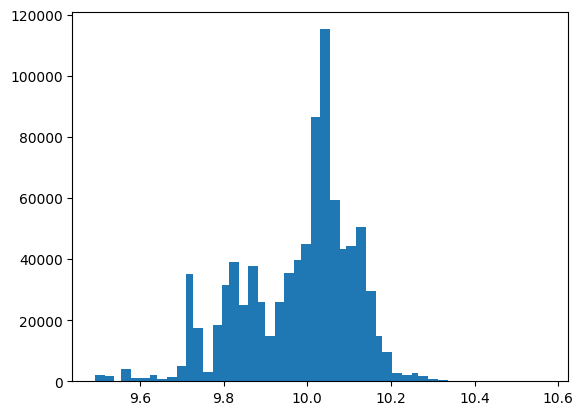





20 BCUT2D_CHGHI 2.072 2.338 2.889


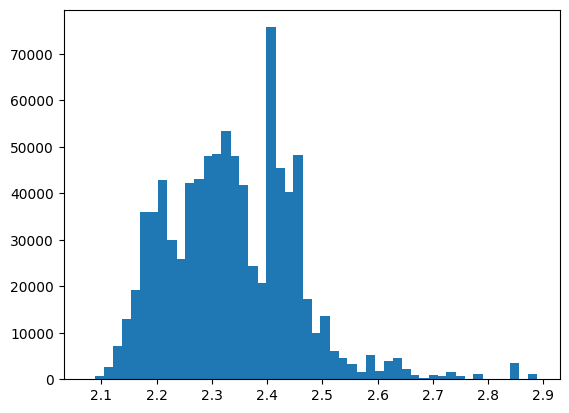





21 BCUT2D_CHGLO -2.564 -2.268 -2.072


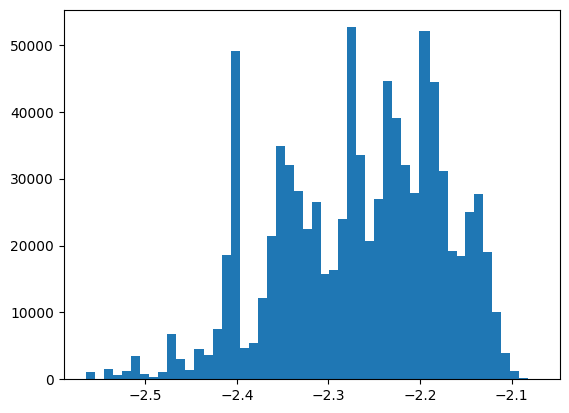





22 BCUT2D_LOGPHI 2.088 2.342 2.86


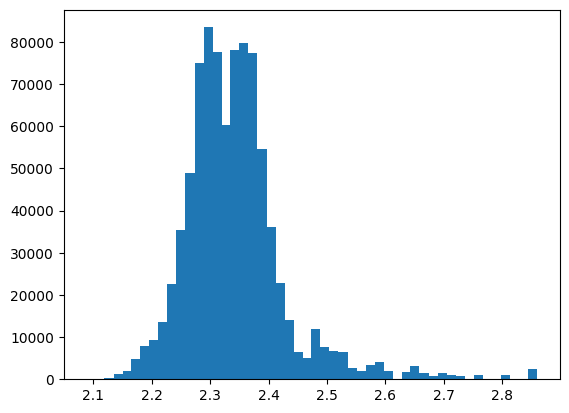





23 BCUT2D_LOGPLOW -2.668 -2.398 -2.156


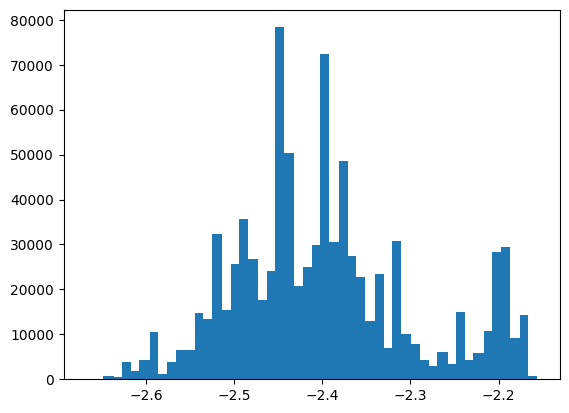





24 BCUT2D_MRHI 5.754 6.723 14.12


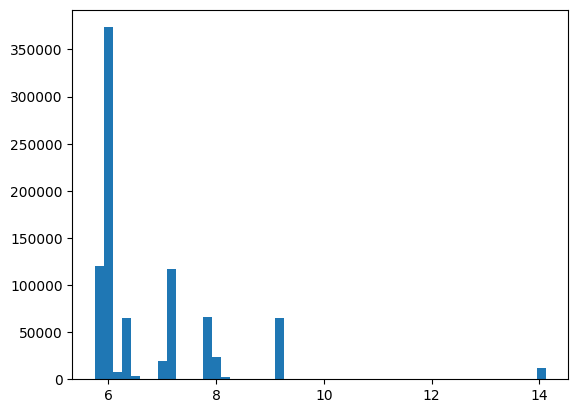





25 BCUT2D_MRLOW -0.6055 -0.0999 0.09674


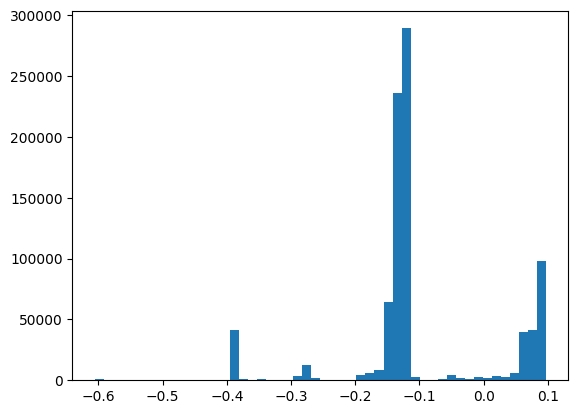





26 AvgIpc 2.406 3.426 4.12


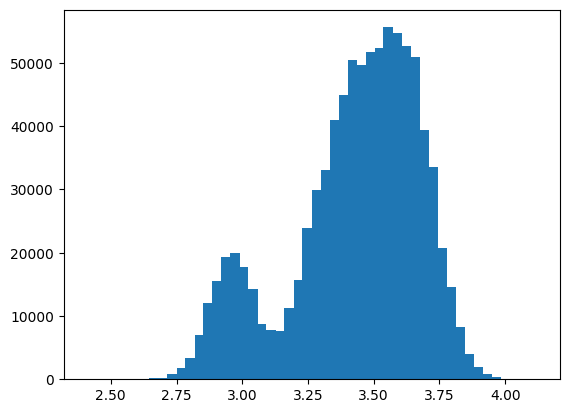





27 BalabanJ 0.7417 1.432 3.19


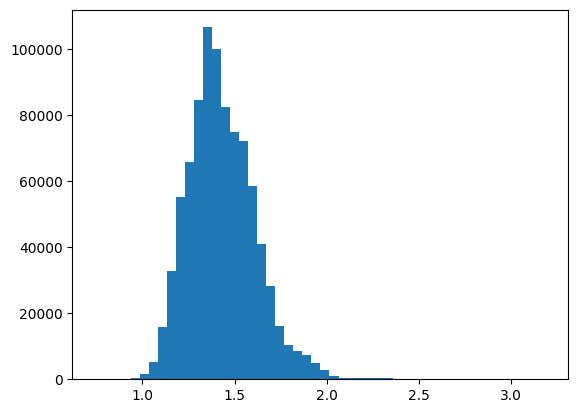





28 BertzCT 514.0 1466.0 3188.0


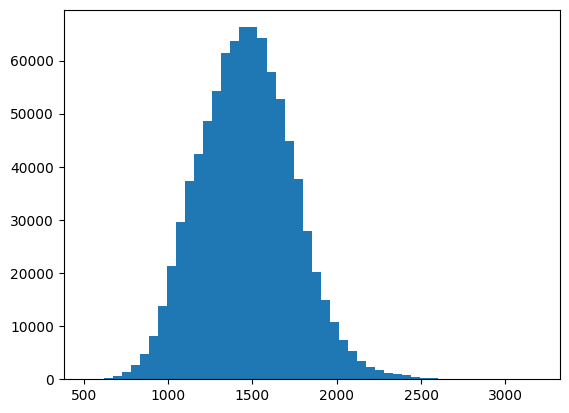





29 Chi0 14.27 27.95 47.4


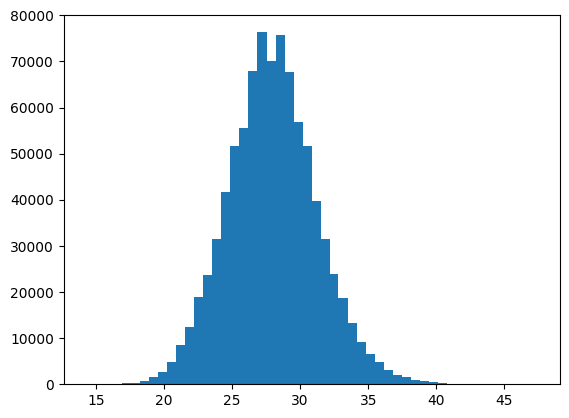





30 Chi0n 11.836 22.11 38.4


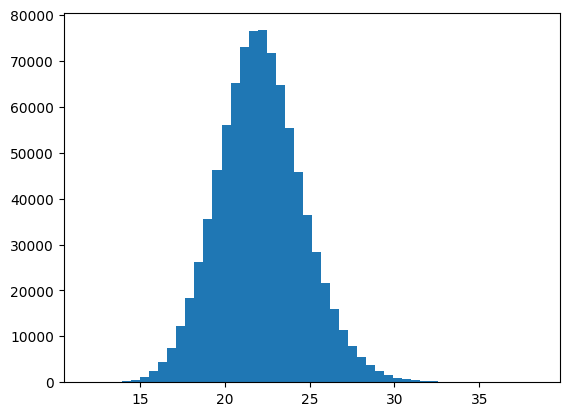





31 Chi0v 11.836 22.7 42.06


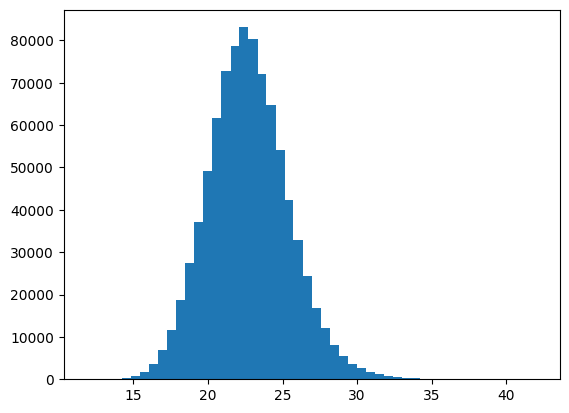





32 Chi1 9.44 19.05 34.4


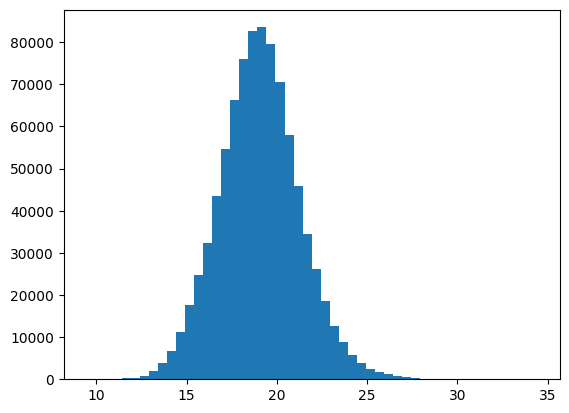





33 Chi1n 6.562 12.87 23.44


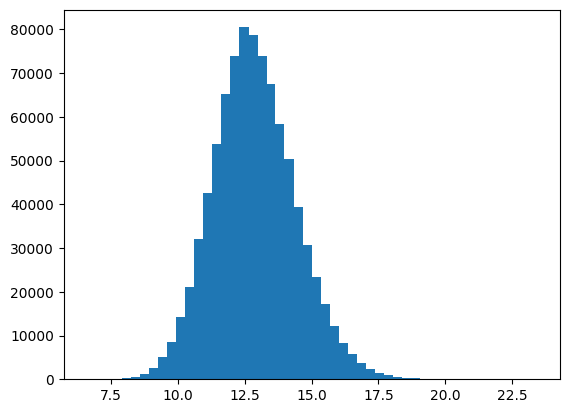





34 Chi1v 6.598 13.4 23.53


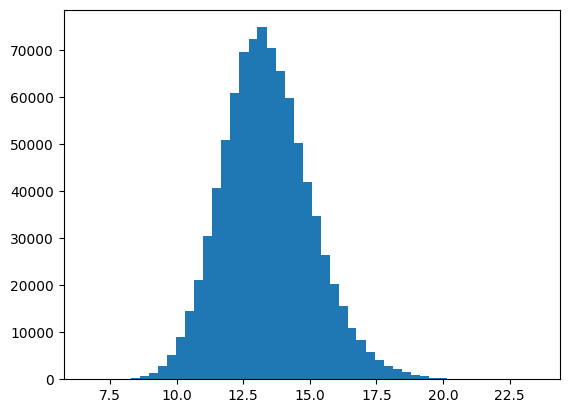





35 Chi2n 4.297 9.7 18.48


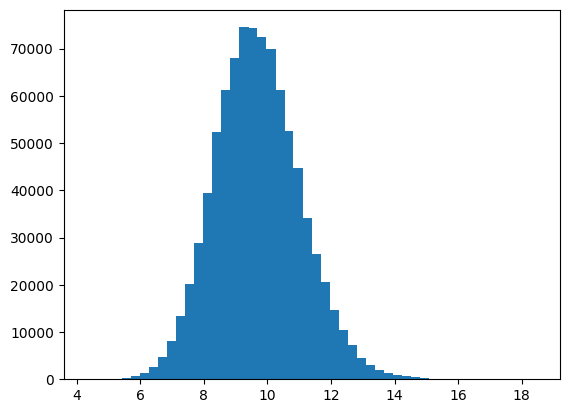





36 Chi2v 4.793 10.3 21.78


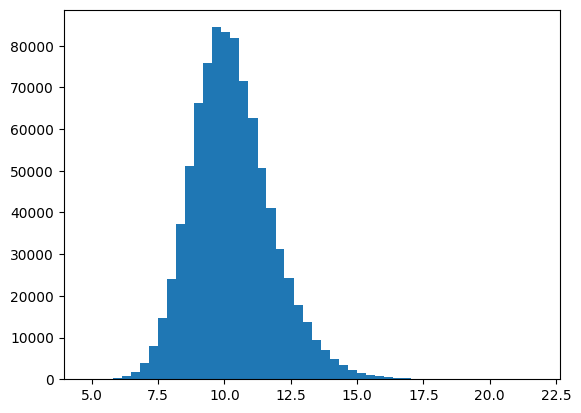





37 Chi3n 2.39 6.914 17.75


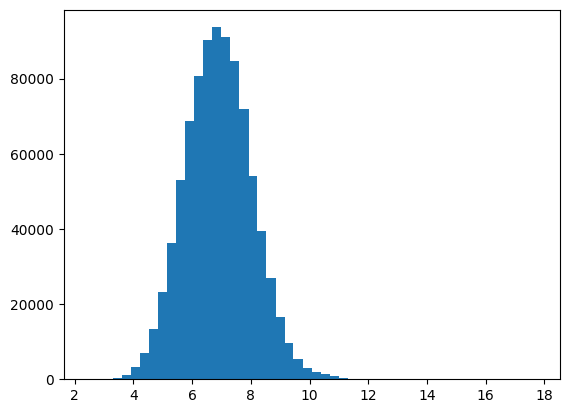





38 Chi3v 2.68 7.39 17.75


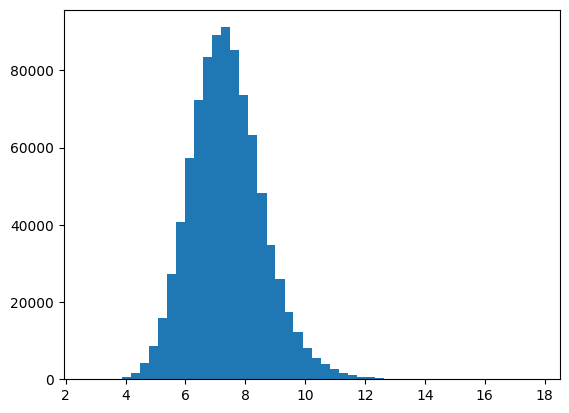





39 Chi4n 1.358 4.805 17.05


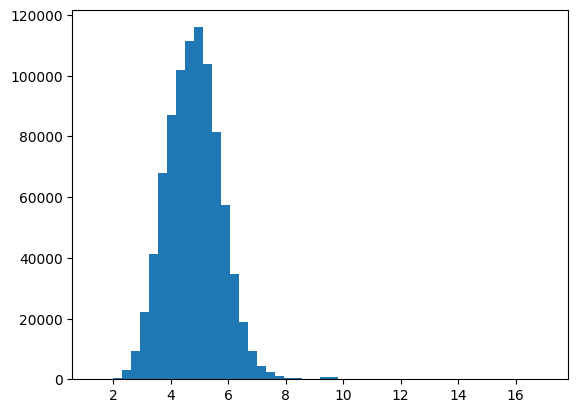





40 Chi4v 1.503 5.184 17.05


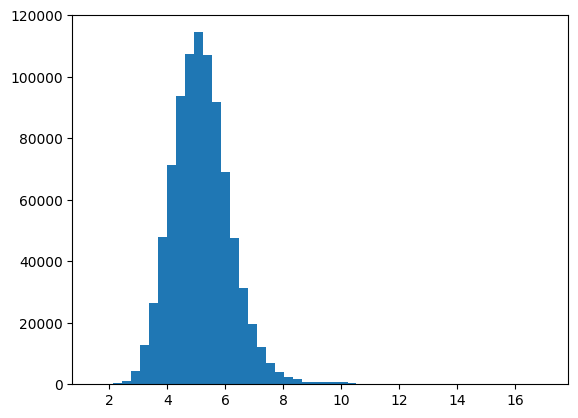





41 HallKierAlpha -8.96 -4.215 -0.39


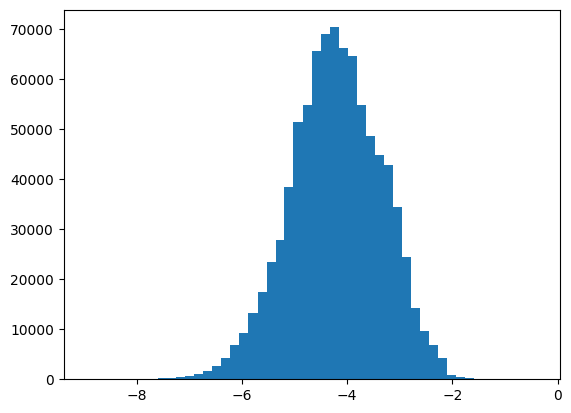





42 Ipc 10.516 20.62 37.34


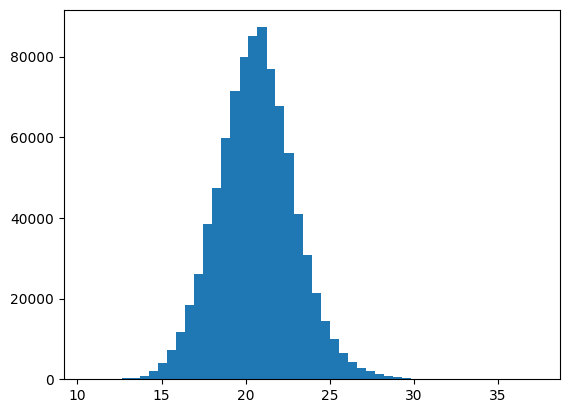





43 Kappa1 13.15 27.11 48.03


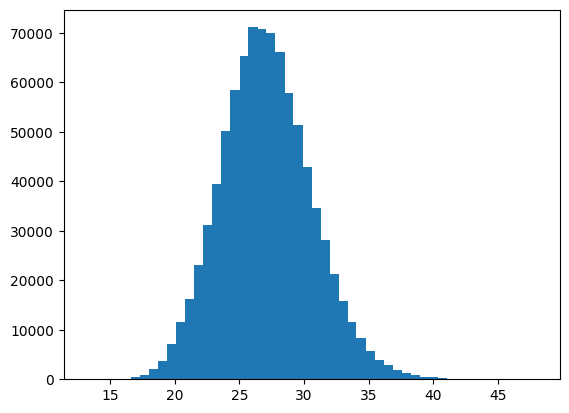





44 Kappa2 4.86 11.61 22.8


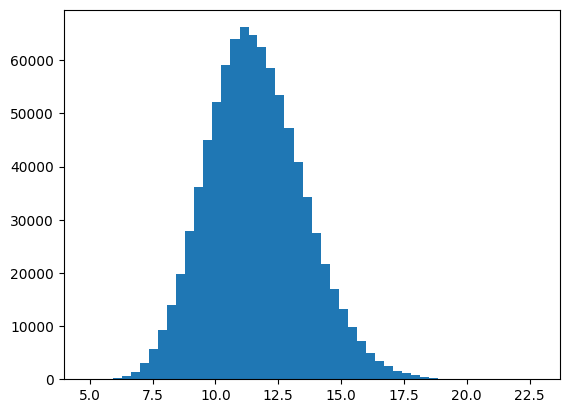





45 Kappa3 2.033 6.11 15.04


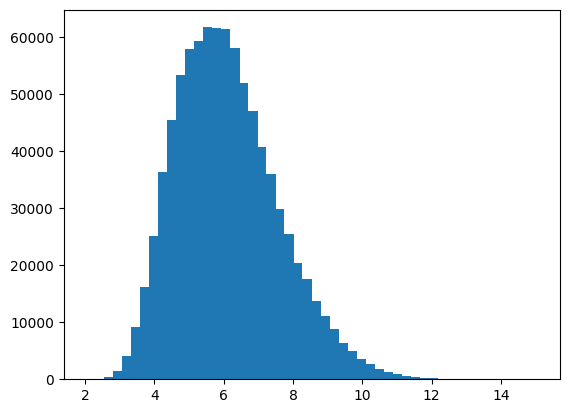





46 LabuteASA 116.5 231.0 403.5


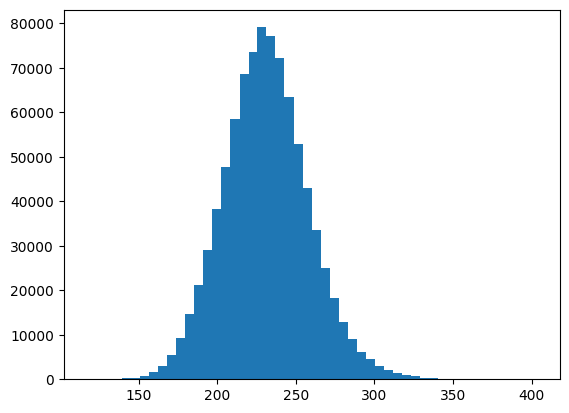





47 PEOE_VSA1 5.316 23.11 56.4


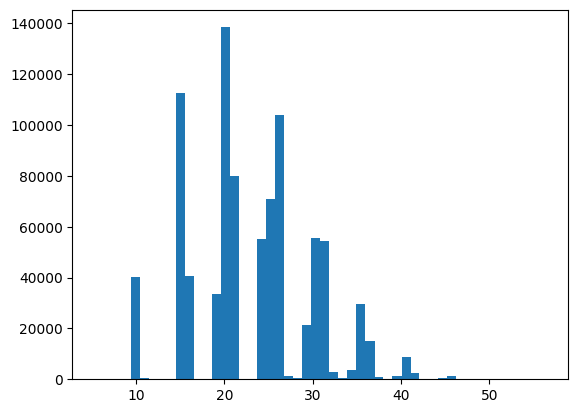





48 PEOE_VSA10 0.0 11.18 54.75


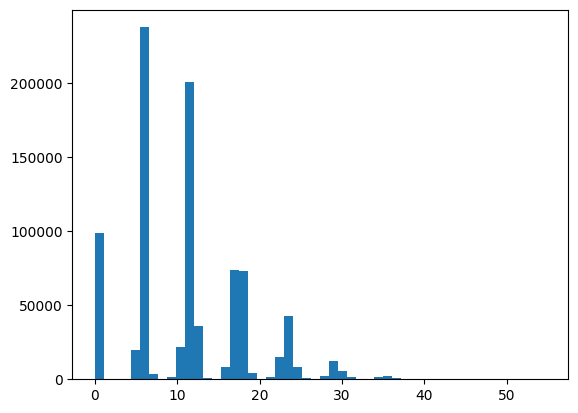





49 PEOE_VSA11 0.0 3.945 52.34


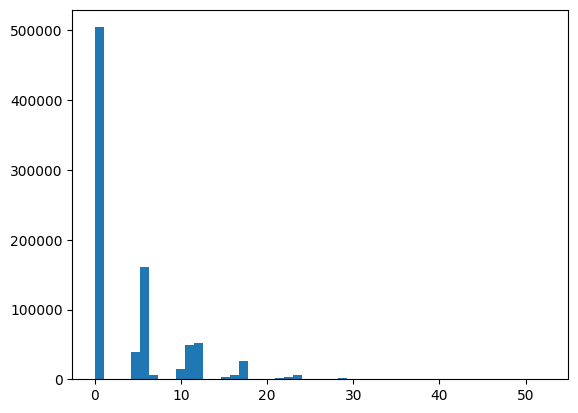





50 PEOE_VSA12 0.0 14.75 65.0


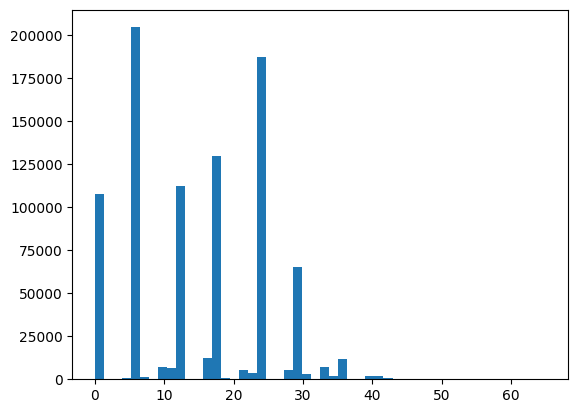





51 PEOE_VSA13 0.0 6.035 37.78


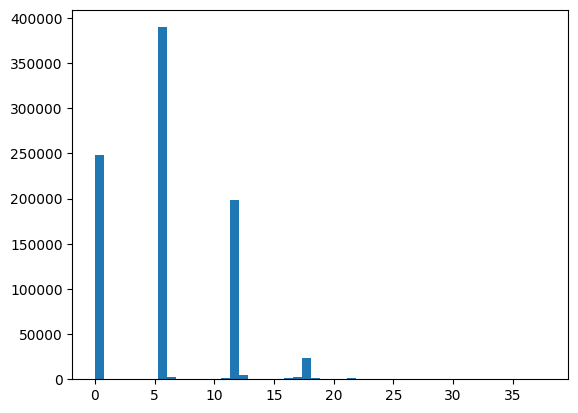





52 PEOE_VSA14 0.0 1.912 31.17


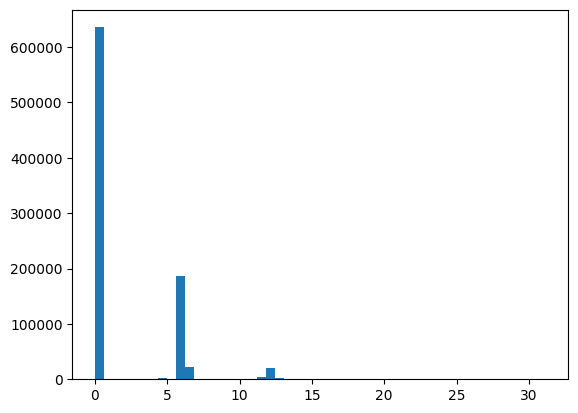





53 PEOE_VSA2 4.793 12.41 64.7


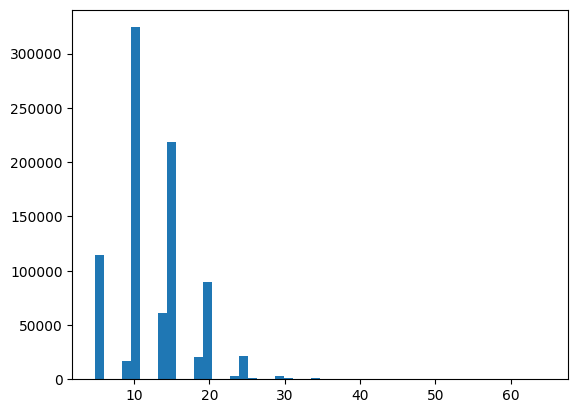





54 PEOE_VSA3 0.0 7.574 49.78


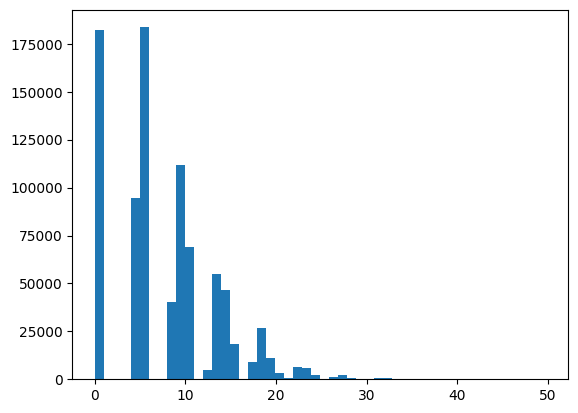





55 PEOE_VSA4 0.0 10.97 71.4


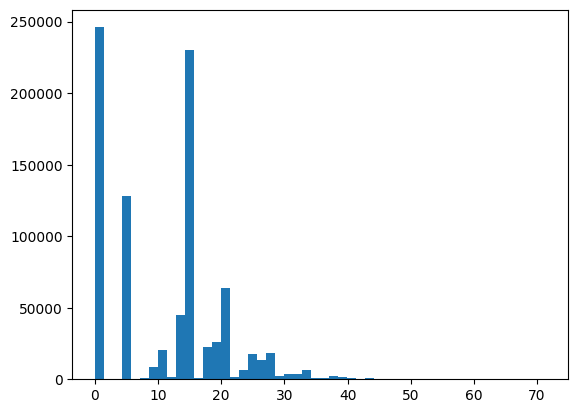





56 PEOE_VSA5 0.0 3.107 48.03


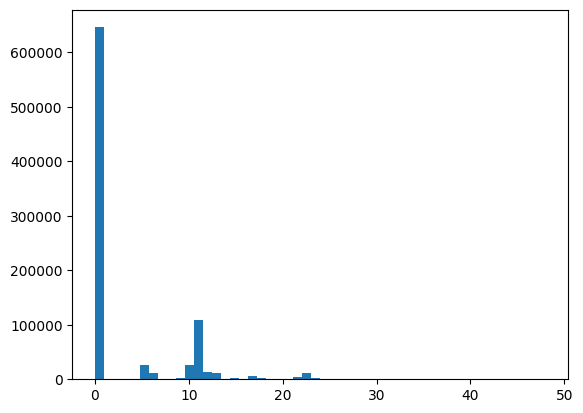





57 PEOE_VSA6 0.0 21.81 129.0


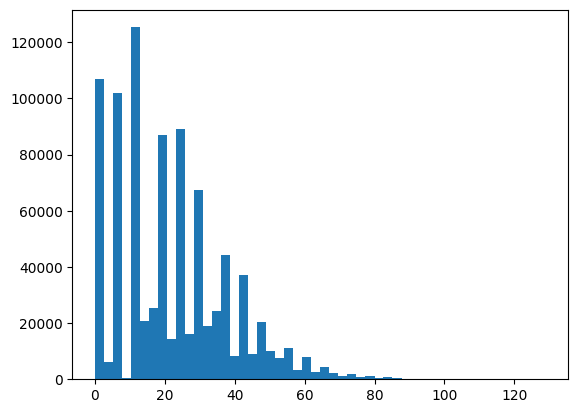





58 PEOE_VSA7 0.0 50.53 162.1


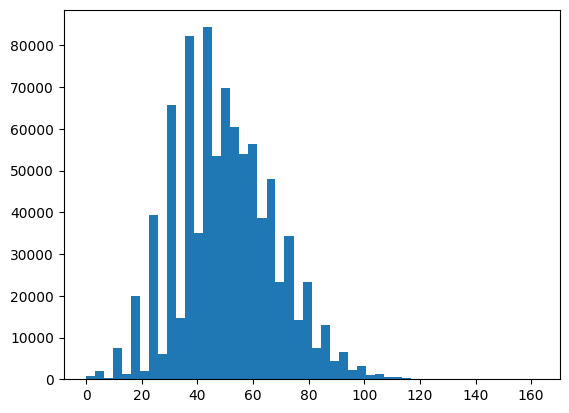





59 PEOE_VSA8 7.047 44.2 116.44


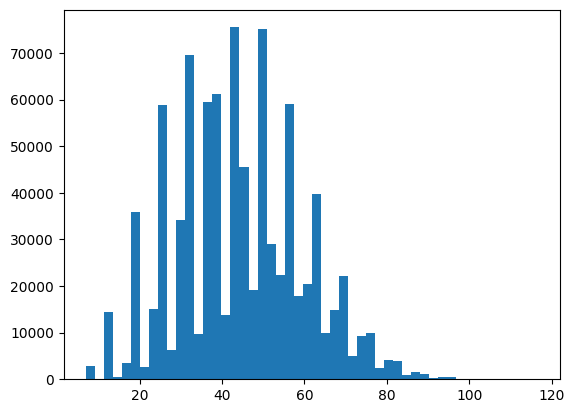





60 PEOE_VSA9 0.0 19.86 82.06


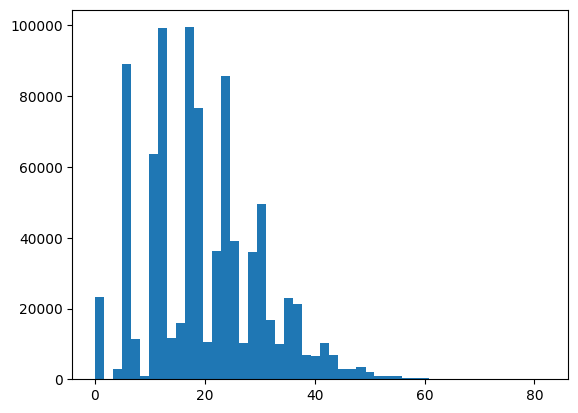





61 SMR_VSA1 4.793 18.66 62.62


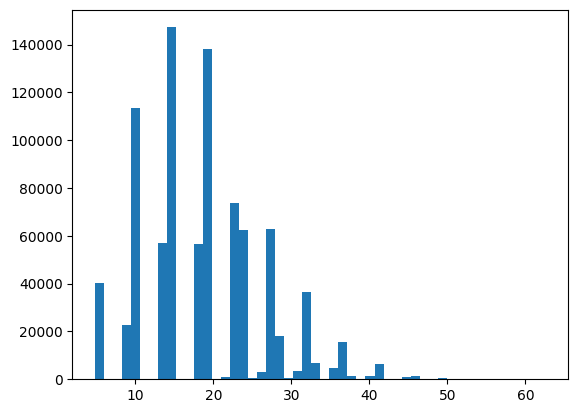





62 SMR_VSA10 11.81 36.38 173.0


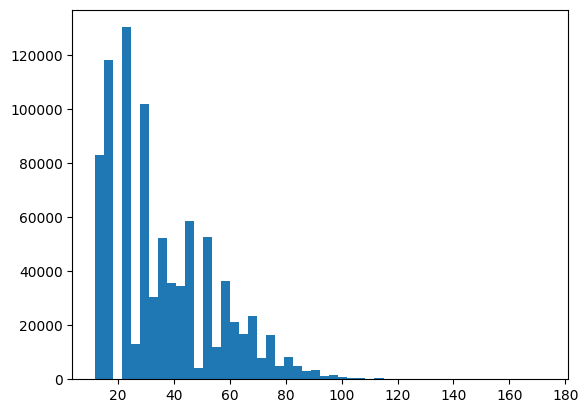





63 SMR_VSA2 0.0 0.4316 15.79


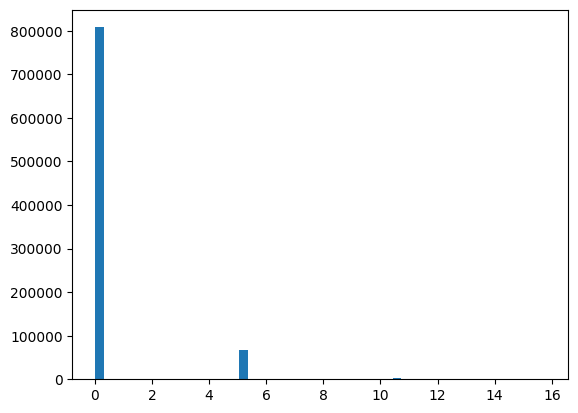





64 SMR_VSA3 10.22 26.31 79.56


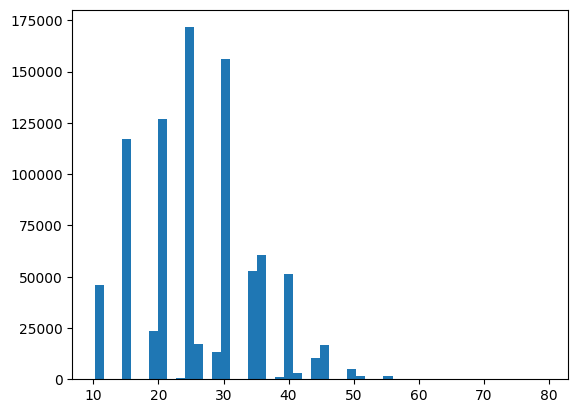





65 SMR_VSA4 0.0 4.004 106.5


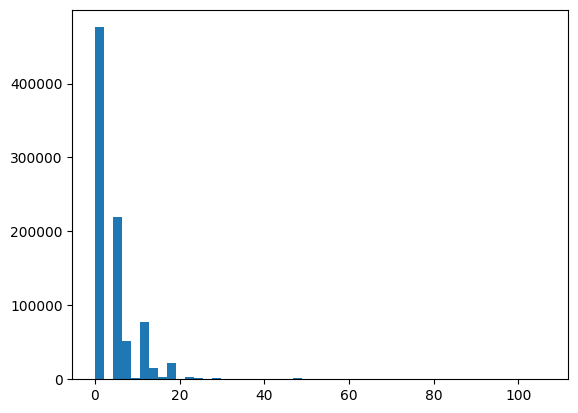





66 SMR_VSA5 0.0 33.06 140.5


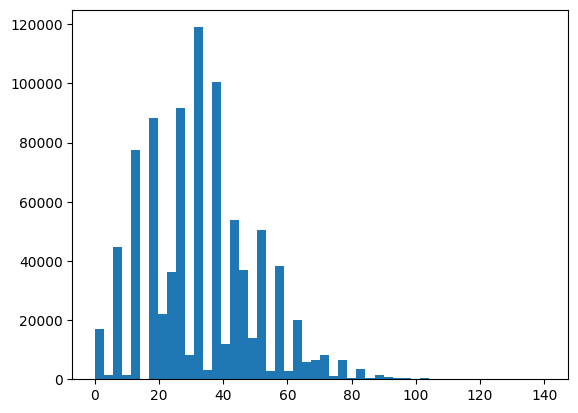





67 SMR_VSA6 13.59 34.75 135.5


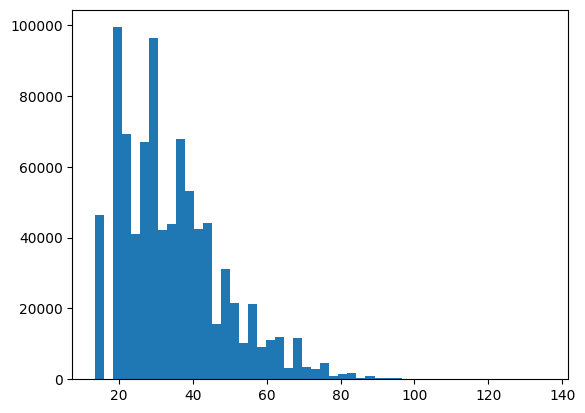





68 SMR_VSA7 0.0 67.06 188.8


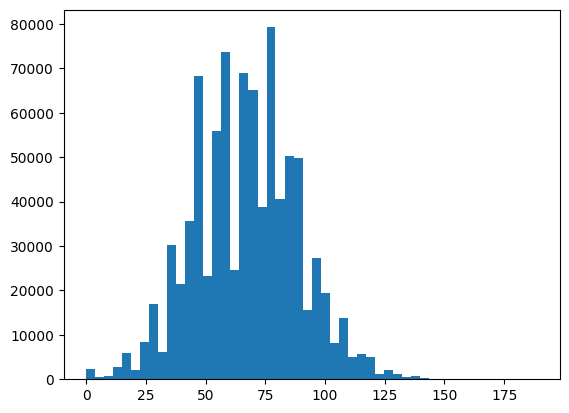





69 SMR_VSA8 0.0 0.0 0.0


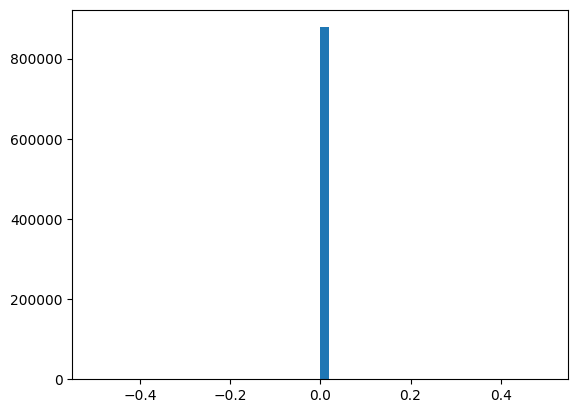





70 SMR_VSA9 0.0 10.8 52.25


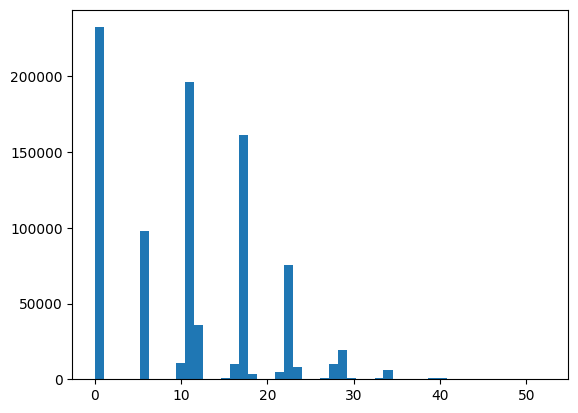





71 SlogP_VSA1 5.316 17.78 53.25


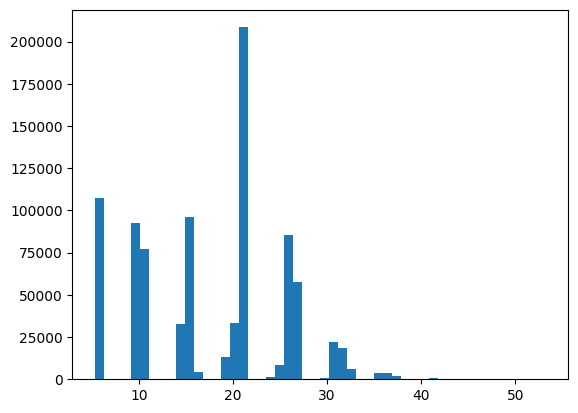





72 SlogP_VSA10 0.0 17.97 85.8


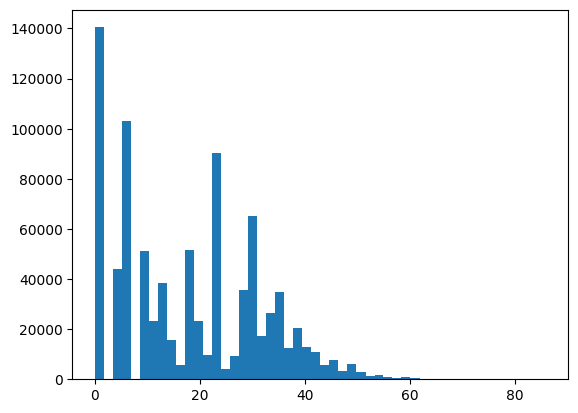





73 SlogP_VSA11 0.0 2.777 34.62


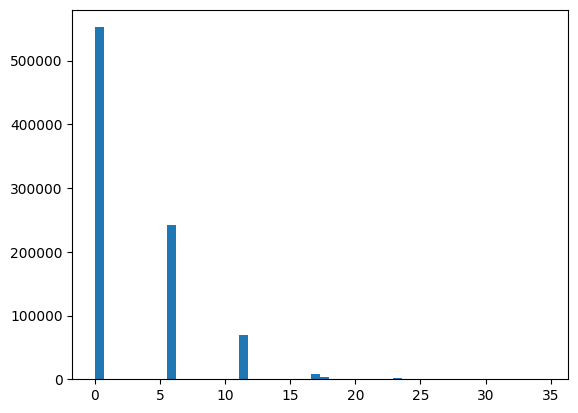





74 SlogP_VSA12 0.0 6.965 119.2


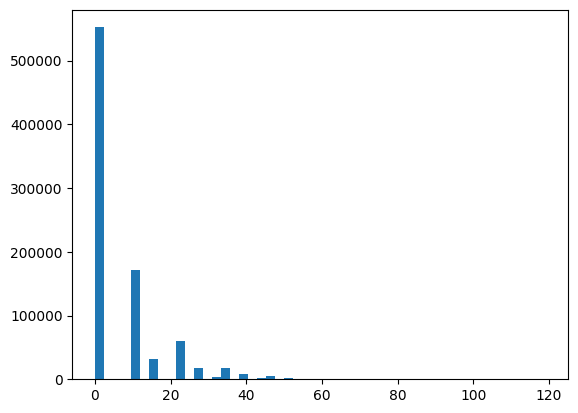





75 SlogP_VSA2 27.9 63.66 174.4


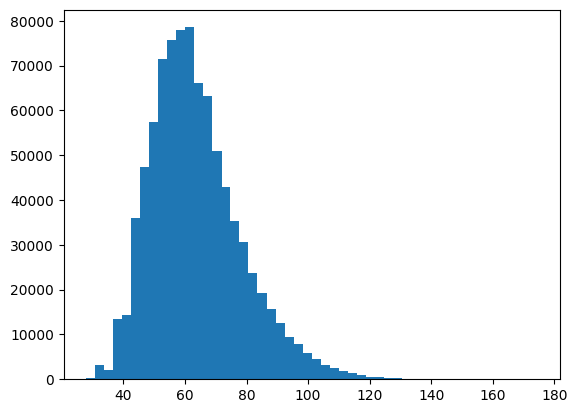





76 SlogP_VSA3 0.0 13.13 74.7


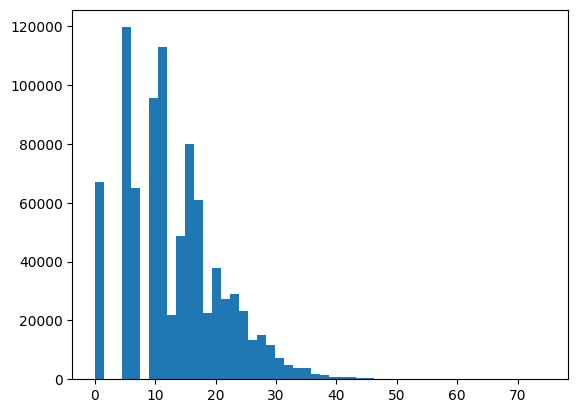





77 SlogP_VSA4 0.0 9.7 106.5


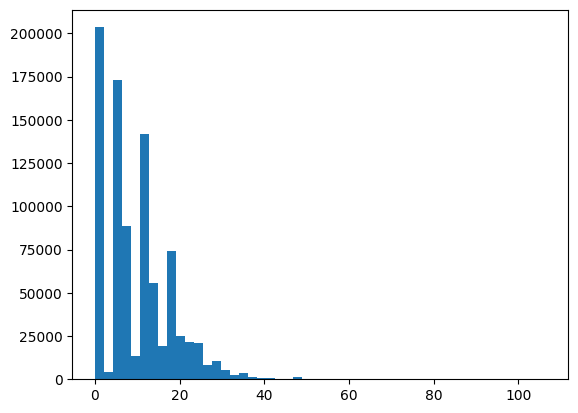





78 SlogP_VSA5 0.0 37.28 133.1


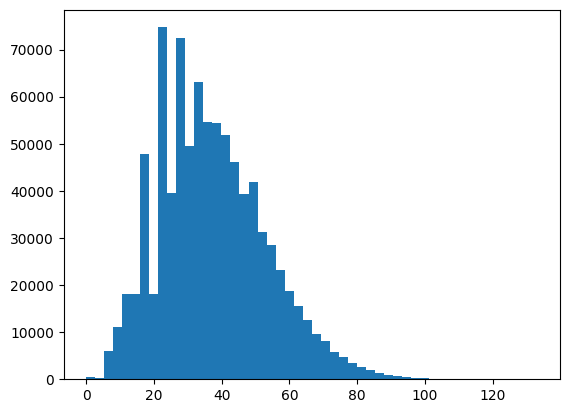





79 SlogP_VSA6 0.0 50.1 162.6


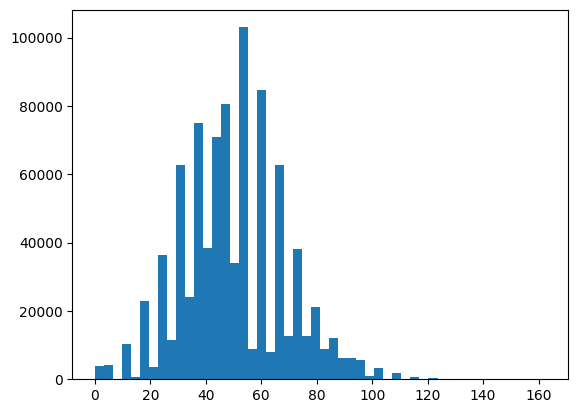





80 SlogP_VSA7 0.0 1.019 34.84


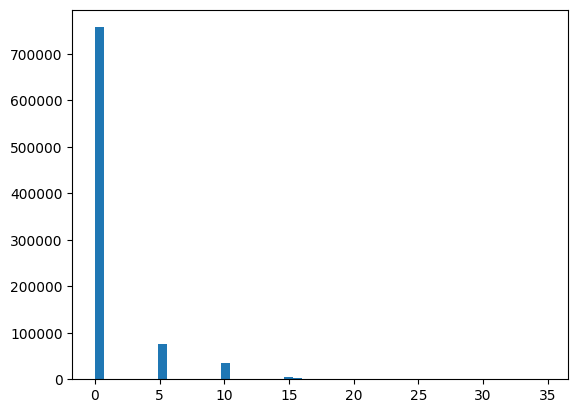





81 SlogP_VSA8 0.0 11.01 61.44


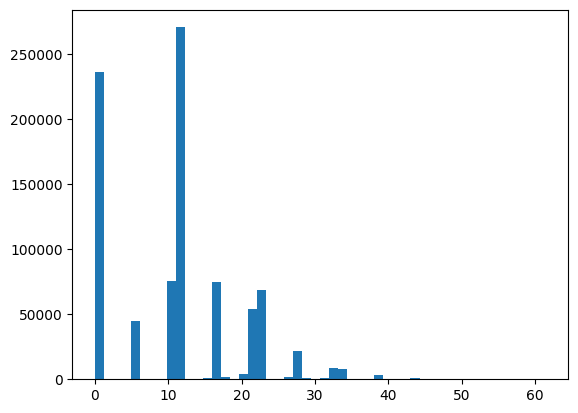





82 SlogP_VSA9 0.0 0.0 0.0


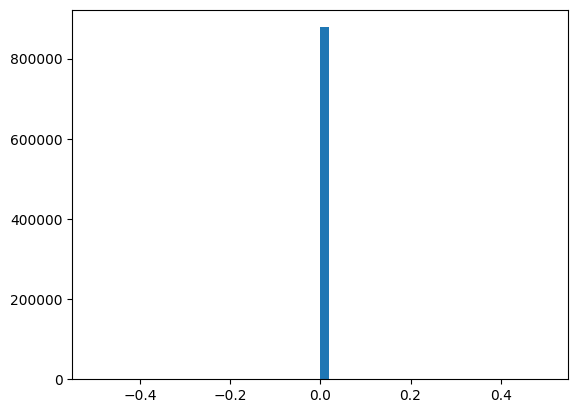





83 TPSA 49.4 127.1 327.0


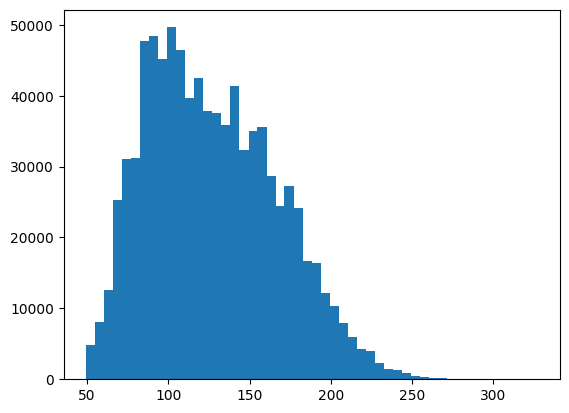





84 EState_VSA1 0.0 11.53 122.2


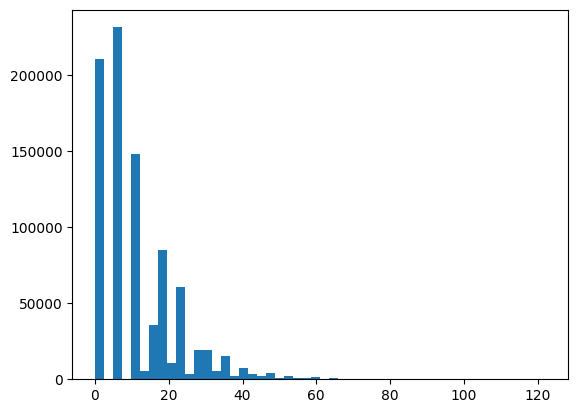





85 EState_VSA10 4.793 14.95 64.56


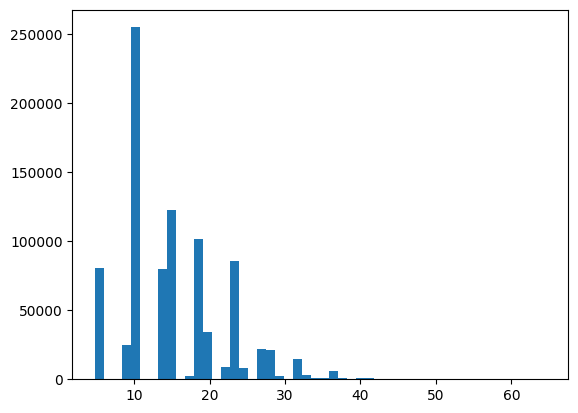





86 EState_VSA11 0.0 0.1709 17.56


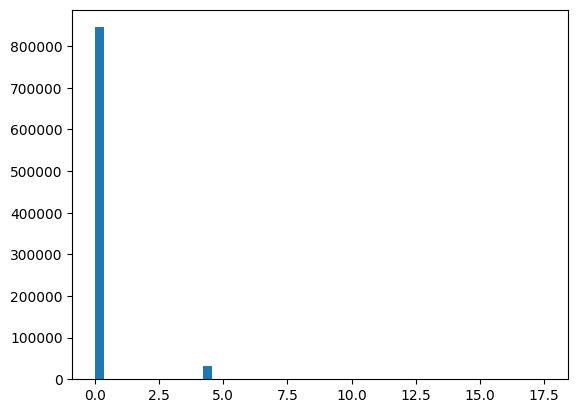





87 EState_VSA2 0.0 30.73 111.2


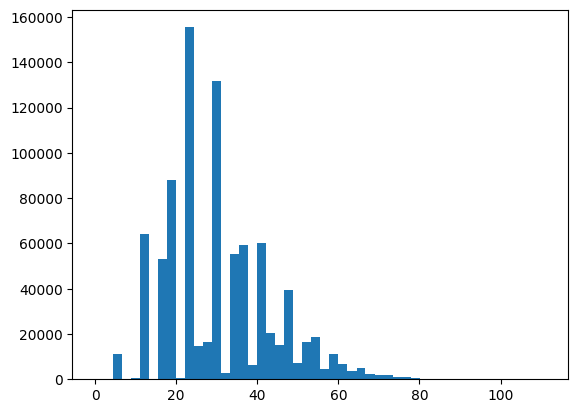





88 EState_VSA3 0.0 34.44 126.4


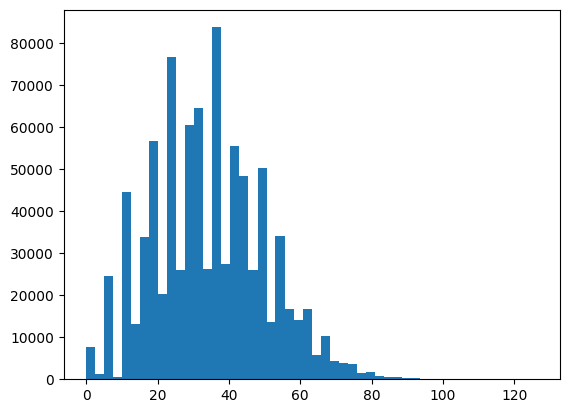





89 EState_VSA4 0.0 26.53 127.75


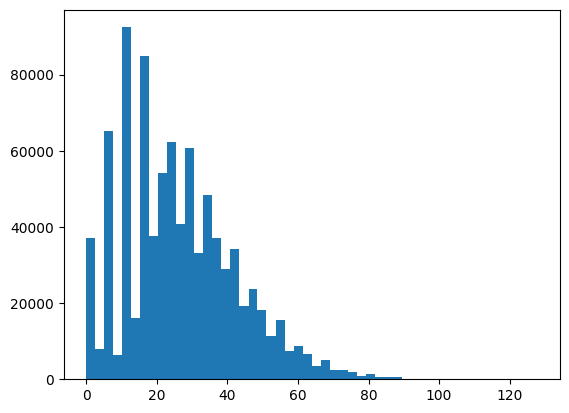





90 EState_VSA5 0.0 15.57 100.8


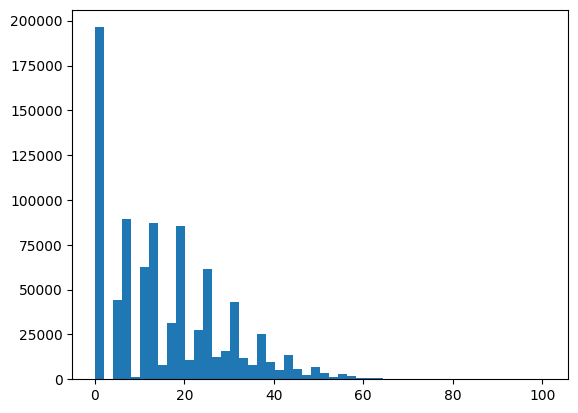





91 EState_VSA6 0.0 26.48 115.06


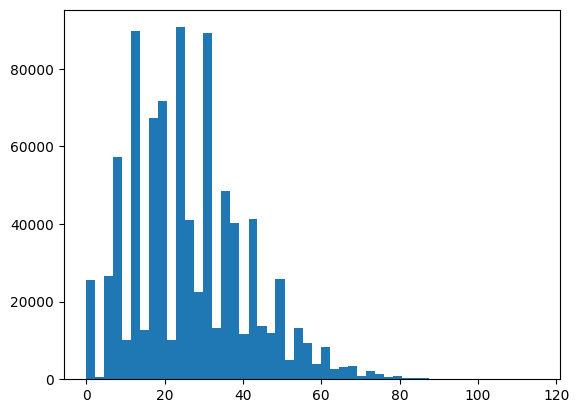





92 EState_VSA7 0.0 25.95 162.5


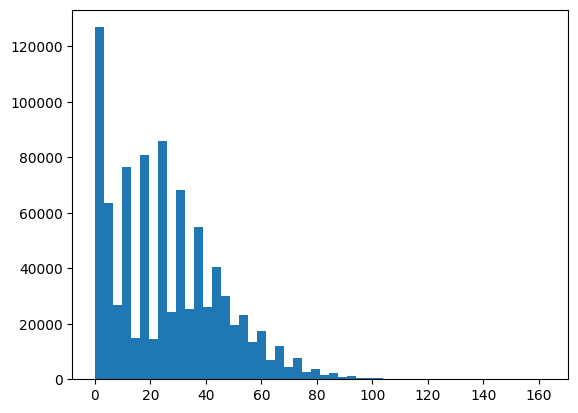





93 EState_VSA8 5.316 37.1 138.1


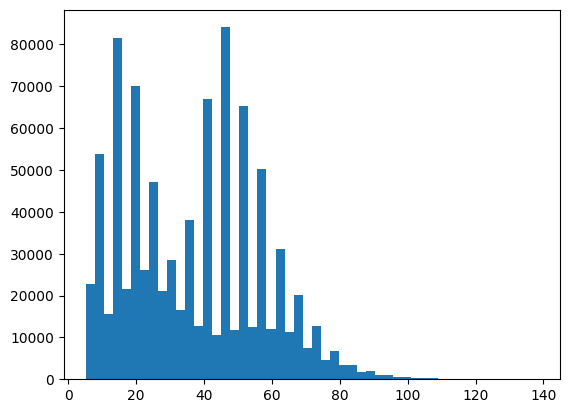





94 EState_VSA9 0.0 7.914 74.3


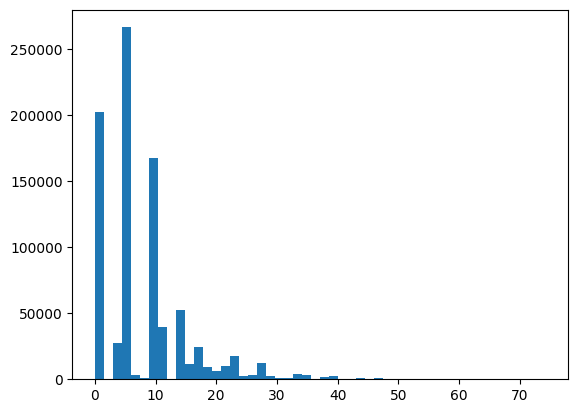





95 VSA_EState1 0.0 20.33 164.6


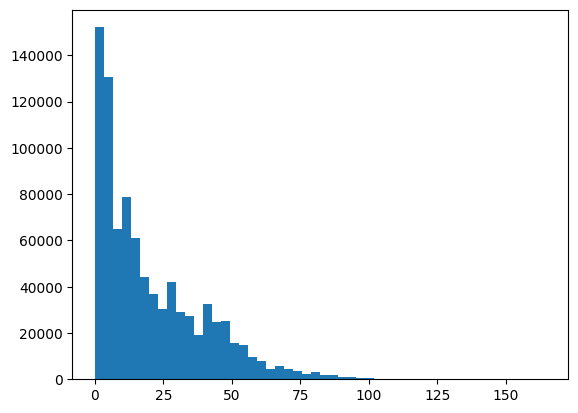





96 VSA_EState10 0.0 1.922 40.6


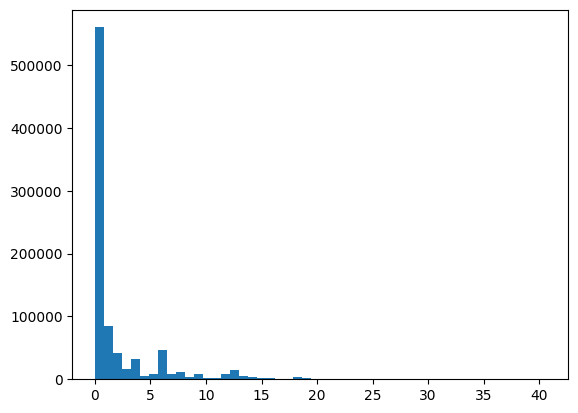





97 VSA_EState2 22.47 37.94 120.5


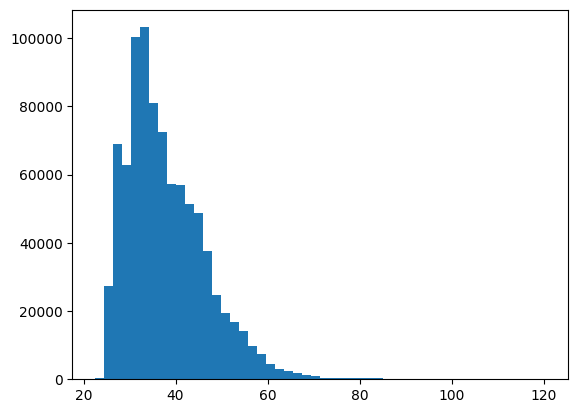





98 VSA_EState3 1.85 12.28 62.06


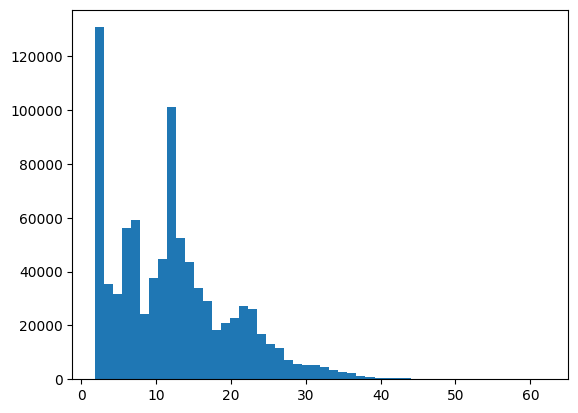





99 VSA_EState4 -9.67 2.629 17.52


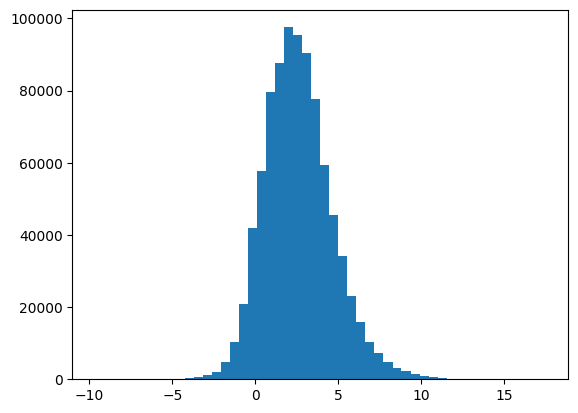





100 VSA_EState5 -21.44 0.01267 13.586


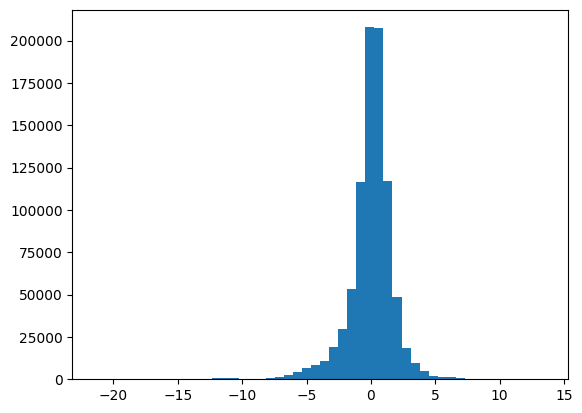





101 VSA_EState6 -2.477 11.05 47.94


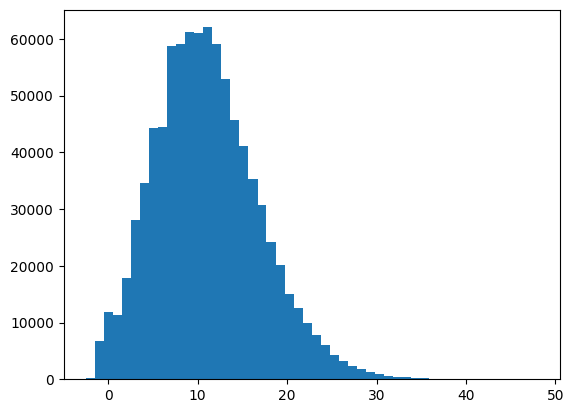





102 VSA_EState7 -15.83 3.586 23.52


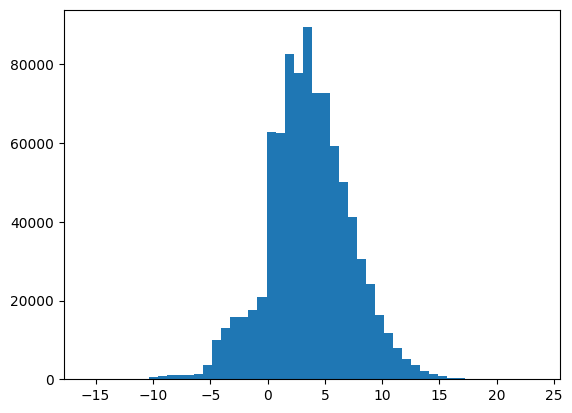





103 VSA_EState8 -6.62 3.244 23.17


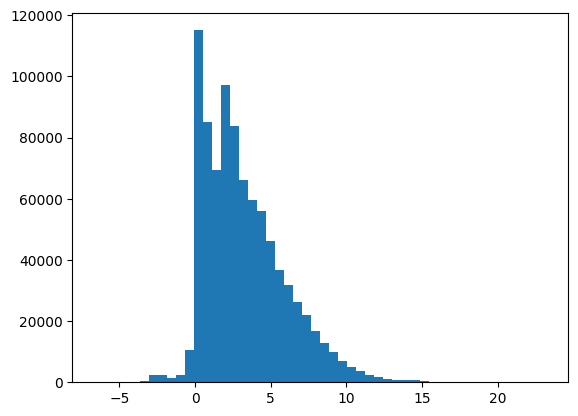





104 VSA_EState9 -6.777 2.049 13.96


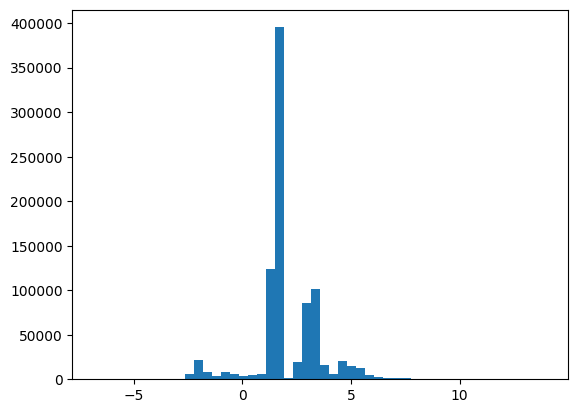





105 FractionCSP3 0.02632 0.3481 0.8887


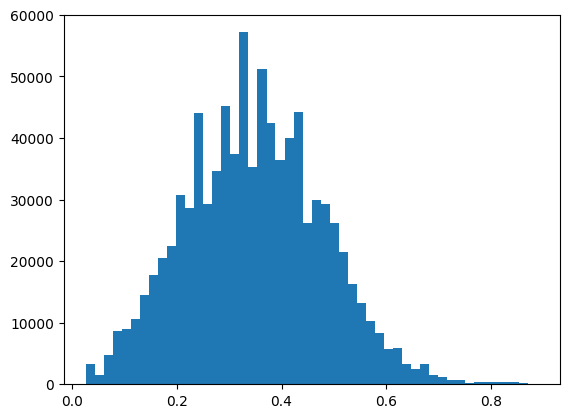





106 HeavyAtomCount 20.0 39.5 70.0


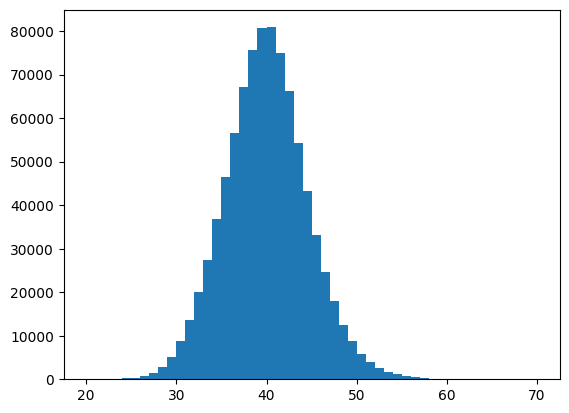





107 NHOHCount 1.0 2.89 11.0


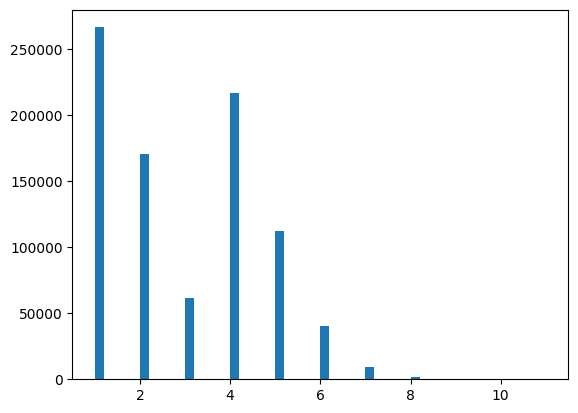





108 NOCount 4.0 10.3 24.0


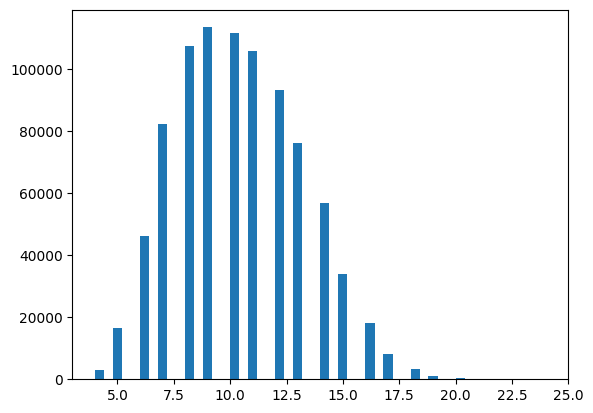





109 NumAliphaticCarbocycles 0.0 0.3474 11.0


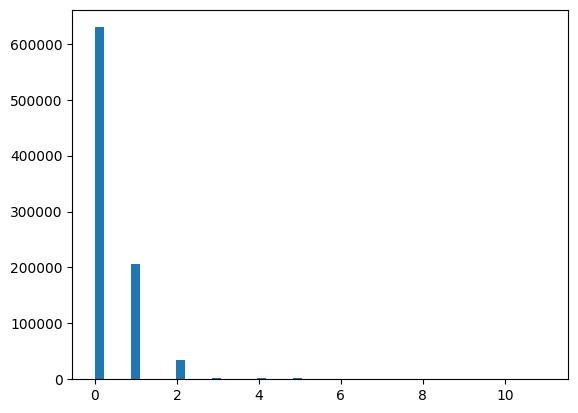





110 NumAliphaticHeterocycles 0.0 1.026 7.0


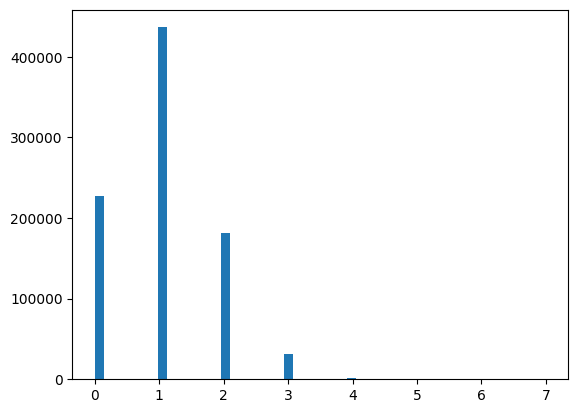





111 NumAliphaticRings 0.0 1.374 11.0


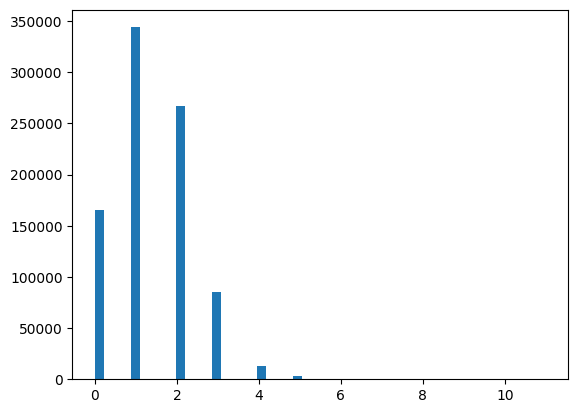





112 NumAromaticCarbocycles 0.0 1.401 6.0


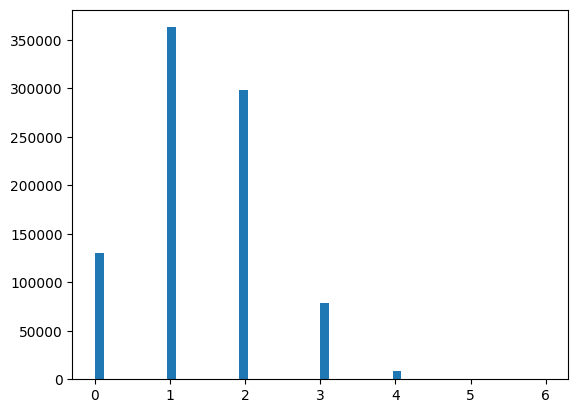





113 NumAromaticHeterocycles 0.0 2.096 7.0


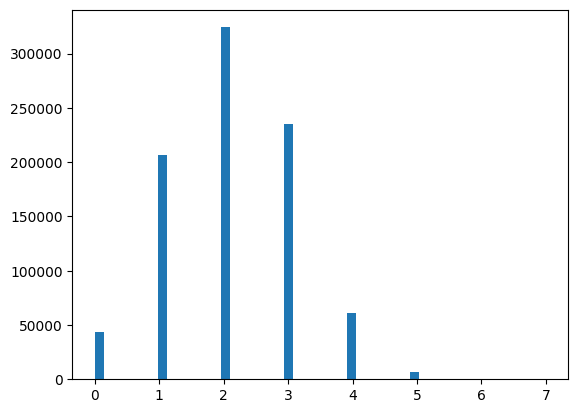





114 NumAromaticRings 1.0 3.496 9.0


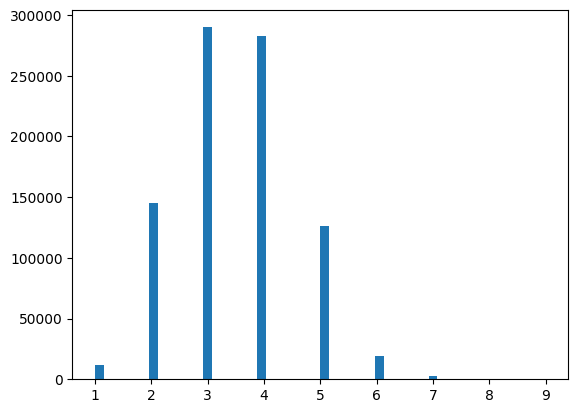





115 NumHAcceptors 2.0 8.49 21.0


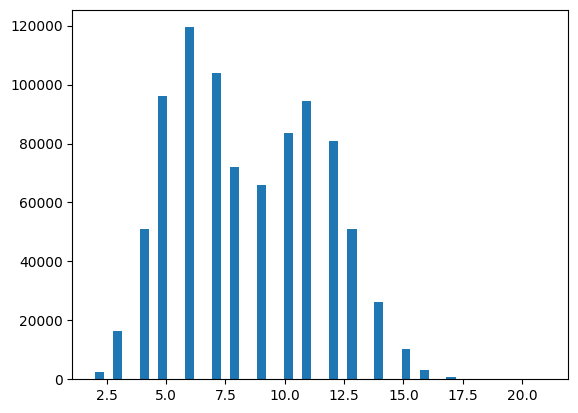





116 NumHDonors 1.0 2.87 9.0


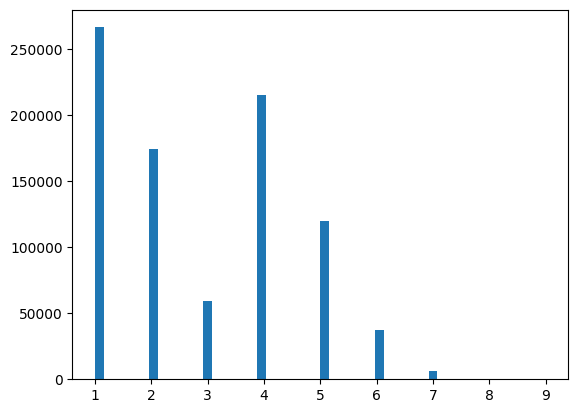





117 NumHeteroatoms 4.0 11.85 25.0


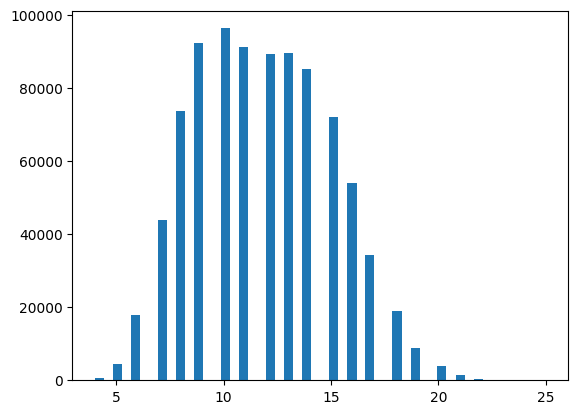





118 NumRotatableBonds 3.0 8.42 22.0


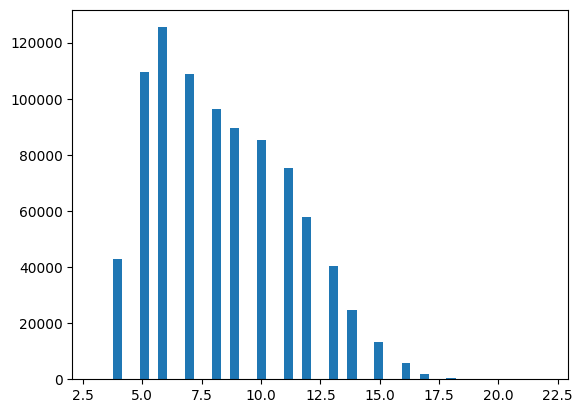





119 NumSaturatedCarbocycles 0.0 0.3035 11.0


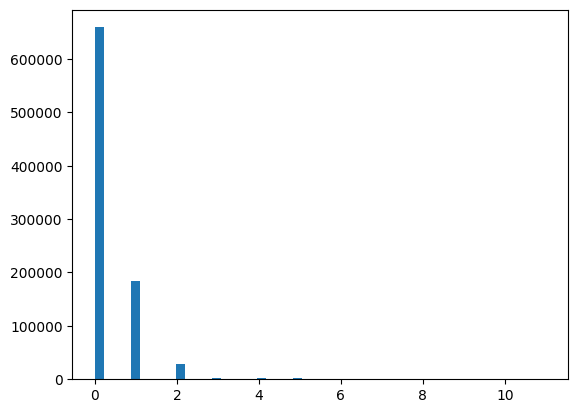





120 NumSaturatedHeterocycles 0.0 0.829 6.0


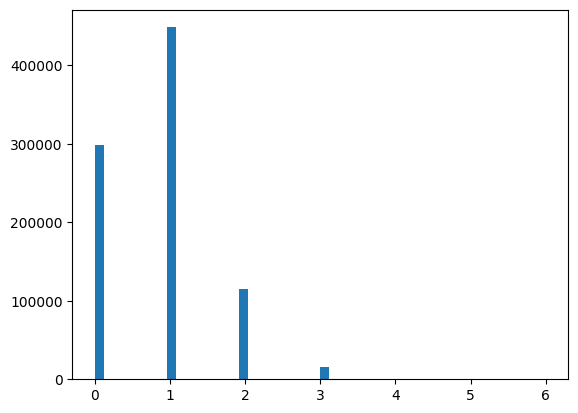





121 NumSaturatedRings 0.0 1.133 11.0


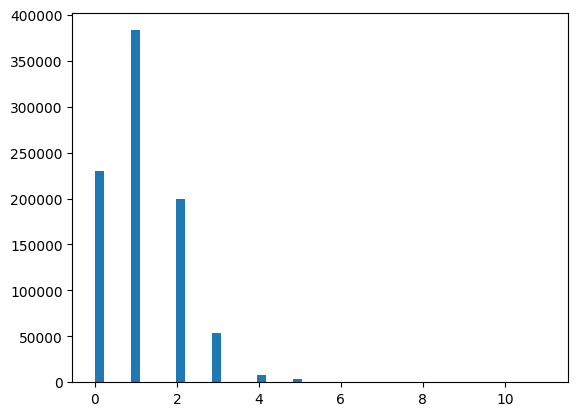





122 RingCount 1.0 4.87 13.0


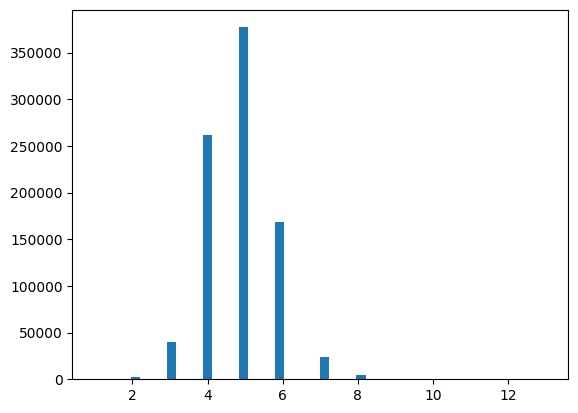





123 MolLogP -3.275 3.812 11.625


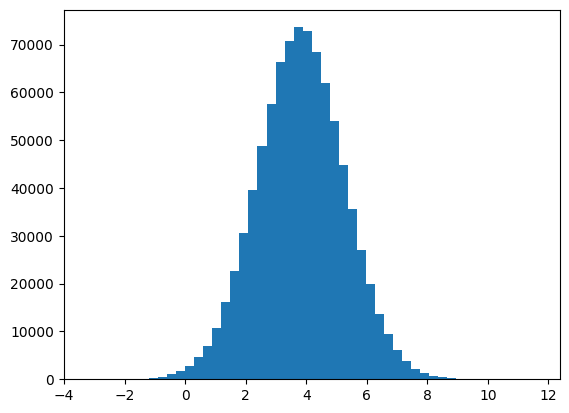





124 MolMR 70.75 148.2 266.5


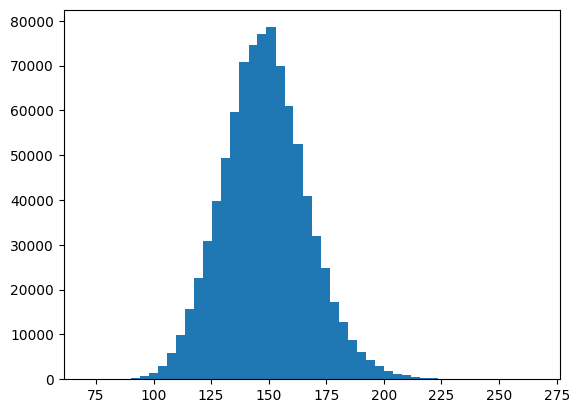





125 fr_Al_COO 0.0 0.0 0.0


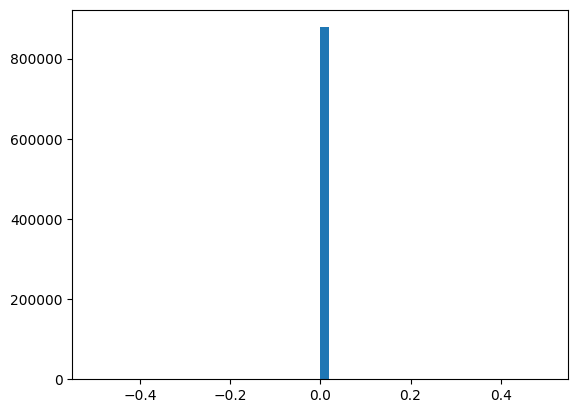





126 fr_Al_OH 0.0 0.04895 3.0


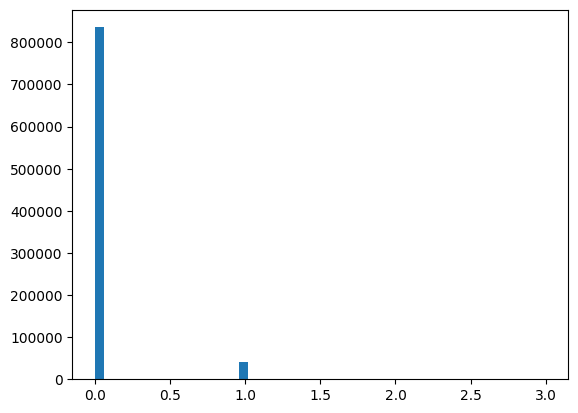





127 fr_Al_OH_noTert 0.0 0.0376 3.0


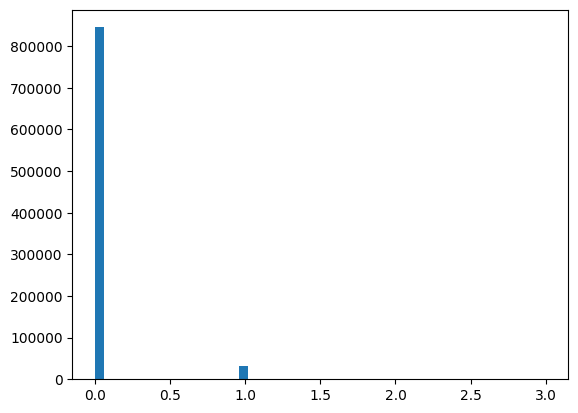





128 fr_ArN 0.0 0.001395 1.0


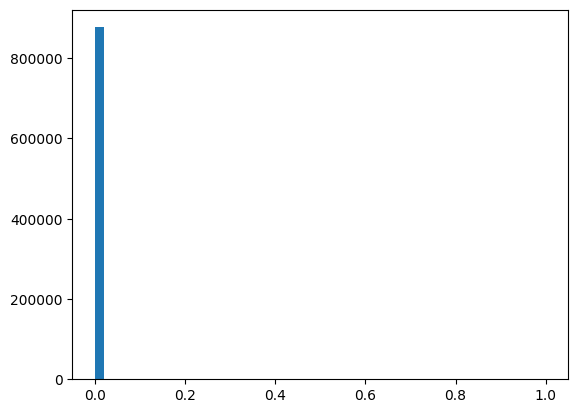





129 fr_Ar_COO 0.0 0.008865 1.0


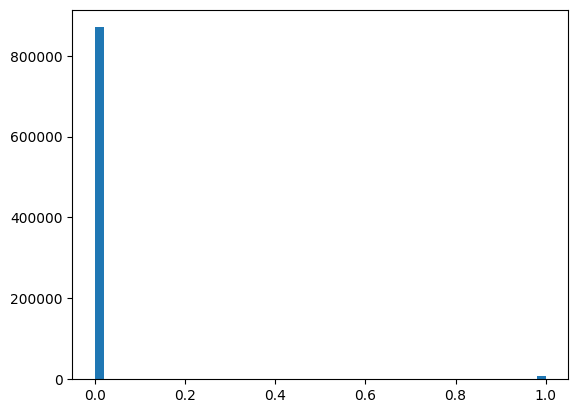





130 fr_Ar_N 0.0 3.428 15.0


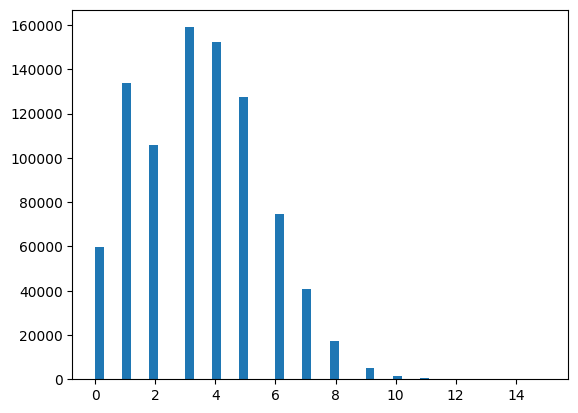





131 fr_Ar_NH 0.0 0.1848 4.0


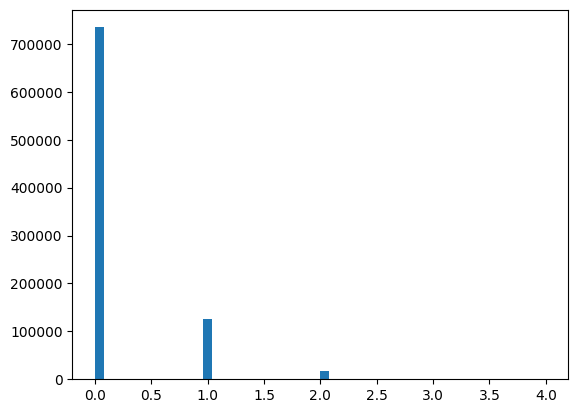





132 fr_Ar_OH 0.0 0.03506 3.0


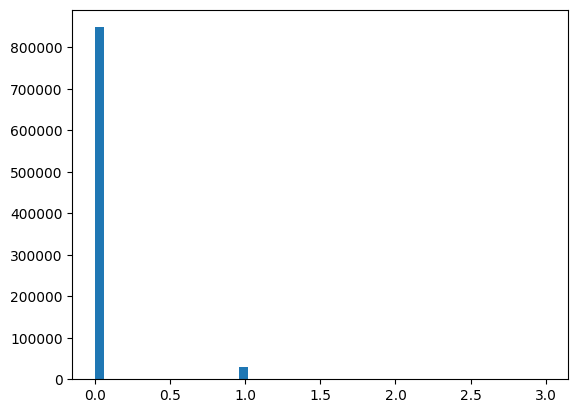





133 fr_COO 0.0 0.008865 1.0


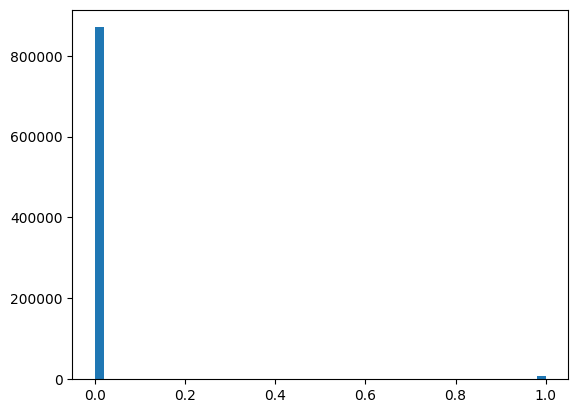





134 fr_COO2 0.0 0.008865 1.0


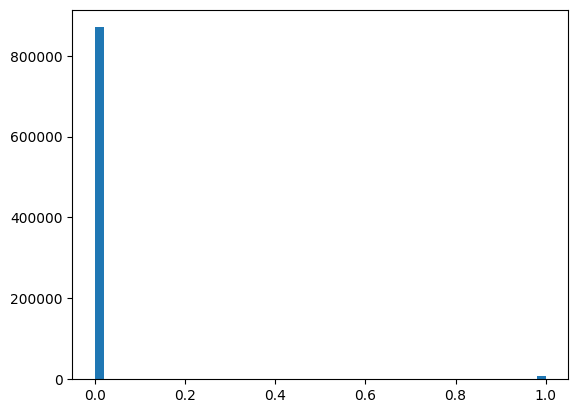





135 fr_C_O 1.0 1.854 7.0


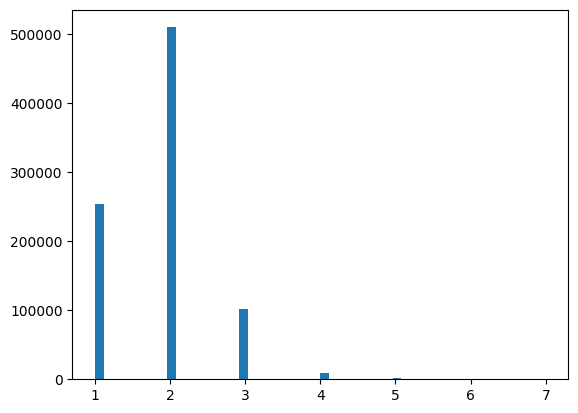





136 fr_C_O_noCOO 1.0 1.845 7.0


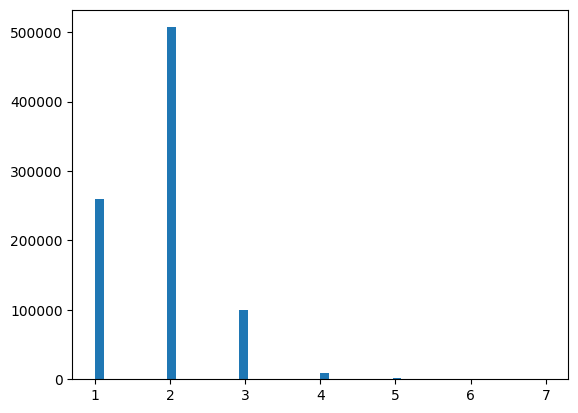





137 fr_C_S 0.0 0.000716 2.0


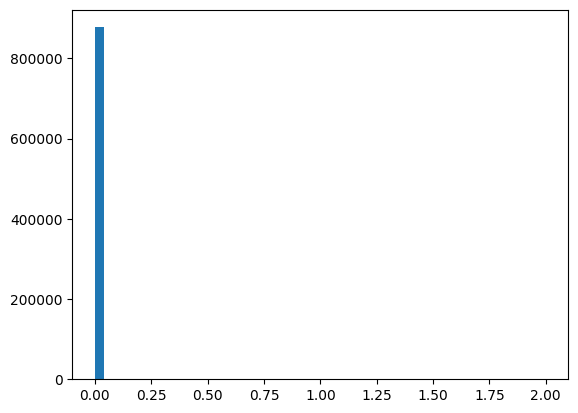





138 fr_HOCCN 0.0 0.003252 2.0


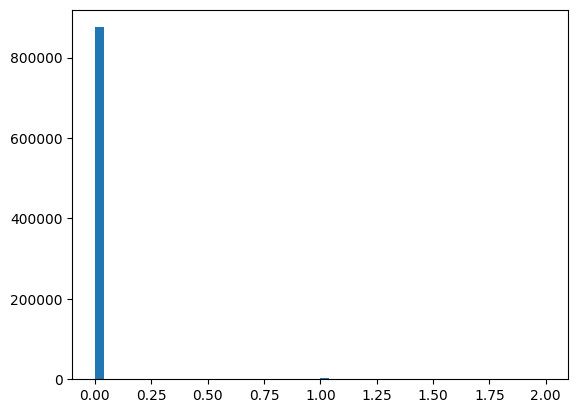





139 fr_Imine 0.0 0.003439 2.0


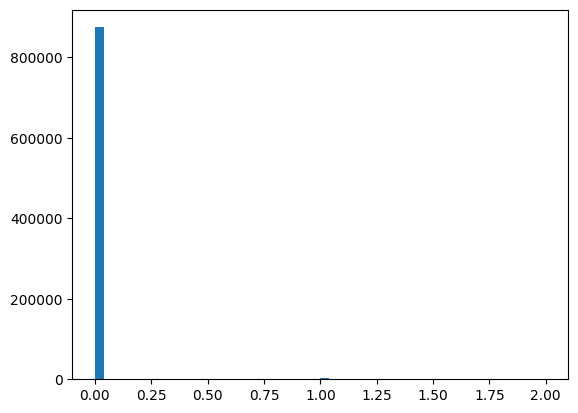





140 fr_NH0 1.0 4.32 15.0


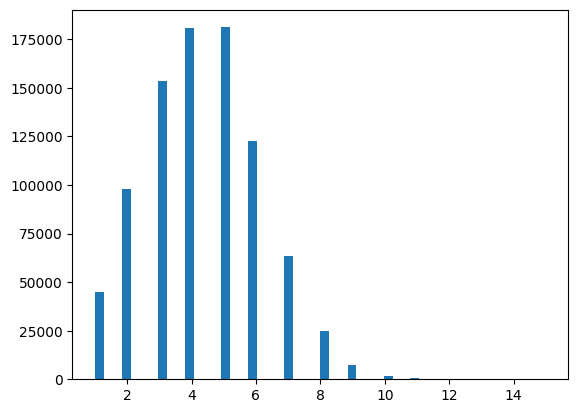





141 fr_NH1 1.0 2.754 9.0


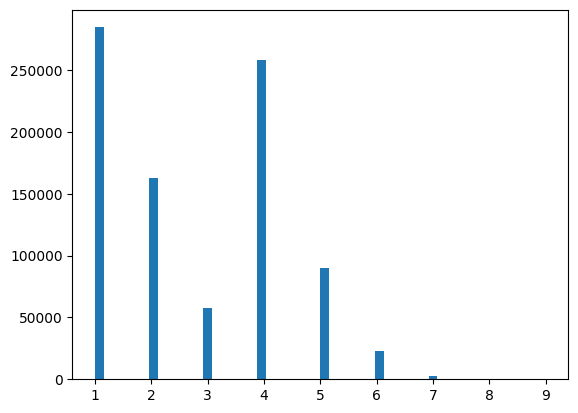





142 fr_NH2 0.0 0.02179 2.0


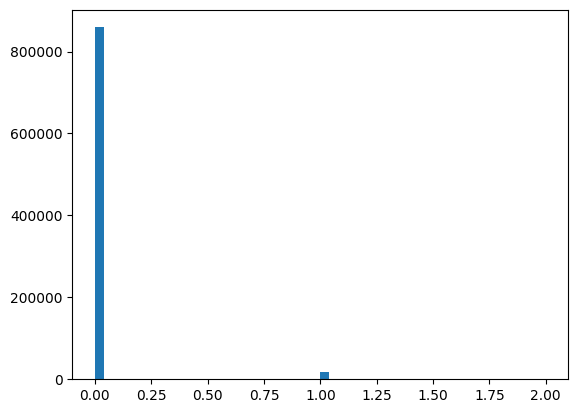





143 fr_N_O 0.0 0.006695 4.0


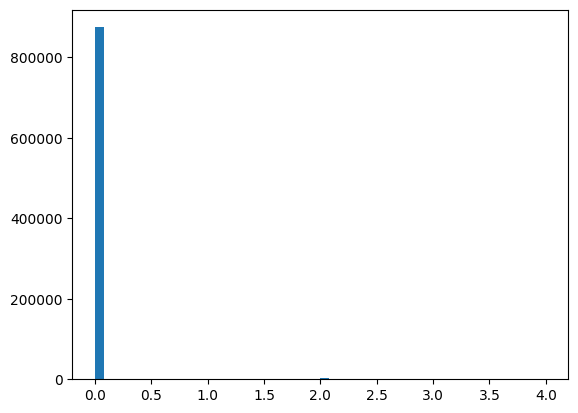





144 fr_Ndealkylation1 0.0 0.398 4.0


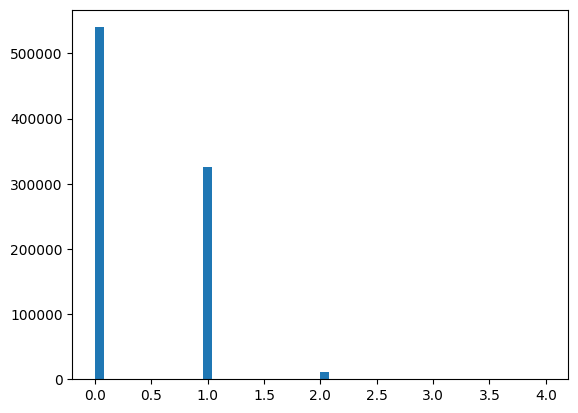





145 fr_Ndealkylation2 0.0 0.375 3.0


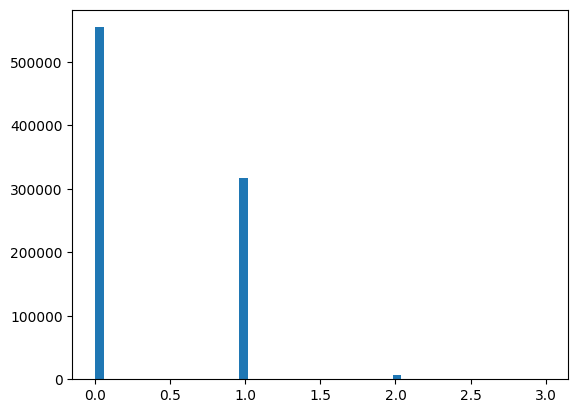





146 fr_Nhpyrrole 0.0 0.1848 4.0


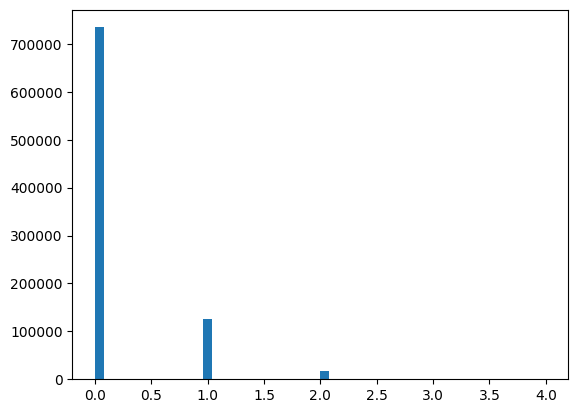





147 fr_SH 0.0 0.001503 2.0


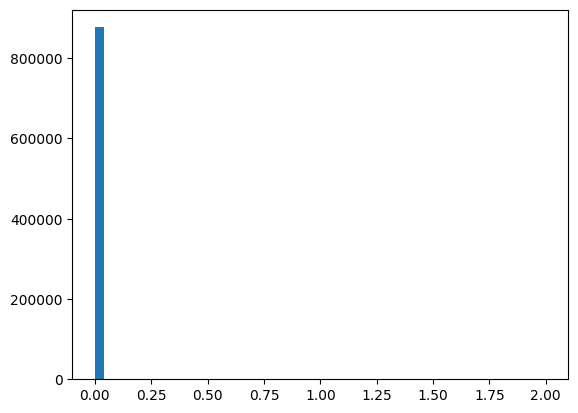





148 fr_aldehyde 0.0 0.002048 2.0


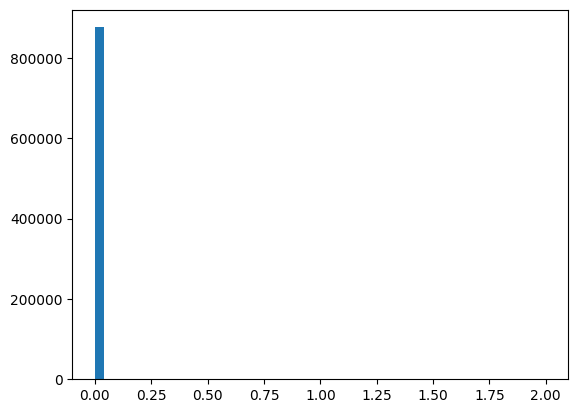





149 fr_alkyl_carbamate 0.0 0.002218 1.0


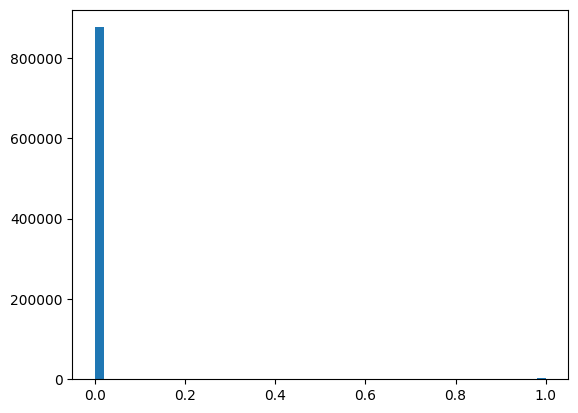





150 fr_alkyl_halide 0.0 0.5684 11.0


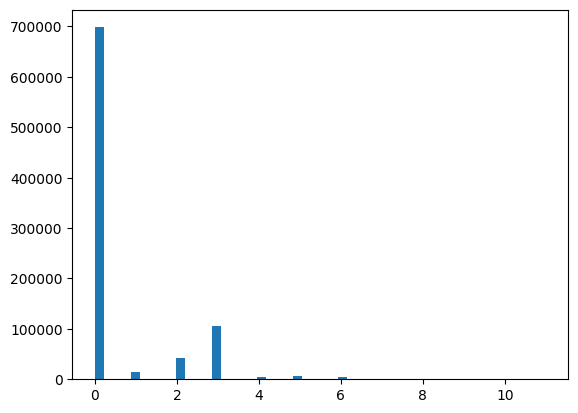





151 fr_allylic_oxid 0.0 0.05066 5.0


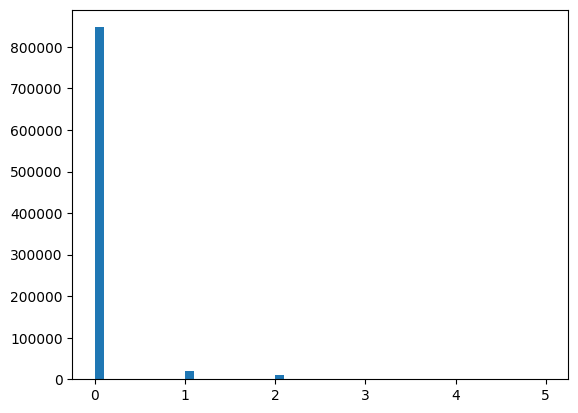





152 fr_amide 1.0 1.781 8.0


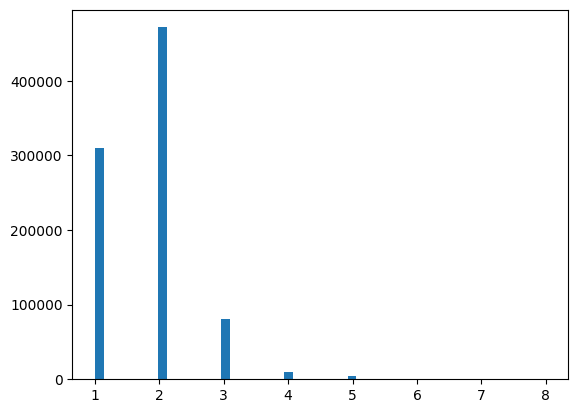





153 fr_amidine 0.0 0.005035 2.0


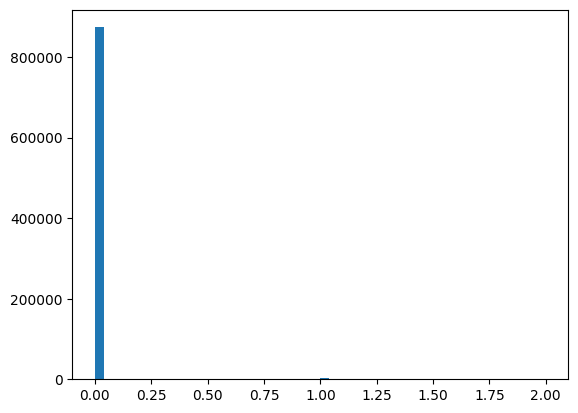





154 fr_aniline 0.0 2.32 9.0


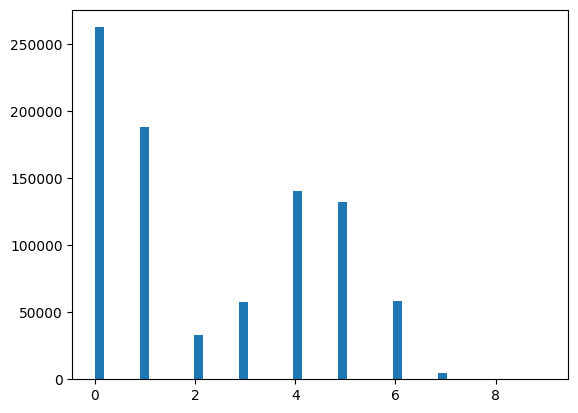





155 fr_aryl_methyl 0.0 0.5596 6.0


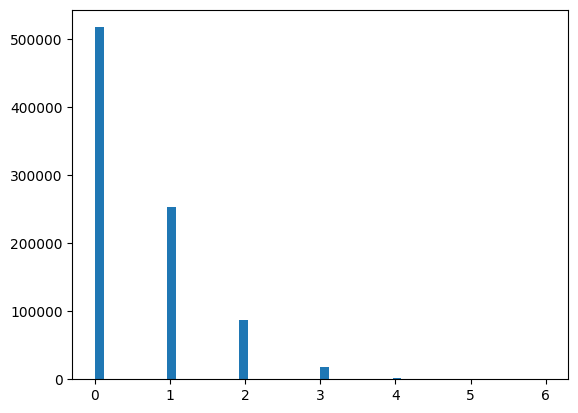





156 fr_azide 0.0 0.001694 1.0


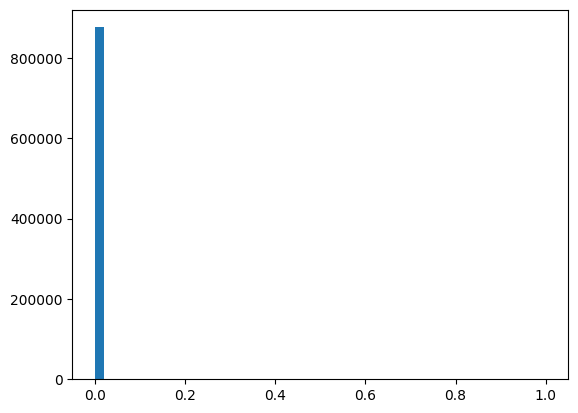





157 fr_azo 0.0 0.0 0.0


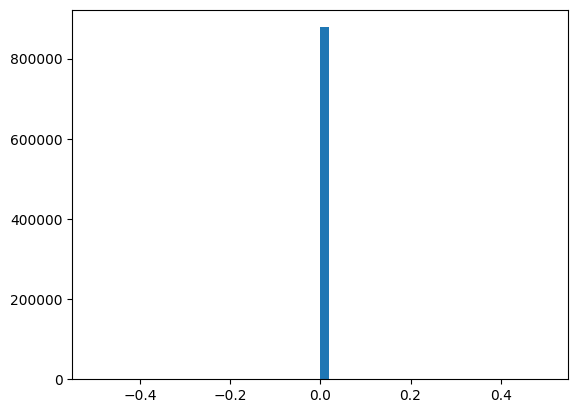





158 fr_barbitur 0.0 0.0 0.0


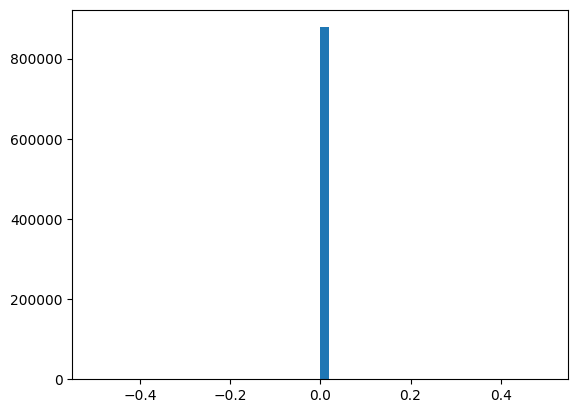





159 fr_benzene 0.0 1.401 6.0


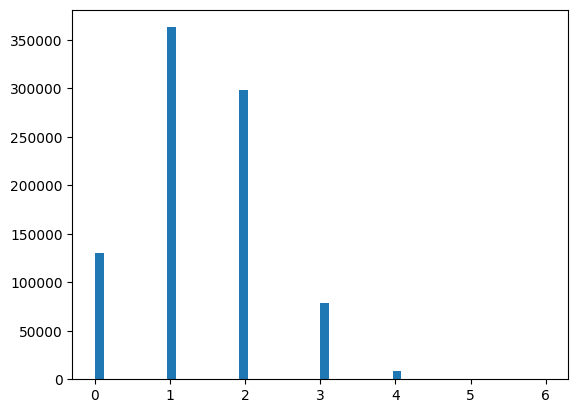





160 fr_benzodiazepine 0.0 0.0 0.0


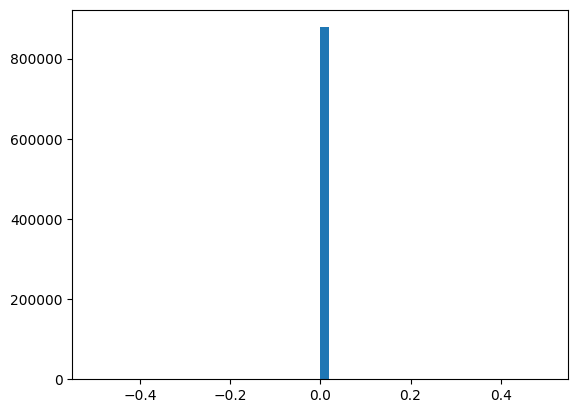





161 fr_bicyclic 0.0 0.5186 10.0


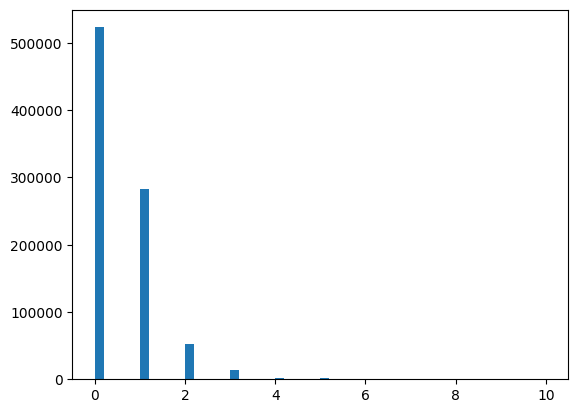





162 fr_diazo 0.0 0.0 0.0


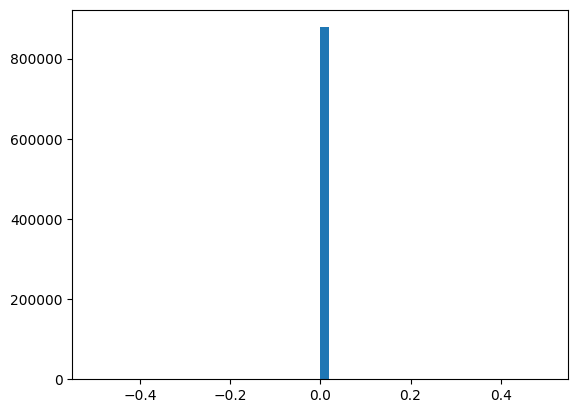





163 fr_dihydropyridine 0.0 0.0 0.0


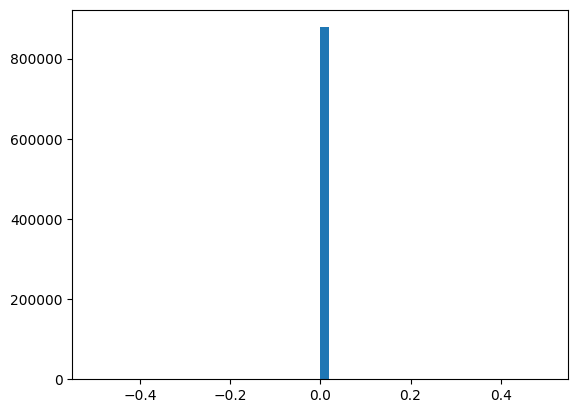





164 fr_epoxide 0.0 0.0 0.0


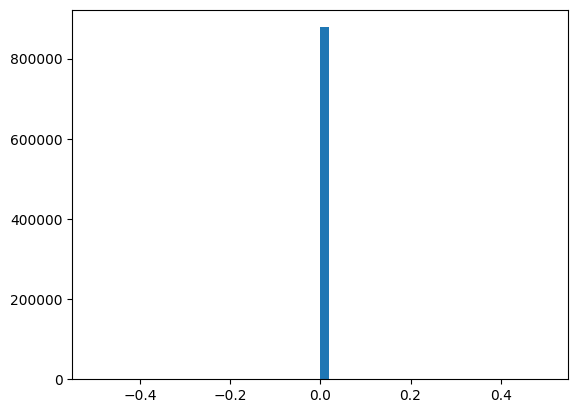





165 fr_ester 0.0 0.0586 3.0


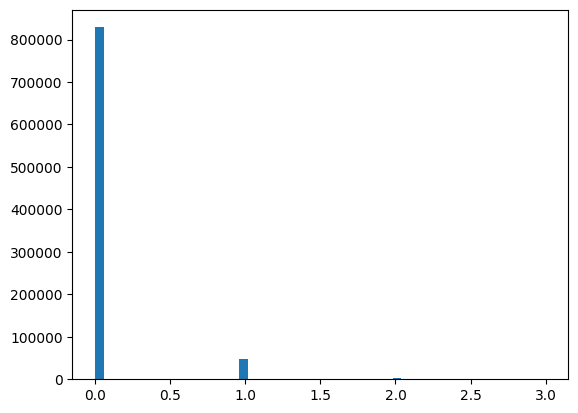





166 fr_ether 0.0 0.7944 7.0


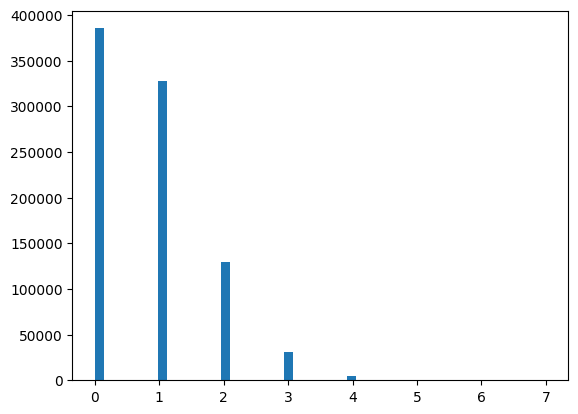





167 fr_furan 0.0 0.059 2.0


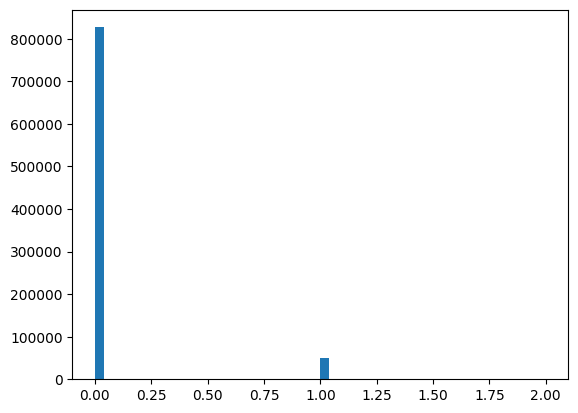





168 fr_guanido 0.0 0.0 0.0


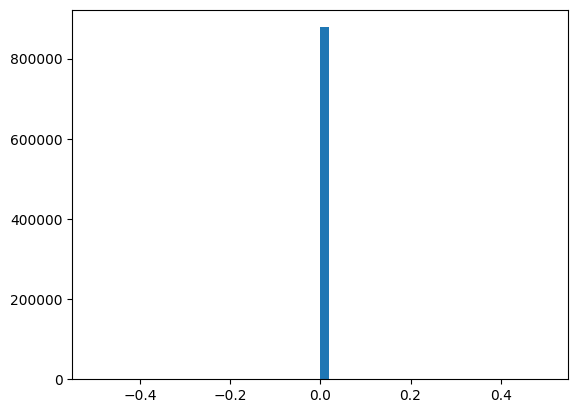





169 fr_halogen 0.0 1.209 11.0


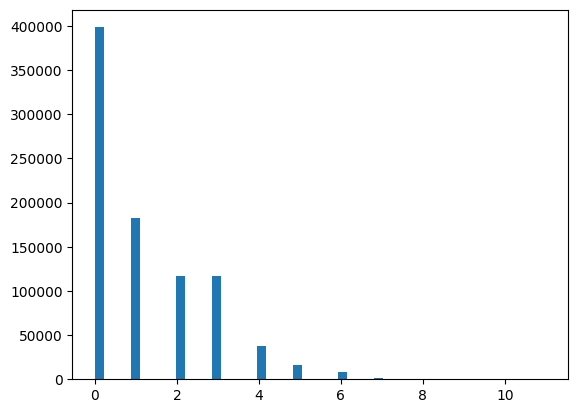





170 fr_hdrzine 0.0 0.0 0.0


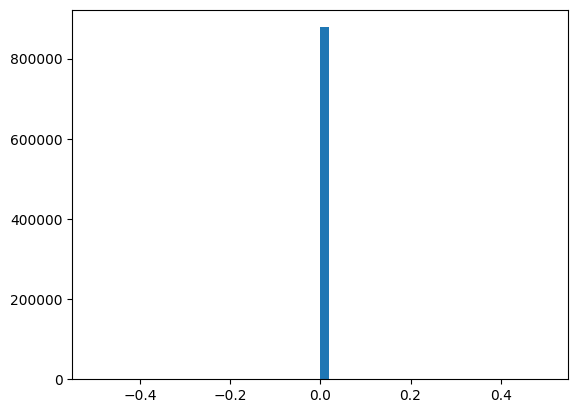





171 fr_hdrzone 0.0 0.002024 1.0


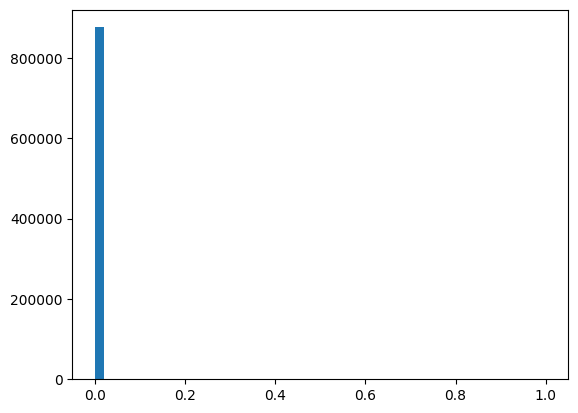





172 fr_imidazole 0.0 0.0938 3.0


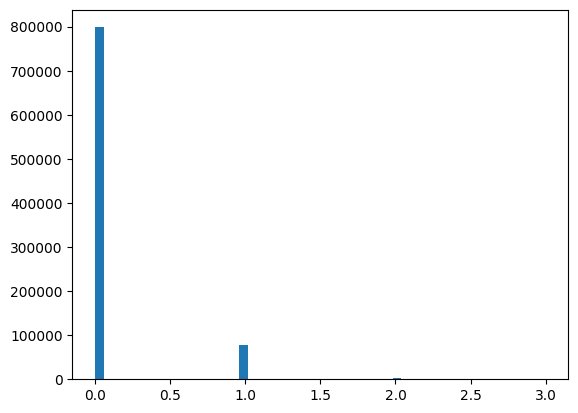





173 fr_imide 0.0 0.01345 3.0


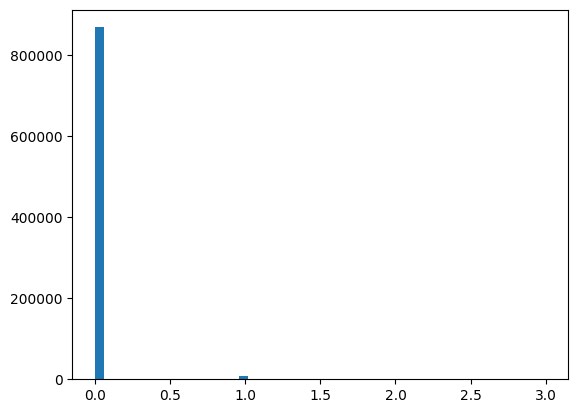





174 fr_isocyan 0.0 0.0 0.0


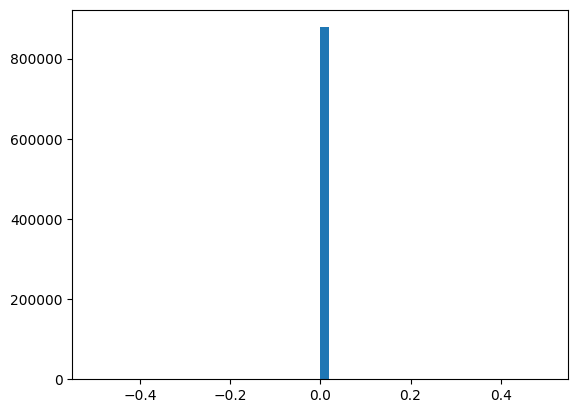





175 fr_isothiocyan 0.0 0.0 0.0


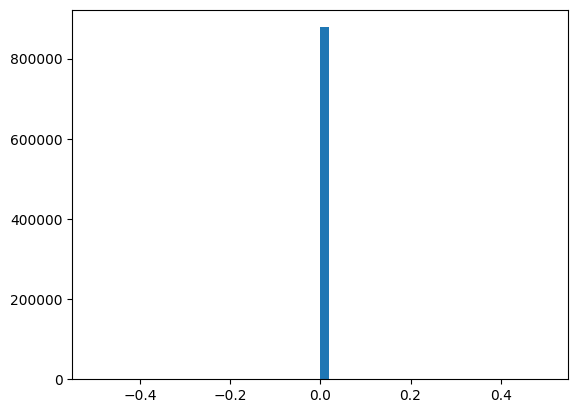





176 fr_ketone 0.0 0.01627 3.0


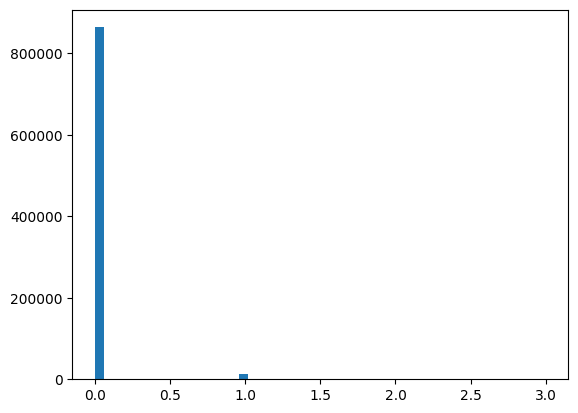





177 fr_ketone_Topliss 0.0 0.01452 3.0


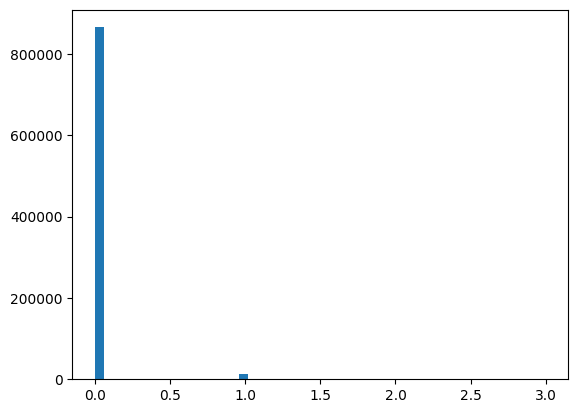





178 fr_lactam 0.0 0.0 0.0


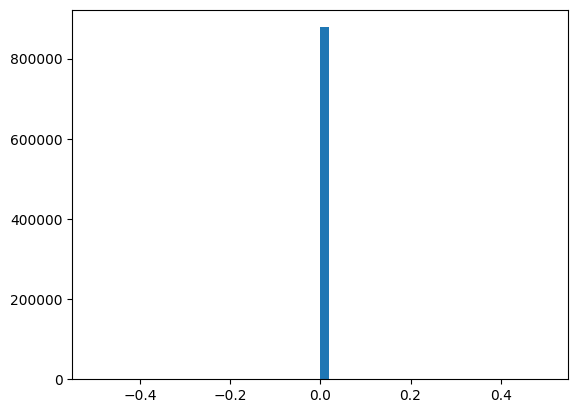





179 fr_lactone 0.0 0.003006 2.0


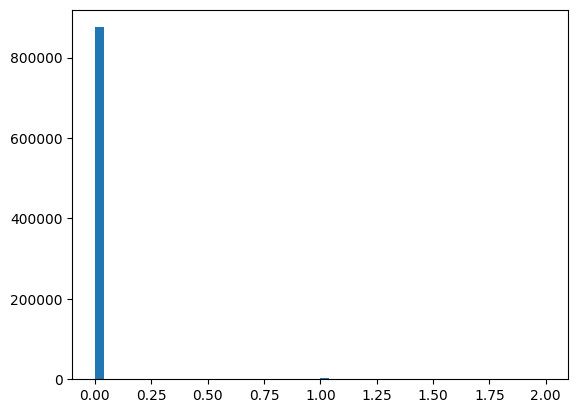





180 fr_methoxy 0.0 0.2299 6.0


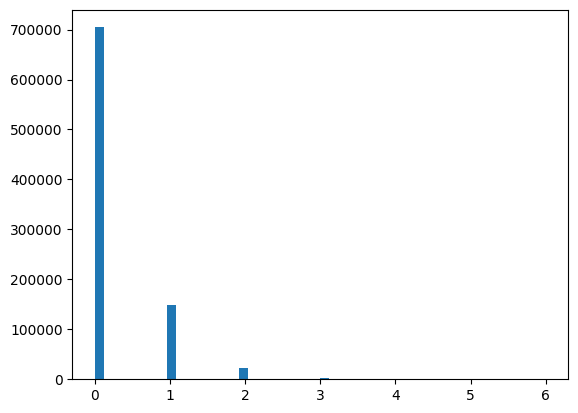





181 fr_morpholine 0.0 0.06067 3.0


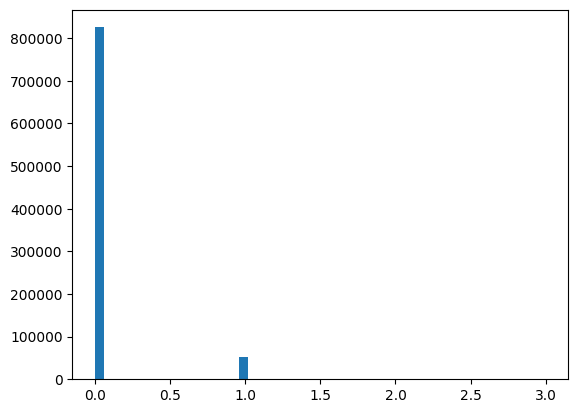





182 fr_nitrile 0.0 0.0804 3.0


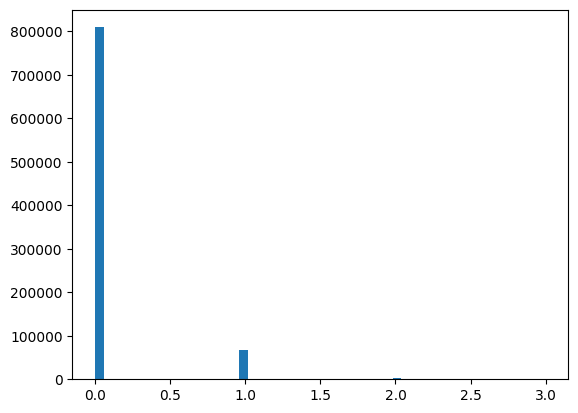





183 fr_nitro 0.0 0.0498 3.0


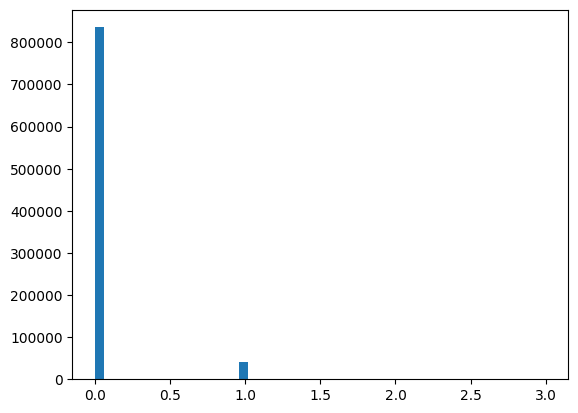





184 fr_nitro_arom 0.0 0.02972 3.0


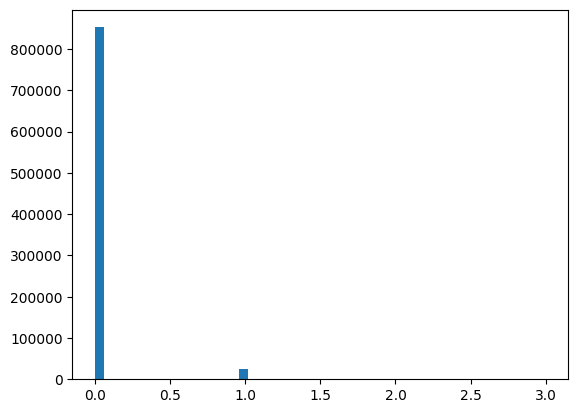





185 fr_nitro_arom_nonortho 0.0 0.01501 2.0


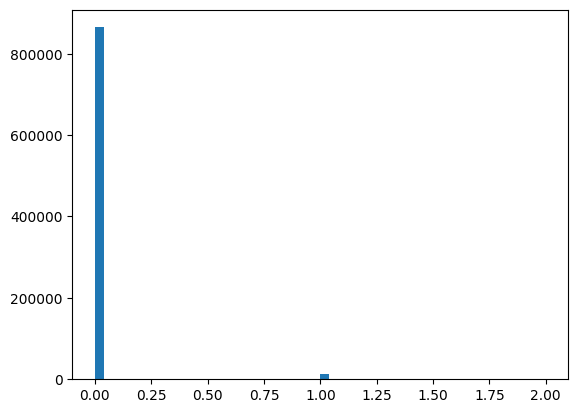





186 fr_nitroso 0.0 0.0 0.0


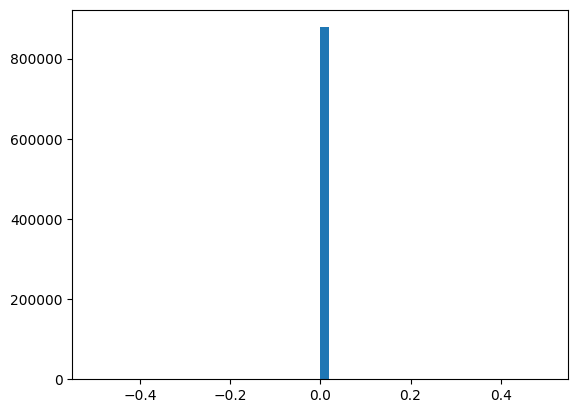





187 fr_oxazole 0.0 0.0246 2.0


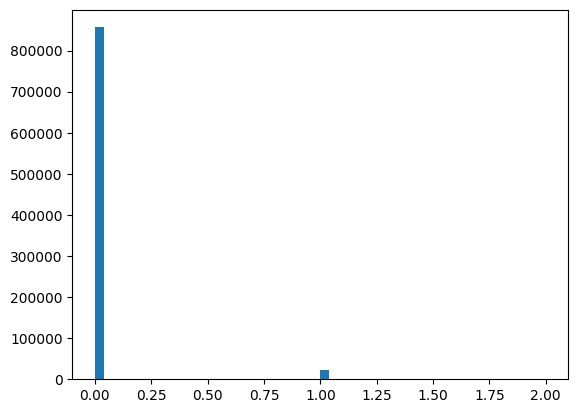





188 fr_oxime 0.0 0.00699 1.0


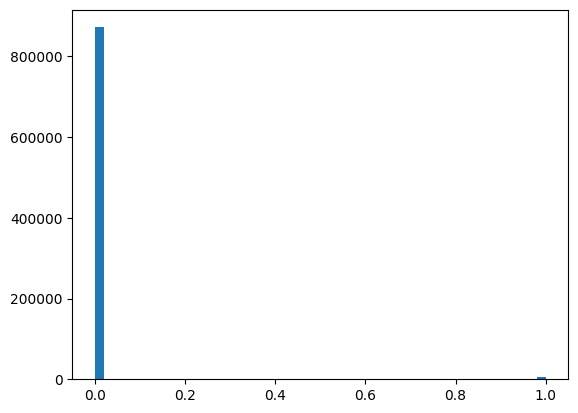





189 fr_para_hydroxylation 0.0 0.1584 5.0


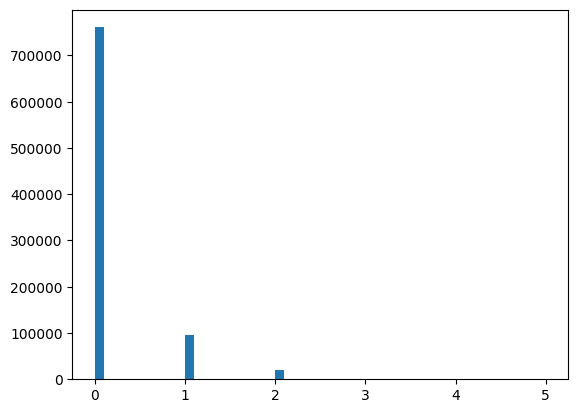





190 fr_phenol 0.0 0.02568 3.0


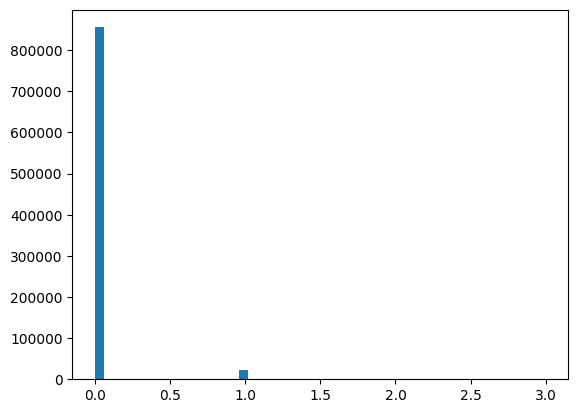





191 fr_phenol_noOrthoHbond 0.0 0.02568 3.0


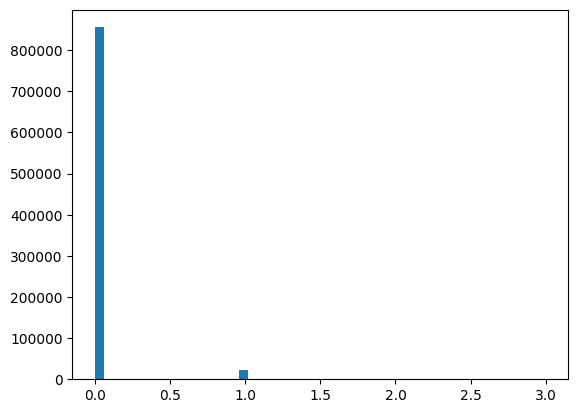





192 fr_phos_acid 0.0 0.0 0.0


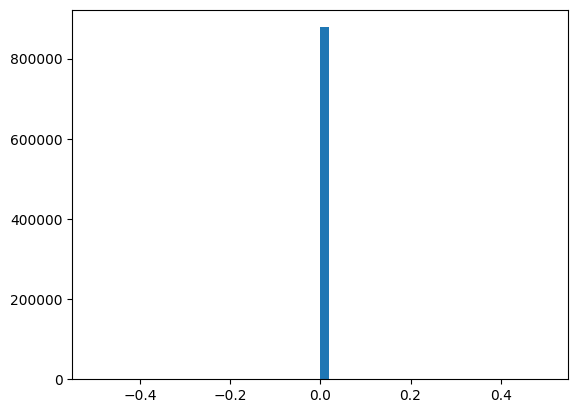





193 fr_phos_ester 0.0 0.0 0.0


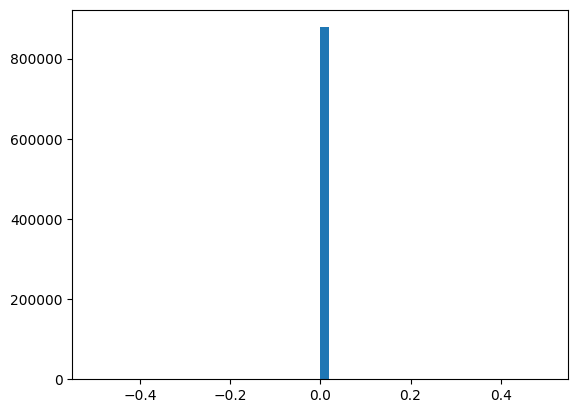





194 fr_piperdine 0.0 0.1836 6.0


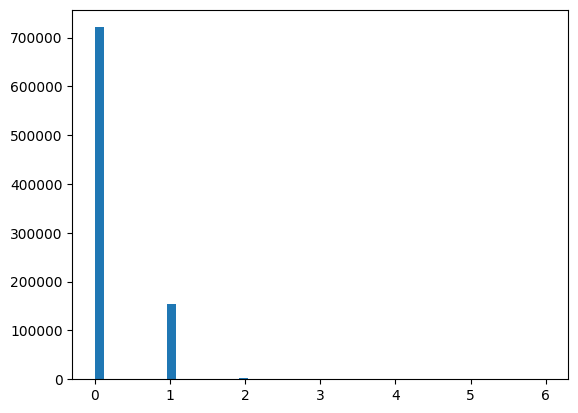





195 fr_piperzine 0.0 0.05905 4.0


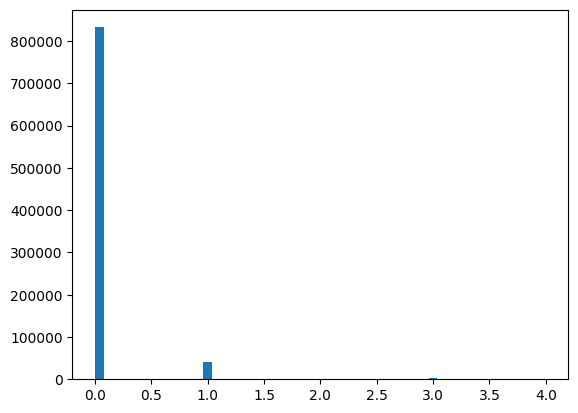





196 fr_priamide 0.0 0.01499 2.0


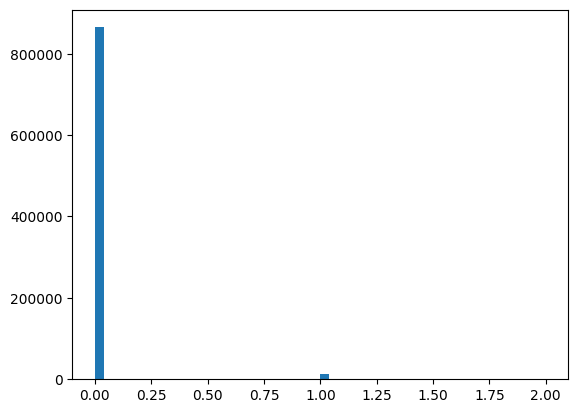





197 fr_prisulfonamd 0.0 0.0 0.0


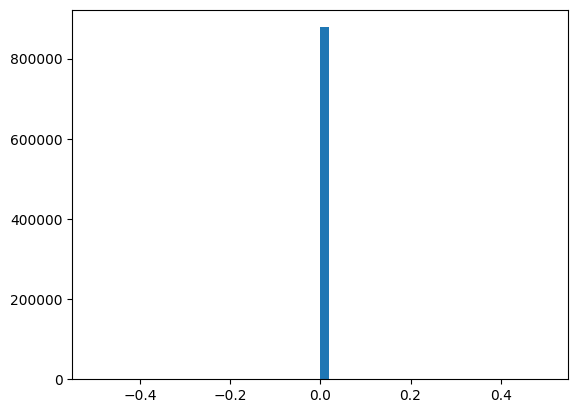





198 fr_pyridine 0.0 0.657 4.0


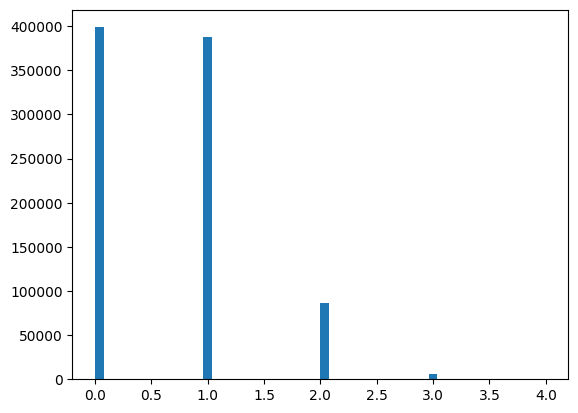





199 fr_quatN 0.0 0.0 0.0


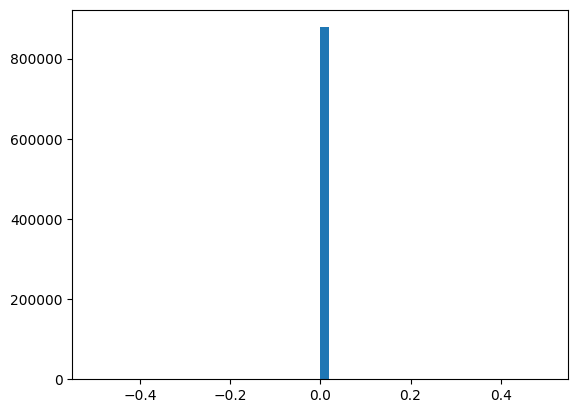





200 fr_sulfide 0.0 0.03473 4.0


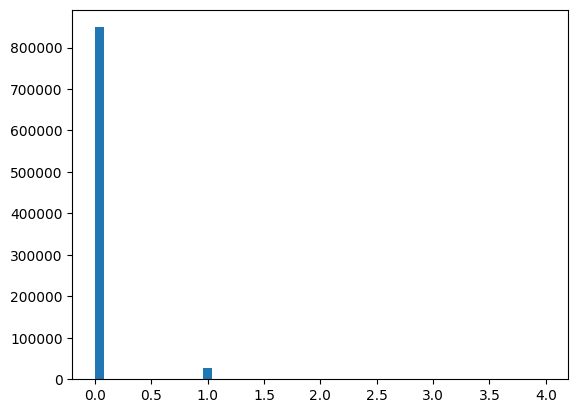





201 fr_sulfonamd 0.0 0.04874 2.0


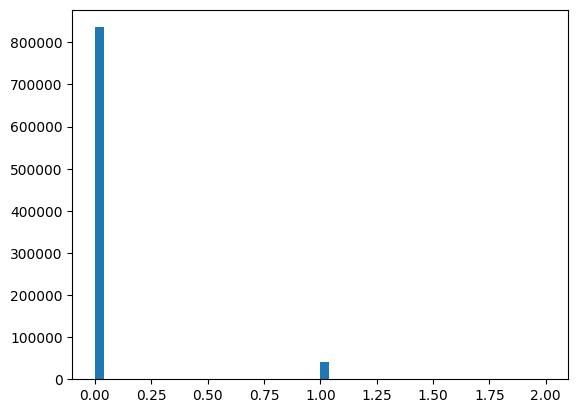





202 fr_sulfone 0.0 0.02386 2.0


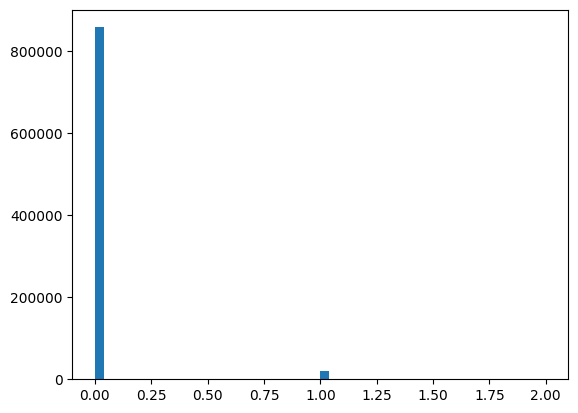





203 fr_term_acetylene 0.0 0.01351 2.0


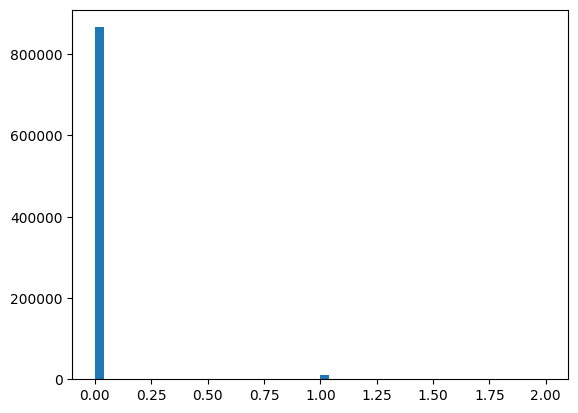





204 fr_tetrazole 0.0 0.01339 2.0


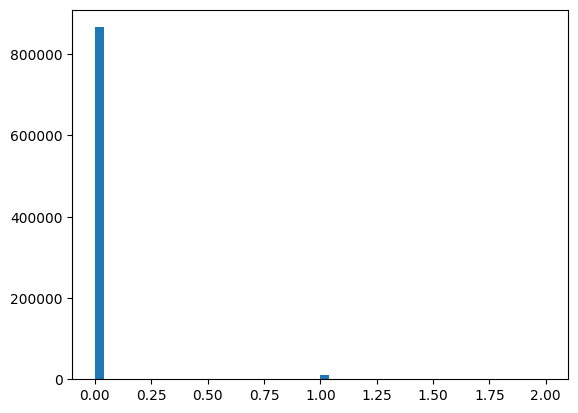





205 fr_thiazole 0.0 0.08527 3.0


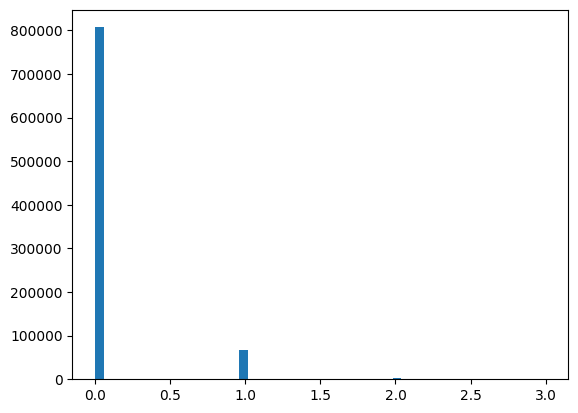





206 fr_thiocyan 0.0 0.0 0.0


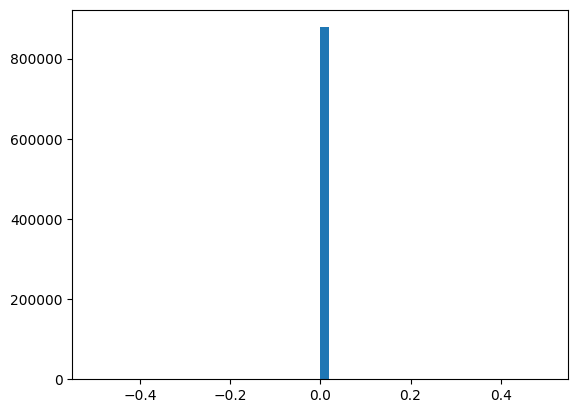





207 fr_thiophene 0.0 0.1153 3.0


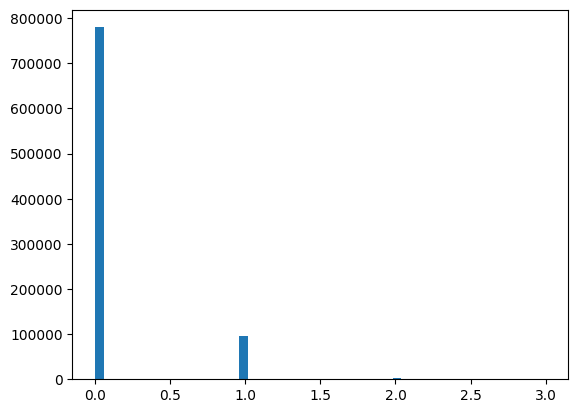





208 fr_unbrch_alkane 0.0 0.1007 7.0


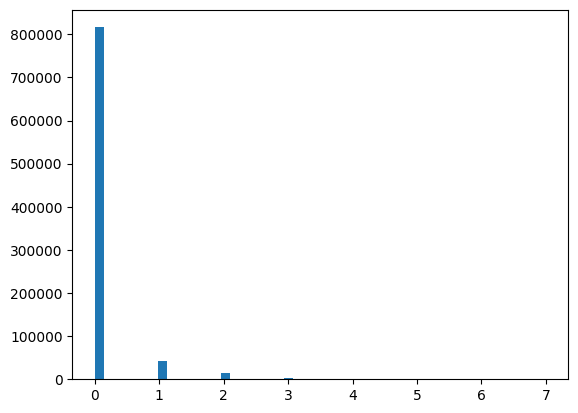





209 fr_urea 0.0 0.01434 2.0


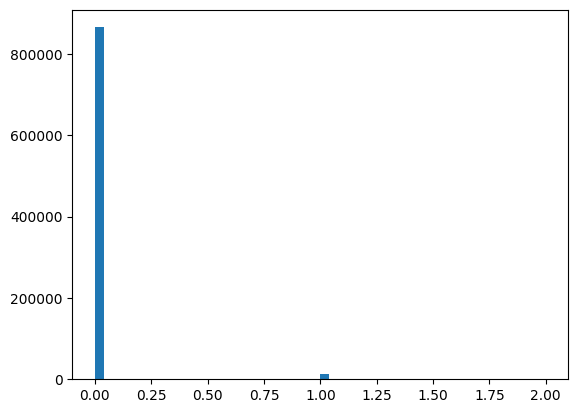

In [12]:
for feat_idx, feat_name in enumerate(RDKIT_DESCRIPTORS):
    feat = features[:, feat_idx]
    print(feat_idx, feat_name, feat.min(), feat.mean(), feat.max())
    plt.hist(feat, bins = 50)
    plt.show()
    print('\n\n\n')

In [8]:
np.histogram(features[:, 128], bins=200, density=True)

(array([199.67830782,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [41]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
# import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
#     for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']][:3]):
    
    for ii, distribution in enumerate(['gamma']):
        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def fit_dist(data, bins = 500):
    # Plot for comparison
    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots()
    plt.hist(data, bins=bins, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distributions = best_fit_distribution(data, bins, ax)
    best_dist = best_distributions[0]

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title('Best fit distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    plt.hist(data, bins=bins, density=True, alpha=0.5, label='Data')

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title('Best fit distribution \n' + dist_str)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    plt.show()
    return best_distributions, best_dist

  1 / 107: gamma


<Figure size 1200x800 with 0 Axes>

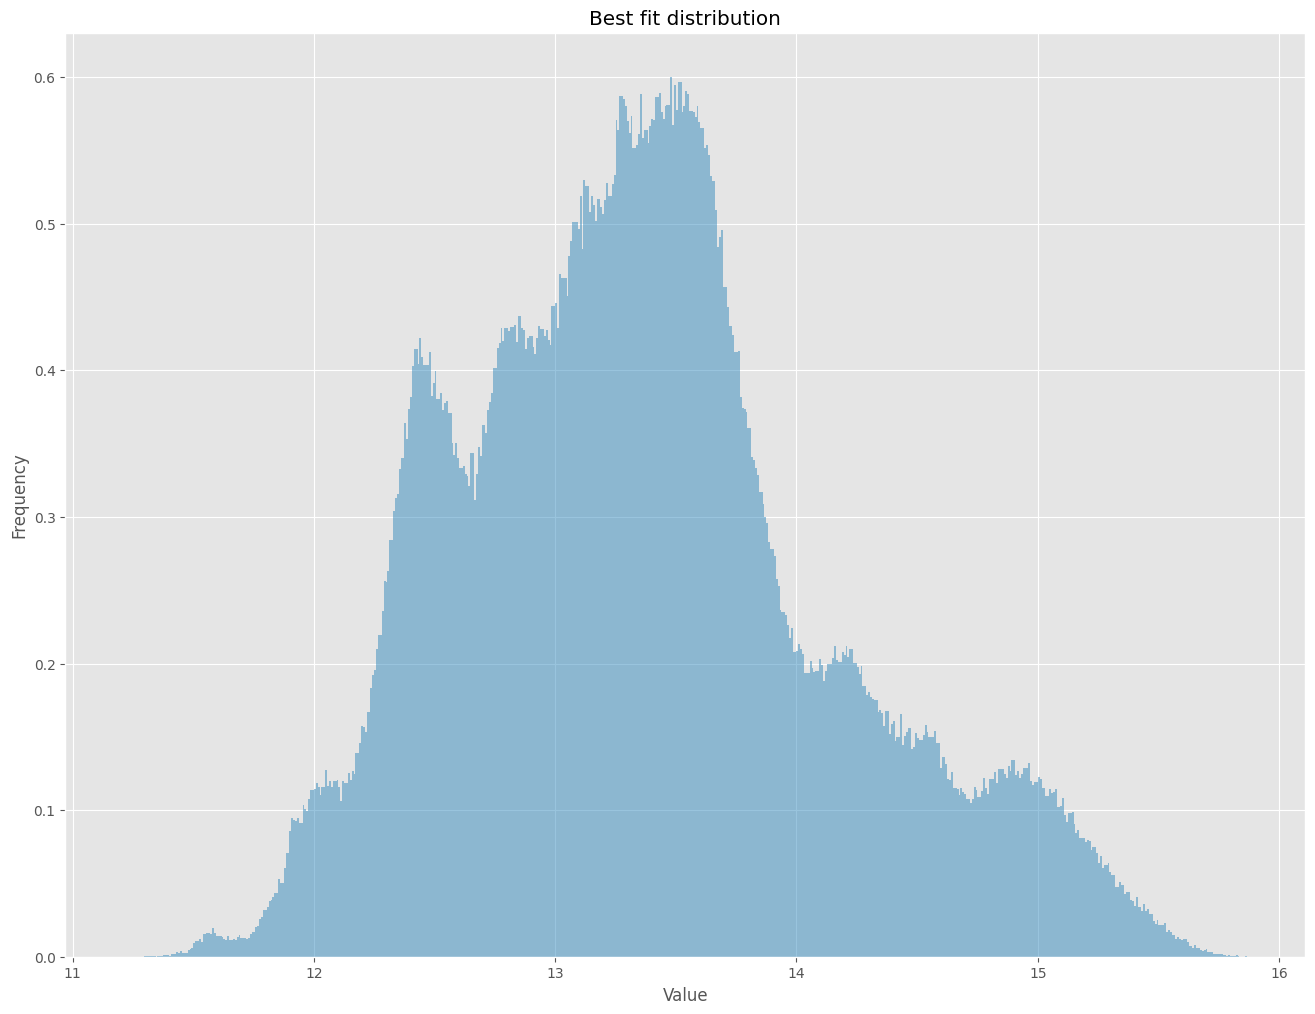

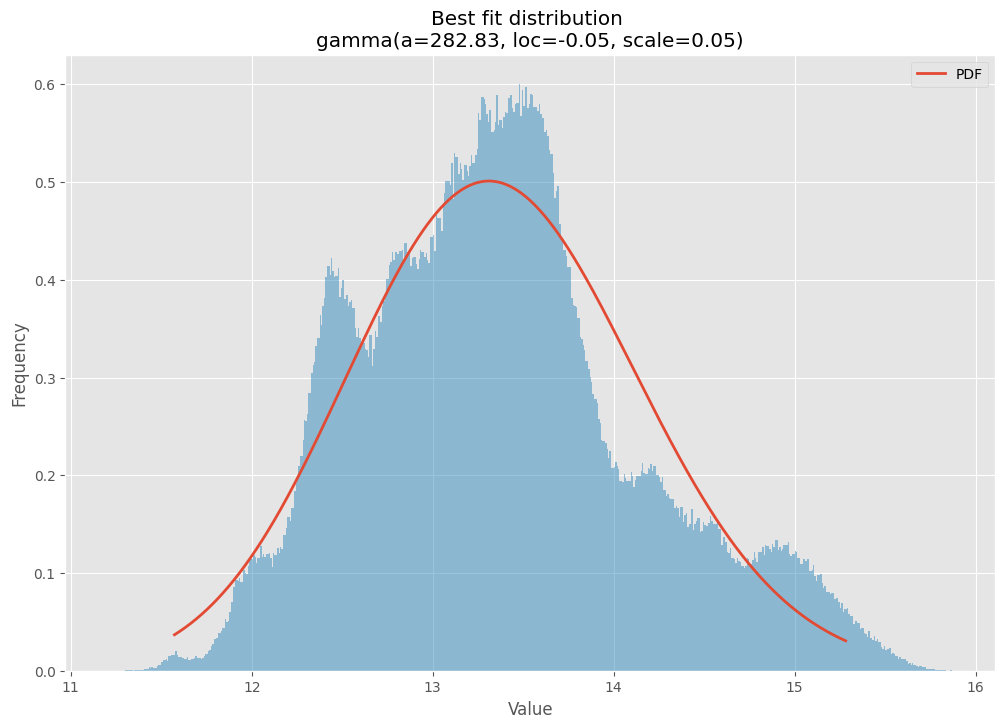

([(<scipy.stats._continuous_distns.gamma_gen at 0x7f2896ef4970>,
   (282.82652394766205, -0.051311615795456664, 0.04741095261167402),
   1.5191637630279011)],
 (<scipy.stats._continuous_distns.gamma_gen at 0x7f2896ef4970>,
  (282.82652394766205, -0.051311615795456664, 0.04741095261167402),
  1.5191637630279011))

In [42]:
fit_dist(features[:, 0])